In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv
/kaggle/input/smoker-status-prediction-using-biosignals/test_dataset.csv


In [2]:
from __future__ import print_function

import argparse, os, shutil, time, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torch.nn.functional as F



bcl.py

In [3]:
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
from __future__ import print_function

import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import numpy as np



class BalSCL(nn.Module):
    def __init__(self, cls_num_list=None, temperature=0.1):
        super(BalSCL, self).__init__()
        self.temperature = temperature
        self.cls_num_list = cls_num_list

    def forward(self, centers1, features, targets, ):

        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))
        batch_size = features.shape[0]
        targets = targets.contiguous().view(-1, 1)
        targets_centers = torch.arange(len(self.cls_num_list), device=device).view(-1, 1)
        targets = torch.cat([targets.repeat(2, 1), targets_centers], dim=0)
        batch_cls_count = torch.eye(len(self.cls_num_list))[targets].sum(dim=0).squeeze()

        mask = torch.eq(targets[:2 * batch_size], targets.T).float().to(device)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * 2).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        # class-complement
        features = torch.cat(torch.unbind(features, dim=1), dim=0)
        features = torch.cat([features, centers1], dim=0)
        logits = features[:2 * batch_size].mm(features.T)
        logits = torch.div(logits, self.temperature)

        # For numerical stability
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()

        # class-averaging
        exp_logits = torch.exp(logits) * logits_mask
        per_ins_weight = torch.tensor([batch_cls_count[i] for i in targets], device=device).view(1, -1).expand(
            2 * batch_size, 2 * batch_size + len(self.cls_num_list)) - mask
        exp_logits_sum = exp_logits.div(per_ins_weight).sum(dim=1, keepdim=True)
        
        log_prob = logits - torch.log(exp_logits_sum)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        loss = - mean_log_prob_pos
        loss = loss.view(2, batch_size).mean()
        return loss




class LogitAdjust(nn.Module):

    def __init__(self, cls_num_list, tau=1, weight=None):
        super(LogitAdjust, self).__init__()
        cls_num_list = torch.cuda.FloatTensor(cls_num_list)
        cls_p_list = cls_num_list / cls_num_list.sum()
        m_list = tau * torch.log(cls_p_list)
        self.m_list = m_list.view(1, -1)
        self.weight = weight

    def forward(self, x, target):
        x_m = x + self.m_list
        return F.cross_entropy(x_m, target, weight=self.weight)


class BCLLoss(nn.Module):
    def __init__(self, cls_num_list, tau=1, weight=None, temperature = 0.1, alpha=2.0, beta=0.6 ):
        super(BCLLoss, self).__init__()
        self.criterion_ce = LogitAdjust(cls_num_list).cuda()
        self.criterion_scl = BalSCL(cls_num_list, temperature).cuda()
        self.alpha = alpha
        self.beta = beta
        
    def forward(self, centers,  logits, features, targets):
        scl_loss = self.criterion_scl(centers, features, targets)
        ce_loss = self.criterion_ce(logits, targets)

        return self.alpha * ce_loss + self.beta * scl_loss


        


bs.py

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class BS(nn.Module):
    def __init__(self, dist):
        super().__init__()
        dist = torch.from_numpy(np.array(dist)).float().cuda()
        self.prob = dist / sum(dist)
        self.log_prior = torch.log(self.prob).unsqueeze(0)
        
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        adjusted_logits = logits + self.log_prior
        return F.cross_entropy(adjusted_logits, targets, reduction = reduction)
        
        
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # logits = logits + torch.log(self.prob.view(1, -1).expand(logits.shape[0], -1)).cuda()
        
        # if reduction == 'none':
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

ce drw

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CE_DRW(nn.Module):
    
    def __init__(self, cls_num_list, reweight_epoch=160):
        super(CE_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch= reweight_epoch
        
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights

    def forward(self, x, target, epoch, reduction='mean'):
        self.drw(epoch)
        return F.cross_entropy(x, target, weight=self.weight, reduction=reduction)

ce

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CE(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # if reduction == 'mean':
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

        return F.cross_entropy(logits, targets, weight = self.weight, reduction = reduction)

ldam drw

In [7]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LDAM_DRW(nn.Module):
    def __init__(self, cls_num_list, reweight_epoch, max_m=0.5, s=30):
        super(LDAM_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch = reweight_epoch
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
      
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights


    def forward(self, x, target, epoch=None, reduction='mean'):
        self.drw(epoch)
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight, reduction=reduction)

ncl

In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F

def NBOD(inputs, factor):

    classifier_num = len(inputs)
    if classifier_num == 1:
        return 0
    logits_softmax = []
    logits_logsoftmax = []
    for i in range(classifier_num):
        logits_softmax.append(F.softmax(inputs[i], dim=1))
        logits_logsoftmax.append(torch.log(logits_softmax[i] + 1e-9))

    loss_mutual = 0
    for i in range(classifier_num):
        for j in range(classifier_num):
            if i == j:
                continue
            loss_mutual += factor * F.kl_div(logits_logsoftmax[i], logits_softmax[j],reduction='batchmean')
    loss_mutual /= (classifier_num - 1)
    return  loss_mutual

class NIL_NBOD(nn.Module):
    def __init__(self, args, num_class_list):
        super(NIL_NBOD, self).__init__()
        self.args = args
        self.num_class_list = num_class_list
        self.bsce_weight = torch.FloatTensor(self.num_class_list).cuda()


        self.multi_classifier_diversity_factor = 0.6
        self.multi_classifier_diversity_factor_hcm = 0.6
        self.ce_ratio = 1.0
        self.hcm_ratio = 1.0
        if self.args.dataset == 'cifar100':
            self.hcm_N = 30
        elif self.args.dataset == 'imgnet':
            self.hcm_N = 300
        elif self.args.dataset == 'places':
            self.hcm_N = 122
        elif self.args.dataset == 'inat':
            self.hcm_N = 2442



    def forward(self, inputs, targets, **kwargs):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (classifier_num, batch_size, num_classes)
            targets: ground truth labels with shape (classifier_num, batch_size)
        """
        classifier_num = len(inputs)
        loss_HCM = 0
        loss = 0
        los_ce = 0

        inputs_HCM_balance = []
        inputs_balance = []
        class_select = inputs[0].scatter(1, targets[0].unsqueeze(1), 999999)
        class_select_include_target = class_select.sort(descending=True, dim=1)[1][:, :self.hcm_N]
        mask = torch.zeros_like(inputs[0]).scatter(1, class_select_include_target, 1)
        for i in range(classifier_num):

            logits = inputs[i] + self.bsce_weight.unsqueeze(0).expand(inputs[i].shape[0], -1).log()
            inputs_balance.append(logits)
            inputs_HCM_balance.append(logits * mask)

            los_ce += F.cross_entropy(logits, targets[0])
            loss_HCM += F.cross_entropy(inputs_HCM_balance[i], targets[0])

        loss += NBOD(inputs_balance, factor=self.multi_classifier_diversity_factor)
        loss += NBOD(inputs_HCM_balance, factor=self.multi_classifier_diversity_factor_hcm)
        loss += los_ce * self.ce_ratio + loss_HCM * self.hcm_ratio
        return loss

    def update(self, epoch):
        """
        Args:
           code can be added for progressive loss.
        """
        pass


if __name__ == '__main__':
    pass

ride

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random

class RIDE(nn.Module):
    def __init__(self, cls_num_list=None, base_diversity_temperature=1.0, max_m=0.5, s=30, reweight=True, reweight_epoch=-1, 
        base_loss_factor=1.0, additional_diversity_factor=-0.2, reweight_factor=0.05):
        super().__init__()
        self.base_loss = F.cross_entropy
        self.base_loss_factor = base_loss_factor
        if not reweight:
            self.reweight_epoch = -1
        else:
            self.reweight_epoch = reweight_epoch

        # LDAM is a variant of cross entropy and we handle it with self.m_list.
        if cls_num_list is None:
            # No cls_num_list is provided, then we cannot adjust cross entropy with LDAM.

            self.m_list = None
            self.per_cls_weights_enabled = None
            self.per_cls_weights_enabled_diversity = None
        else:
            # We will use LDAM loss if we provide cls_num_list.

            m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
            m_list = m_list * (max_m / np.max(m_list))
            m_list = torch.tensor(m_list, dtype=torch.float, requires_grad=False)
            self.m_list = m_list
            self.s = s
            assert s > 0
            
            if reweight_epoch != -1:
                idx = 1 # condition could be put in order to set idx
                betas = [0, 0.9999]
                effective_num = 1.0 - np.power(betas[idx], cls_num_list)
                per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
                per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list)
                self.per_cls_weights_enabled = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False)
            else:
                self.per_cls_weights_enabled = None

            cls_num_list = np.array(cls_num_list) / np.sum(cls_num_list)
            C = len(cls_num_list)
            per_cls_weights = C * cls_num_list * reweight_factor + 1 - reweight_factor

            # Experimental normalization: This is for easier hyperparam tuning, the effect can be described in the learning rate so the math formulation keeps the same.
            # At the same time, the 1 - max trick that was previously used is not required since weights are already adjusted.
            per_cls_weights = per_cls_weights / np.max(per_cls_weights)

            assert np.all(per_cls_weights > 0), "reweight factor is too large: out of bounds"
            # save diversity per_cls_weights
            self.per_cls_weights_enabled_diversity = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False).cuda()

        self.base_diversity_temperature = base_diversity_temperature
        self.additional_diversity_factor = additional_diversity_factor

    def to(self, device):
        super().to(device)
        if self.m_list is not None:
            self.m_list = self.m_list.to(device)
        
        if self.per_cls_weights_enabled is not None:
            self.per_cls_weights_enabled = self.per_cls_weights_enabled.to(device)

        if self.per_cls_weights_enabled_diversity is not None:
            self.per_cls_weights_enabled_diversity = self.per_cls_weights_enabled_diversity.to(device)

        return self

    def _hook_before_epoch(self, epoch):
        if self.reweight_epoch != -1:
            self.epoch = epoch

            if epoch > self.reweight_epoch:
                self.per_cls_weights_base = self.per_cls_weights_enabled
                self.per_cls_weights_diversity = self.per_cls_weights_enabled_diversity
            else:
                self.per_cls_weights_base = None
                self.per_cls_weights_diversity = None

    def get_final_output(self, output_logits, target):
        x = output_logits

        index = torch.zeros_like(x, dtype=torch.uint8, device=x.device)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.float()
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m * self.s

        final_output = torch.where(index, x_m, x)
        return final_output

    def forward(self, output_logits, target, extra_info=None, reduction='mean'):
        if extra_info is None:
            return self.base_loss(output_logits, target)

        if reduction == 'none':
            loss = torch.zeros_like(target).float()
        else:
            loss = 0


        # Adding RIDE Individual Loss for each expert
        for logits_item in extra_info['logits']:
            ride_loss_logits = output_logits if self.additional_diversity_factor == 0 else logits_item
            if self.m_list is None:
                loss += self.base_loss_factor * self.base_loss(ride_loss_logits, target, reduction=reduction)
            else:
                final_output = self.get_final_output(ride_loss_logits, target)
                loss += self.base_loss_factor * self.base_loss(final_output, target, weight=self.per_cls_weights_base, reduction=reduction)
            
            base_diversity_temperature = self.base_diversity_temperature

            if self.per_cls_weights_diversity is not None:
                diversity_temperature = base_diversity_temperature * self.per_cls_weights_diversity.view((1, -1))
                temperature_mean = diversity_temperature.mean().item()
            else:
                diversity_temperature = base_diversity_temperature
                temperature_mean = base_diversity_temperature
            
            output_dist = F.log_softmax(logits_item / diversity_temperature, dim=1)
            with torch.no_grad():
                # Using the mean takes only linear instead of quadratic time in computing and has only a slight difference so using the mean is preferred here
                mean_output_dist = F.softmax(output_logits / diversity_temperature, dim=1)
            
            loss += self.additional_diversity_factor * temperature_mean * temperature_mean * F.kl_div(output_dist, mean_output_dist, reduction='batchmean')
        
        return loss

class RIDEWithDistill(nn.Module):
    def __init__(self, cls_num_list=None, additional_distill_loss_factor=1.0, distill_temperature=1.5, ride_loss_factor=1.0, **kwargs):
        super().__init__()
        self.ride_loss = RIDE(cls_num_list=cls_num_list, **kwargs)
        self.distill_temperature = distill_temperature

        self.ride_loss_factor = ride_loss_factor
        self.additional_distill_loss_factor = additional_distill_loss_factor

    def to(self, device):
        super().to(device)
        self.ride_loss = self.ride_loss.to(device)
        return self

    def _hook_before_epoch(self, epoch):
        self.ride_loss._hook_before_epoch(epoch)

    def forward(self, student, target=None, teacher=None, extra_info=None):
        output_logits = student
        if extra_info is None:
            return self.ride_loss(output_logits, target)

        loss = 0
        num_experts = len(extra_info['logits'])
        for logits_item in extra_info['logits']:
            loss += self.ride_loss_factor * self.ride_loss(output_logits, target, extra_info)
            distill_temperature = self.distill_temperature

            student_dist = F.log_softmax(student / distill_temperature, dim=1)
            with torch.no_grad():
                teacher_dist = F.softmax(teacher / distill_temperature, dim=1)
            
            distill_loss = F.kl_div(student_dist, teacher_dist, reduction='batchmean')
            distill_loss = distill_temperature * distill_temperature * distill_loss
            loss += self.additional_distill_loss_factor * distill_loss
        return loss

common.py


In [10]:
from __future__ import print_function

import argparse, os, shutil, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

!pip install progress
# added on my own
import progress 
#end

from progress.bar import Bar as Bar

def make_imb_data(max_num, class_num, gamma):
    mu = np.power(1/gamma, 1/(class_num - 1))
    class_num_list = []
    for i in range(class_num):
        if i == (class_num - 1):
            class_num_list.append(int(max_num / gamma))
        else:
            class_num_list.append(int(max_num * np.power(mu, i)))
    print(class_num_list)
    return list(class_num_list)

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def save_checkpoint(state, epoch, checkpoint='none', filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    
    if epoch % 100 == 0:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_' + str(epoch) + '.pth.tar'))
        
def linear_rampup(current, rampup_length=0):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)
    
def adjust_learning_rate(optimizer, epoch, scheduler, args):
    if scheduler == None:
        if args.epochs == 200:
            epoch = epoch + 1
            if epoch <= args.warmup:
                lr = args.lr * epoch / args.warmup
            elif epoch > 180:
                lr = args.lr * args.lr_decay ** 2
            elif epoch > 160:
                lr = args.lr * args.lr_decay
            else:
                lr = args.lr

            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            return lr

        elif args.epochs == 400:
            if args.loss_fn == 'bcl':
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 380:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 360:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
            else:
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 360:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 320:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
        else:
            return args.lr
    else:
        scheduler.step()
        return optimizer.param_groups[0]['lr']
    

loss.py

In [11]:
import torch
import torch.optim as optim
from bisect import bisect_right



#from utils.common import adjust_learning_rate

from torch.optim import lr_scheduler

def get_optimizer(args, model):
    _model = model['model'] if args.loss_fn == 'ncl' else model
    return optim.SGD(_model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.wd,
                     nesterov=args.nesterov)

def get_scheduler(args, optimizer):
    if args.scheduler == 'cosine':
        return lr_scheduler.CosineAnnealingLR(optimizer, args.epochs, eta_min = 0)
    elif args.scheduler == 'warmup':
        return None

def get_loss(args, N_SAMPLES_PER_CLASS):
    if args.loss_fn == 'ce':
        train_criterion = CE()
    elif args.loss_fn == 'ce_drw':
        train_criterion = CE_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160)
    elif args.loss_fn == 'bs':
        train_criterion = BS(N_SAMPLES_PER_CLASS)
    elif args.loss_fn == 'ldam_drw':
        train_criterion = LDAM_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160, max_m=0.5, s=30).cuda()
    elif args.loss_fn == 'ride':
        if args.num_experts == 3 and args.ride_distill:
            train_criterion = RIDEWithDistill(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        else:
            train_criterion = RIDE(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        train_criterion = train_criterion.to(torch.device('cuda'))
    elif args.loss_fn == 'ncl':
        train_criterion = NIL_NBOD(args, N_SAMPLES_PER_CLASS)

    elif args.loss_fn == 'bcl':
        train_criterion = BCLLoss(N_SAMPLES_PER_CLASS)

    else:
        raise NotImplementedError
        

    return train_criterion



cuda.py

In [12]:
import torch as t
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.dataset import Dataset

import random
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image

def CUDA(img,m,n, rand=True, max_d=30):
    _augment_list = augment_list()
    ops = random.choices(_augment_list, k=n)
    m = float(m) / max_d
    for op, minval, maxval in ops:
        val = (float(m)) * float(maxval - minval) + minval
        img = op(img, val)
    return img

def Flip(img, _):
    return PIL.ImageOps.flip(img)

def Mirror(img, _):
    return PIL.ImageOps.mirror(img)

def EdgeEnhance(img, _):
    return img.filter(PIL.ImageFilter.EDGE_ENHANCE)

def Detail(img, _):
    return img.filter(PIL.ImageFilter.DETAIL)

def Smooth(img, _):
    return img.filter(PIL.ImageFilter.SMOOTH)
    
def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)

def Equalize(img, _):
    return PIL.ImageOps.equalize(img)

def Invert(img, _):
    return PIL.ImageOps.invert(img)

def GaussianBlur(img, v):
    # assert 0 <= v <= 5
    filter = PIL.ImageFilter.GaussianBlur(v)
    return img.filter(filter)

def ResizeCrop(img, v):
    # assert 1 <= v <= 2
    width, height = img.size
    enlarge = img.resize((int(width*v), int(height*v)), Image.ANTIALIAS)
    left = int(width*v)//2 - width//2
    right = int(width*v)//2 + width//2
    top = int(height*v)//2 - height//2
    bottom = int(height*v)//2 + height//2
    return enlarge.crop((left, top, right, bottom))

def Rotate(img, v):  # [-30, 30]
    # assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)

def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)

def Solarize(img, v):  # [0, 256]
    # assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)

def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)

def Color(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)

def Contrast(img, v):  # [0.1,1.9]ƒ
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)

def Brightness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)

def Sharpness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)

def ShearX(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))

def ShearY(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))

def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

def augment_list():  
    l = [
        (Flip, 0, 1),
        (Mirror, 0, 1),
        (EdgeEnhance, 0, 1),
        (Detail, 0, 1),
        (Smooth, 0, 1),
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (GaussianBlur, 0, 2),
        (ResizeCrop,1, 1.5),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    

    return l



autoaug.py


In [13]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random
import torch



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.
        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SVHNPolicy(object):
    """ Randomly choose one of the best 25 Sub-policies on SVHN.
        Example:
        >>> policy = SVHNPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     SVHNPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearX", 4, 0.2, "invert", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.8, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.3, "solarize", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),

            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.1, "shearX", 6, 0.6, "invert", 5, fillcolor),

            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.7, "shearX", 9, 0.8, "translateY", 3, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor),
            SubPolicy(0.7, "shearX", 2, 0.1, "invert", 5, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment SVHN Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        # from https://stackoverflow.com/questions/5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]


    def __call__(self, img):
        if random.random() < self.p1: img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2: img = self.operation2(img, self.magnitude2)
        return img

randaug.py


In [14]:
# code in this file is adpated from rpmcruz/autoaugment
# https://github.com/rpmcruz/autoaugment/blob/master/transformations.py
import random

import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image


def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Flip(img, _):  # not from the paper
    return PIL.ImageOps.mirror(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)




def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def SamplePairing(imgs):  # [0, 0.4]
    def f(img1, v):
        i = np.random.choice(len(imgs))
        img2 = PIL.Image.fromarray(imgs[i])
        return PIL.Image.blend(img1, img2, v)

    return f


def Identity(img, v):
    return img


def augment_list():  # 16 oeprations and their ranges
    # https://github.com/google-research/uda/blob/master/image/randaugment/policies.py#L57
    # l = [
    #     (Identity, 0., 1.0),
    #     (ShearX, 0., 0.3),  # 0
    #     (ShearY, 0., 0.3),  # 1
    #     (TranslateX, 0., 0.33),  # 2
    #     (TranslateY, 0., 0.33),  # 3
    #     (Rotate, 0, 30),  # 4
    #     (AutoContrast, 0, 1),  # 5
    #     (Invert, 0, 1),  # 6
    #     (Equalize, 0, 1),  # 7
    #     (Solarize, 0, 110),  # 8
    #     (Posterize, 4, 8),  # 9
    #     # (Contrast, 0.1, 1.9),  # 10
    #     (Color, 0.1, 1.9),  # 11
    #     (Brightness, 0.1, 1.9),  # 12
    #     (Sharpness, 0.1, 1.9),  # 13
    #     # (Cutout, 0, 0.2),  # 14
    #     # (SamplePairing(imgs), 0, 0.4),  # 15
    # ]

    # https://github.com/tensorflow/tpu/blob/8462d083dd89489a79e3200bcc8d4063bf362186/models/official/efficientnet/autoaugment.py#L505
    l = [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (CutoutAbs, 0, 40),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    return l


class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = torch.Tensor(eigval)
        self.eigvec = torch.Tensor(eigvec)

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


class CutoutDefault(object):
    """
    Reference : https://github.com/quark0/darts/blob/master/cnn/utils.py
    """
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img


class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m      # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img



cutout.py

In [15]:
import torch
import numpy as np



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img
    

transformer.py

In [16]:
from torchvision.transforms import transforms
from PIL import ImageFilter
import random
#from aug.cutout import *

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)



class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x



def get_transform(loss_fn, cutout = False):
    # Augmentations.
    if loss_fn in ['ce', 'ldam_drw', 'bs', 'ce_drw', 'ride']:
        train_before = [
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
            ]
        
        if cutout:
            train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]

        transform_train = [[transforms.Compose(train_before), transforms.Compose(train_after)]]

    elif loss_fn in ['ncl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]


        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]
        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]


    
    elif loss_fn in ['bcl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        
        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]

        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]

    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ])
    
    return transform_train, transform_val
    





cifar100.py


In [17]:
import numpy as np
from PIL import Image
import random

import torchvision
import torch

from torch.utils.data import Dataset

from torchvision.transforms import transforms



    
def get_cifar100(root, args):
    transform_train, transform_val = get_transform(args.loss_fn, cutout = args.cutout)

    train_dataset = CIFAR100_train(root, args, imb_ratio = args.imb_ratio, train=True, transform = transform_train, aug_prob=args.aug_prob)
    test_dataset = CIFAR100_val(root, transform=transform_val)
    print (f"#Train: {len(train_dataset)}, #Test: {len(test_dataset)}")
    return train_dataset, test_dataset
    
class test_CIFAR100(Dataset):
    def __init__(self, indices, state, cifar_dataset):
        self.indices = indices
        self.state = state
        self.dataset = cifar_dataset

    def __getitem__(self,idx):
        data, label, _ = self.dataset.get_item(self.indices[idx], self.state[idx], train=False)
        return data, label, self.indices[idx], self.state[idx]
    
    def __len__(self):
        return len(self.indices)

class CIFAR100_train(torchvision.datasets.CIFAR100):
    def __init__(self, root , args, aug_prob, imb_type='exp', imb_ratio=100, train=True, transform=None, target_transform=None, download=True):
        super(CIFAR100_train,self).__init__(root, train=train, transform=transform, target_transform = target_transform, download= download)

        np.random.seed(0)
        self.args = args
        self.cls_num = 100
        self.img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, 1./imb_ratio)
        self.transform_train = transform
        self.gen_imbalanced_data(self.img_num_list)
        

        if 'autoaug_cifar' in args.aug_type:
            print('autoaug_cifar')
            self.aug_transform = transforms.Compose([CIFAR10Policy()])
        elif 'autoaug_svhn' in args.aug_type:
            print('autoaug_svhn')
            self.aug_transform = transforms.Compose([SVHNPolicy()])
        elif 'autoaug_imagenet' in args.aug_type:
            print('autoaug_imagenet')
            self.aug_transform = transforms.Compose([ImageNetPolicy()])
        #elif 'dada_cifar' in args.aug_type:
            print('dada_cifar')
            self.aug_transform = transforms.Compose([dada_cifar()])
        #elif 'dada_imagenet' in args.aug_type:
            print('dada_imagenet')
            self.aug_transform = transforms.Compose([dada_imagenet()])
        #elif 'faa_cifar' in args.aug_type:
            print('faa_cifar')
            self.aug_transform = transforms.Compose([faa_cifar()])
        #elif 'faa_imagenet' in args.aug_type:
            print('faa_imagenet')
            self.aug_transform = transforms.Compose([faa_imagenet()])
        elif 'randaug' in args.aug_type:
            print('randaug')
            self.aug_transform = transforms.Compose([RandAugment(2, 14)])
        elif 'none' in args.aug_type:
            self.aug_transform = transforms.Compose([])
        else:
            raise NotImplementedError
        



        # max_mag = 10
        # max_ops = 10
        max_mag = 10
        max_ops = 10
        self.min_state = 0
        self.max_state = max(max_mag, max_ops) + 1
        
        states = torch.arange(self.min_state, self.max_state)
        if self.max_state == 1:
            self.ops = torch.tensor([0])
            self.mag = torch.tensor([0])
            
        elif max_mag > max_ops:
            self.ops = (states * max_ops / max_mag).ceil().int()
            self.mag = states.int()
        else:
            self.mag = (states * max_mag / max_ops).ceil().int()
            self.ops = states.int()
        
        print(f"Magnitude set = {self.mag}")
        print(f"Operation set = {self.ops}")

        self.curr_state = torch.zeros(len(self.data))
        self.score_tmp = torch.zeros((len(self.targets), self.max_state))
        self.num_test = torch.zeros((len(self.targets), self.max_state))
        self.aug_prob = aug_prob



    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor ** (cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls


    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        #changed from np.int64
        targets_np = np.array(self.targets, dtype=int)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)

        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            # print(selec_idx)
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets

    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

    def sim_aug(self, img, state, type):
        if type == 'cuda':
            return  CUDA(img, self.mag[state], self.ops[state], max_d = self.args.max_d)
        else:
            return img
        

    
    def get_item(self, index, state, train=True):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        
        if train:
            if len(self.transform_train) == 1:
                img = self.transform_train[0][0](img)
                img = self.aug_transform(img)
                img = CUDA(img, self.mag[state], self.ops[state])
                img = self.transform_train[0][1](img)
                return img, target, index

            elif len(self.transform_train) == 2:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                return (img1, img2), target, index
                
            elif len(self.transform_train) == 3:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                img3 = self.transform_train[2][0](img)
                img3 = self.sim_aug(img3, state, self.args.sim_type)
                img3 = self.transform_train[2][1](img3)
                return (img1, img2, img3), target, index

        else:
            img = self.transform_train[0][0](img)
            img = self.aug_transform(img)
            img = CUDA(img, self.mag[state], self.ops[state], rand=False , max_d = self.args.max_d)
            img = self.transform_train[0][1](img)
            return img, target, index
        
    def __getitem__(self, index):
        state = self.curr_state[index].int() if torch.rand(1) < self.aug_prob else 0
        
        img, target, index = self.get_item(index, state, train=True)
        return img, target, index
    
    def update_scores(self, correct, index, state):
        for s in np.unique(state):
            pos = np.where(state == s)
            score_result = np.bincount(index[pos], correct[pos], len(self.score_tmp))
            num_test_result = np.bincount(index[pos], np.ones(len(index))[pos], len(self.score_tmp))
            self.score_tmp[:,s] += score_result
            self.num_test[:,s] += num_test_result
            

    def update(self):
        # Increase
        pos = torch.where((self.score_tmp == self.num_test) & (self.num_test != 0))
        self.curr_state[pos] += 1
        
        # Decrease
        pos = torch.where(self.score_tmp != self.num_test)
        self.curr_state[pos] -= 1
        
        
        self.curr_state = torch.clamp(self.curr_state, self.min_state, self.max_state-1)
        self.score_tmp *= 0
        self.num_test *= 0
        
    
class CIFAR100_val(torchvision.datasets.CIFAR100):
    def __init__(self, root, transform=None, indexs=None,
                 target_transform=None, download=True):
        super(CIFAR100_val, self).__init__(root, train=False, transform=transform, target_transform=target_transform,download=download)
        
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]
        self.data = [Image.fromarray(img) for img in self.data]
        
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, index

accuracy.py

In [18]:
from __future__ import print_function, absolute_import

import errno
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable


__all__ = ['accuracy', 'AverageMeter']

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

cutmix.py

In [19]:
import torch
import numpy as np

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data_f, data_b):
    lam = np.random.beta(1., 1.)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data_f.size(), lam)
    data_b[:, :, bbx1:bbx2, bby1:bby2] = data_f[:, :, bbx1:bbx2, bby1:bby2]
    lam = 1-((bbx2 - bbx1) * (bby2 - bby1) / (data_f.size()[2] * data_f.size()[3]))
    
    return data_b, torch.tensor(lam)

# def cutmix(data_aug, data, label, param, percent=1.0):
    # data = data_aug
    # sample_num = int(len(param)*percent)
    # argsort = torch.argsort(param,descending=True)
    # param /= torch.max(param)
    
    # candidate = argsort[:sample_num]
    
    # data_f = data[candidate]
    # label_f = label[candidate]
    # param_f = param[candidate]
    
    # back_perm = candidate[torch.randperm(len(candidate))]
    # data_b = data[back_perm]
    # label_b = label[back_perm]
    # param_b = param[back_perm]
    
    # # lam = torch.exp(param_f) / (torch.exp(param_f)+torch.exp(param_b))
    # lam = torch.tensor(np.random.beta(1.,1.,(sample_num,)))
    
    # size = data.size()
    # W = size[2]
    # H = size[3]
    # cut_rat = torch.sqrt(1. - lam)
    # cut_w = (cut_rat * W).int()
    # cut_h = (cut_rat * H).int()

    # # uniform
    # cx = torch.randint(0,W,(len(candidate),))
    # cy = torch.randint(0,H,(len(candidate),))

    # bbx1 = torch.clip(cx - cut_w // 2, 0, W)
    # bby1 = torch.clip(cy - cut_h // 2, 0, H)
    # bbx2 = torch.clip(cx + cut_w // 2, 0, W)
    # bby2 = torch.clip(cy + cut_h // 2, 0, H)
    
    # for idx in range(len(data_b)):
    #     data_b[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]] = data_f[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]]
    # data_aug[candidate] = data_b
    
    # label[candidate] = label_b
    # label_aug = torch.zeros(len(label),dtype=int)
    # label_aug[candidate] = label_f.cpu()

    # ret_lbd = torch.ones(len(label))
    # ret_lbd[candidate] -= ((bbx2 - bbx1) * (bby2 - bby1) / (W*H))

    # return data_aug, label, label_aug, ret_lbd

basetrain

In [20]:

from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time

#from datasets.cifar100 import test_CIFAR100
import random



def update_score_base(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    curr_state = loader.dataset.curr_state
    max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        n = num_test
        pos, state = [], []
        ''' 
        for s in range(max_state):
            entire_pos = torch.arange(len(loader.dataset.targets))
            _pos = random.choices(entire_pos.tolist(), k = n * (s+1)) 
            pos +=  _pos
            state += [s] * len(_pos)
        tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
                                                 shuffle=False, num_workers = 8)
        
        '''
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            logit = model(data, output_type = None).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)

    
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    '''
    

    all_indices = torch.arange(len(loader.dataset.targets))
    correct_sum_all_classes = torch.sum(loader.dataset.score_tmp, dim=0)
    trial_sum_all_classes = torch.sum(loader.dataset.num_test, dim=0)

    ratio = correct_sum_all_classes / trial_sum_all_classes
    idx = loader.dataset.curr_state[0].int() + 1
    condition = torch.sum((ratio[:idx] > accept_rate)) == idx

    if condition:
            loader.dataset.curr_state[all_indices] += 1
    else:
            loader.dataset.curr_state[all_indices] -= 1
    '''
        
    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0


    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


# def update_score_base(loader, model, n_samples_per_class, posthoc_la):
#     model.eval()
    
#     if posthoc_la:
#         dist = torch.tensor(n_samples_per_class)
#         prob = dist / dist.sum()
    
#     # curr_state= loader.dataset.curr_state
#     # max_state = torch.max(curr_state).int() + 1
    
#     with torch.no_grad():
#         # pos, state = [], []
            
#         # for s in range(max_state):
#         #     _pos = torch.where(curr_state >= s)[0]
#         #     pos_list = _pos.tolist() * (s+1) 
#         #     pos +=  pos_list
#         #     state += [s] * len(pos_list)
#         # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
#         # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
#         #                                         shuffle=False, num_workers = 8)
        
#         n = 10
#         pos, state = [], []
#         for cidx in range(len(n_samples_per_class)):
#             class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
#             max_state = loader.dataset.curr_state[class_pos[0]].int() 
#             for s in range(max_state+1):
#                 _pos = random.choices(class_pos.tolist(), k = n * (s+1))
#                 pos += _pos 
#                 state += [s] * len(_pos)
 
#         tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
#         tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

#         for batch_idx, data_tuple in enumerate(tmp_loader):
#             data = data_tuple[0].cuda()
#             label = data_tuple[1]
#             idx = data_tuple[2]

#             logit = model(data, output_type = None).cpu()

#             if posthoc_la:
#                 logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

#             correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
#             loader.dataset.update_scores(correct,idx)
#     print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
#     # loader.dataset.update()
#     for cidx in range(len(n_samples_per_class)):
#         class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
#         correct_sum = torch.sum(loader.dataset.score_tmp[class_pos])
#         trial_sum = torch.sum(loader.dataset.num_test[class_pos])

#         # if correct_sum == trial_sum:
#         if float(correct_sum) >= float(trial_sum * 0.8):
#             loader.dataset.curr_state[class_pos] += 1
#         else:
#             loader.dataset.curr_state[class_pos] -= 1

#     loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
#     loader.dataset.score_tmp *= 0
#     loader.dataset.num_test *= 0




#     model.train()
    
#     # Debug
#     curr_state = loader.dataset.curr_state
#     label = loader.dataset.targets
#     print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

#     return curr_state, label





def train_base(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))

    if args.cmo and 3 < epoch < (args.epochs - 3):
        inverse_iter = iter(weighted_trainloader)

        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]


        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs - 3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)

            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)

        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)


        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch) * lam + criterion(outputs, targets_f, epoch) * (1.-lam)
        else:
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


bcltrain

In [21]:


from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time
import random

#from datasets.cifar100 import test_CIFAR100



def update_score_bcl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            _, logit, _ = model(data)
            
            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.cpu().max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)


            
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)

        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label





def train_bcl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))
        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo:
            raise "BCL not implemented for CMO..."
        else:
            inputs_b = torch.cat([inputs_b[0], inputs_b[1], inputs_b[2]], dim=0).cuda()
            batch_size = targets_b.shape[0]
            targets_b = targets_b.cuda()
            feat_mlp, logits, centers = model(inputs_b)
            centers = centers[:args.num_class]
            _, f2, f3 = torch.split(feat_mlp, [batch_size, batch_size, batch_size], dim=0)
            features = torch.cat([f2.unsqueeze(1), f3.unsqueeze(1)], dim=1)
            logits, _, __ = torch.split(logits, [batch_size, batch_size, batch_size], dim=0)
            loss = criterion(centers, logits, features, targets_b)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


ncltrain

In [22]:

#from utils.accuracy import AverageMeter
import torch
import time
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ncl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model = model['model']
    model.eval()
     
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,   shuffle=False, num_workers = 8, drop_last=True)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            data_list = [data for i in range(model.network_num)]

            feature = model((data_list,data_list), label=label, feature_flag=True)
            output_ce, output, output_MA = model(feature, classifier_flag=True)
            logit = torch.mean(torch.stack(output_ce), dim=0).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1)).cuda()

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)
    
    
 
    
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    
    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


def train_ncl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher=None):
    combiner = model['comb']
    model = model['model']
    network_num = 3

    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()

    bar = Bar('Training', max=len(trainloader))
    
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs = data_tuple[0]
        targets = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets.size(0)

        if args.cmo:
            raise "NCL not implemented for CMO..."
        else:
            image_list = [inputs] * network_num
            label_list = [targets] * network_num
            indexs_list = [indexs] * network_num

            loss = combiner.forward(model, criterion, image_list, label_list)

            if args.dataset in ['cifar100', 'places']:
                alpha = 0.999
                for net_id in range(network_num):
                    net = ['backbone', 'module']
                    for name in net:
                        for ema_param, param in zip(eval('model.' + name + '_MA').parameters(),
                                                    eval('model.' + name).parameters()):
                            ema_param.data.mul_(alpha).add_(1 - alpha, param.data)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # record
        losses.update(loss.data.item(), targets.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg



ridetrain

In [23]:
from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ride(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    curr_state = loader.dataset.curr_state
    max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        n = num_test
        pos, state = [], []
            

    
    with torch.no_grad():
        pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        
        
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
        '''
        
        for s in range(max_state):
            entire_pos = torch.arange(len(loader.dataset.targets))
            _pos = random.choices(entire_pos.tolist(), k = n * (s+1)) 
            pos +=  _pos
            state += [s] * len(_pos)
        '''

        
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            # logit = model(data, output_type = None).cpu()
            # if posthoc_la:
            #     logit = logit - tau * torch.log(prob.view(1, -1).expand(logit.shape[0],-1))
            # correct = (logit.max(dim=1)[1] == label).int().detach().cpu()

            outputs = model(data, output_type='dict')
            logit = outputs['logits'].cpu()

            for cor_idx in range(logit.size(1)):
                if cor_idx == 0:
                    correct = (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
                else:
                    correct += (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
            
            correct = torch.floor(correct/logit.size(1))
            loader.dataset.update_scores(correct,idx, state)
    '''
    all_indices = torch.arange(len(loader.dataset.targets))
    correct_sum_all_classes = torch.sum(loader.dataset.score_tmp, dim=0)
    trial_sum_all_classes = torch.sum(loader.dataset.num_test, dim=0)

    ratio = correct_sum_all_classes / trial_sum_all_classes
    idx = loader.dataset.curr_state[0].int() + 1
    condition = torch.sum((ratio[:idx] > accept_rate)) == idx

    if condition:
            loader.dataset.curr_state[all_indices] += 1
    else:
            loader.dataset.curr_state[all_indices] -= 1 
    
    '''
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    

    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label



def ride_loss_wrap(criterion, student, teacher, target, extra_info):
    if teacher == None:
        return criterion(output_logits = student['output'], target = target, extra_info = extra_info)
    else:
        return criterion(student = student['output'], target = target, teacher = teacher, extra_info = extra_info)

def train_ride(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher):
    """
    Training logic for an epoch
    
    :param epoch: Integer, current training epoch.
    :return: A log that contains average loss and metric in this epoch.
    """
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    if hasattr(criterion, "_hook_before_epoch"):
        criterion._hook_before_epoch(epoch)
        
    bar = Bar('Training', max=len(trainloader))


    if args.cmo and 3 < epoch < (args.epochs-3):
        inverse_iter = iter(weighted_trainloader)

    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]
        
        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs-3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)
                
            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)


        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)

        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs =  model(inputs_b)
            extra_info = {}
            # logits = outputs["logits"]
            # extra_info.update({"logits" : logits.transpose(0,1)})
            # loss = criterion(output_logits = outputs['output'], target = targets_b, extra_info = extra_info) * lam + criterion(output_logits = outputs['output'], target = targets_f, extra_info = extra_info) * (1.-lam)
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
                
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info) * lam + ride_loss_wrap(criterion, outputs, teacher_outputs, targets_f, extra_info) * (1.-lam)
            
            
        else:
            extra_info = {}
            outputs = model(inputs_b)
            # logits = outputs["logits"]
            # extra_info.update({"logits": logits.transpose(0, 1)})
            # loss = criterion(output_logits=outputs['output'], target=targets_b, extra_info=extra_info)
            
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        
        bar.next()
    bar.finish()
    return losses.avg



train.py

In [24]:
#from train.train_fn.base import train_base, update_score_base
#from train.train_fn.ride import train_ride, update_score_ride
#from train.train_fn.ncl import train_ncl, update_score_ncl
#from train.train_fn.bcl import train_bcl, update_score_bcl

def get_train_fn(args):
    if args.loss_fn == 'ride':
        return train_ride
    elif args.loss_fn == 'ncl':
        return train_ncl
    elif args.loss_fn == 'bcl':
        return train_bcl
    else:
        return train_base

        
        
def get_update_score_fn(args):
    if args.loss_fn == 'ride':
        return update_score_ride
    elif args.loss_fn == 'ncl':
        return update_score_ncl
    elif args.loss_fn == 'bcl':
        return update_score_bcl
    else:
        return update_score_base




validate.py

In [25]:
#from utils.accuracy import AverageMeter, accuracy
from scipy import optimize
#from utils.common import Bar
import torch
import numpy as np
import time

def get_valid_fn(args):
    if args.loss_fn == 'ncl':
        return valid_ncl
    elif args.loss_fn == 'bcl':
        return valid_bcl
    else:
        return valid_normal


def valid_ncl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats'):
    combiner = model['comb']
    model = model['model']
    network_num = 3
    model.eval()
    network_num = 3
    cnt_all = 0
    every_network_result = [0 for _ in range(network_num)]


    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()


    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            image = data_tuple[0]
            label = data_tuple[1]
            indexs = data_tuple[2]

            image, label = image.cuda(), label.cuda()
            image_list = [image for i in range(network_num)]

            if args.dataset in ['cifar100', 'places']:
                feature = model((image_list,image_list), label=label, feature_flag=True)
                output_ce, output, output_MA = model(feature, classifier_flag=True)
            else:
                feature = model(image_list, label=label, feature_flag=True)
                output_ce = model(feature, classifier_flag=True)


            
            for j, logit in enumerate(output_ce):
                every_network_result[j] += torch.sum(torch.argmax(logit, dim=1).cpu() == label.cpu())

            average_result = torch.mean(torch.stack(output_ce), dim=0)
            loss = criterion(average_result, label)

            prec1, prec5 = accuracy(average_result.cpu(), label.cpu(), topk=(1,5))
            losses.update(loss.data.item(), image.size(0))
            top1.update(prec1.item(), image.size(0))
            top5.update(prec5.item(), image.size(0))

            # classwise prediction
            pred_label = average_result.max(1)[1]
            pred_mask = (label == pred_label).float()
            for i in range(num_class):
                class_mask = (label == i).float()
                classwise_correct[i] += (class_mask * pred_mask).sum().detach().cpu()
                classwise_num[i] += class_mask.sum().detach().cpu()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        
    # Major, Neutral, Minor
    classwise_acc = (classwise_correct / classwise_num)
    
    per_class_num = torch.tensor(per_class_num)
    many_pos = torch.where(per_class_num > 100)
    med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
    few_pos = torch.where(per_class_num < 20)
    section_acc[0] = classwise_acc[many_pos].mean()
    section_acc[1] = classwise_acc[med_pos].mean()
    section_acc[2] = classwise_acc[few_pos].mean()
    
    return (losses.avg, top1.avg,  section_acc)

def valid_normal(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            outputs = model(inputs, None)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


def valid_bcl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            _, outputs, _ = model(inputs)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


resnetbcl

In [26]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter


def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)
        self.apply(_weights_init)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        return out

class bcl_model(nn.Module):
    def __init__(self, num_classes=100, use_norm=False):
        super(bcl_model, self).__init__()
        self.encoder = ResNet_s(BasicBlock, [5,5,5], num_classes)
        dim_in = 64 #2048
        mid_dim = 512 #2048
        feat_dim = 128 #1024
        self.use_norm = use_norm
        self.head = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))
        
        if self.use_norm:
            self.fc = NormedLinear(dim_in, num_classes)
        else:
            self.fc = nn.Linear(dim_in, num_classes)
        self.head_fc = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))

        self.apply(_weights_init)


    def forward(self, x):
        feat = self.encoder(x)
        feat_mlp = F.normalize(self.head(feat), dim=1)
        logits = self.fc(feat)
        if self.use_norm:
            centers_logits = F.normalize(self.head_fc(self.fc.weight.T), dim=1)
        else:
            centers_logits = F.normalize(self.head_fc(self.fc.weight), dim=1)
        return feat_mlp, logits, centers_logits


resnetncl

In [27]:

# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import cv2
import os
import copy
import math
from torch.nn.parameter import Parameter



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes, kernel_size=3, padding=1, bias=False, stride=stride
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, padding=1, bias=False, stride=1
        )
        self.bn2 = nn.BatchNorm2d(planes)
        # self.downsample = downsample
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class BottleNeck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(
            planes, planes * self.expansion, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None
        self.relu = nn.ReLU(True)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))

        out = self.relu2(self.bn2(self.conv2(out)))

        out = self.bn3(self.conv3(out))

        if self.downsample != None:
            residual = self.downsample(x)
        else:
            residual = x
        out = out + residual
        out = self.relu(out)
        return out

##kaiming init missing!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
class ResNet(nn.Module):
    def __init__(
        self,
        args,
        block_type,
        num_blocks,
        last_layer_stride=2,
    ):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.block = block_type
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(num_blocks[0], 64)
        self.layer2 = self._make_layer(
            num_blocks[1], 128, stride=2
        )
        self.layer3 = self._make_layer(
            num_blocks[2], 256, stride=2
        )
        self.layer4 = self._make_layer(
            num_blocks[3],
            512,
            stride=last_layer_stride,
        )

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "fc" not in k and "classifier" not in k:
                k = k.replace("backbone.", "")
                new_dict[k] = v

        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def _make_layer(self, num_block, planes, stride=1):
        strides = [stride] + [1] * (num_block - 1)
        layers = []
        for now_stride in strides:
            layers.append(
                self.block(
                    self.inplanes, planes, stride=now_stride
                )
            )
            self.inplanes = planes * self.block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, **kwargs):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool(out)

        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer4(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer4':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res50(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 4, 6, 3],last_layer_stride=last_layer_stride)
    

def res152(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 8, 36, 3],last_layer_stride=last_layer_stride)
    




def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option="A"):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == "A":
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::2, ::2],
                        (0, 0, 0, 0, planes // 4, planes // 4),
                        "constant",
                        0,
                    )
                )
            elif option == "B":
                self.shortcut = nn.Sequential(
                    nn.Conv2d(
                        in_planes,
                        self.expansion * planes,
                        kernel_size=1,
                        stride=stride,
                        bias=False,
                    ),
                    nn.BatchNorm2d(self.expansion * planes),
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_Cifar(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet_Cifar, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "last_linear" not in k and "classifier" not in k and "linear" not in k and "fd" not in k:
                k = k.replace("backbone.", "")
                k = k.replace("fr", "layer3.4")
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def forward(self, x, **kwargs):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res32_cifar(args,last_layer_stride):
    return ResNet_Cifar(BasicBlock, [5, 5, 5])
    



def ncl_model(args, num_class_list):
    if args.dataset in ['cifar100', 'places']:
        model = multi_Network_MOCO(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    else:
        model = multi_Network(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    return {'comb': comb, 'model': model}

class Combiner:
    def __init__(self, args, num_class_list=None):
        self.args = args

        if self.args.dataset in ['cifar100', 'places']:
            self.type = 'multi_network_default_CON'
        else:
            self.type = 'multi_network_default'
        
        self.num_class_list = torch.FloatTensor(num_class_list)
        self.epoch_number = self.args.epochs
        self.initilize_all_parameters()

    def initilize_all_parameters(self):

        if self.args.dataset == 'cifar100':
            self.show_step = 100
            self.CON_ratio = 1.0    
            self.distributed = False
        elif self.args.dataset == 'places':
            self.show_step = 200
            self.CON_ratio = 1.0    
            self.distributed = True
        elif self.args.dataset == 'imgnet':
            self.show_step = 200
            self.CON_ratio = 0.0
            self.distributed = True
        elif self.args.dataset == 'inat':
            self.show_step = 500
            self.CON_ratio = 0.0
            self.distributed = True

    def update(self, epoch):
        self.epoch = epoch


    def forward(self, model, criterion, image, label):
        return eval("self.{}".format(self.type))(model, criterion, image, label)


    def multi_network_default(self, model, criterion, image, label):

        for i in range(len(image)):
            image[i], label[i] = image[i].cuda(), label[i].cuda()


        feature = model(image, feature_flag=True, label=label)
        output = model(feature, classifier_flag=True)

        loss = criterion(output, label)

        average_result = torch.mean(torch.stack(output), dim=0)
        
        return loss

    def multi_network_default_CON(self, model, criterion, image, label):

        image_p = []
        image_k = []
        for i in range(len(image)):
            image_p.append(image[i][0].cuda())
            image_k.append(image[i][1].cuda())
            label[i] = label[i].cuda()

        # shuffle BN
        if self.distributed:
            image_k, idx_unshuffle = shuffle_BN_DDP(image_k)
            pass
        else:
            image_k, idx_unshuffle = shuffle_BN(image_k)


        feature = model((image_p, image_k), feature_flag=True, label=label)
        output_ce, output_p, output_k = model(feature, classifier_flag=True)

        # unshuffle
        if self.distributed:
            output_k = unshuffle_BN_DDP(output_k, idx_unshuffle)
        else:
            output_k = unshuffle_BN(output_k, idx_unshuffle)

        loss_ce = criterion(output_ce, label, feature=feature, classifier=model.classifier)

        average_result = torch.mean(torch.stack(output_ce), dim=0)
        
        # contrastive_loss
        loss_CON = 0
        for i, (q, k) in enumerate(zip(output_p, output_k)):
            q = F.normalize(q, dim=1)
            k = F.normalize(k, dim=1)
            # compute logits
            # Einstein sum is more intuitive
            # positive logits: Nx1
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,ck->nk', [q, model.MOCO[i].queue.clone().detach()])

            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= model.MOCO[i].T

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

            # dequeue and enqueue
            if self.distributed:
                model.MOCO[i]._dequeue_and_enqueue_DDP(k)
            else:
                model.MOCO[i]._dequeue_and_enqueue(k)


            loss_CON += F.cross_entropy(logits, labels)

        loss = loss_ce + loss_CON * self.CON_ratio

        return loss



class FCNorm(nn.Module):
    def __init__(self, num_features, num_classes):
        super(FCNorm, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.linear(F.normalize(x), F.normalize(self.weight))
        return out


class GAP(nn.Module):
    """Global Average pooling
        Widely used in ResNet, Inception, DenseNet, etc.
     """

    def __init__(self):
        super(GAP, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.avgpool(x)
        #         x = x.view(x.shape[0], -1)
        return x

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


@torch.no_grad()
def concat_all_gather(tensor):
    """
    Performs all_gather operation on the provided tensors.
    *** Warning ***: torch.distributed.all_gather has no gradient.
    """
    #with torch.no_grad():
    tensors_gather = [torch.ones_like(tensor)
        for _ in range(torch.distributed.get_world_size())]
    torch.distributed.all_gather(tensors_gather, tensor, async_op=False)

    output = torch.cat(tensors_gather, dim=0)
    return output

@torch.no_grad()
def shuffle_BN(image):
    #with torch.no_grad():
    batch_size = image[0].shape[0]
    idx_shuffle = torch.randperm(batch_size).cuda()
    for i in range(len(image)):
        image[i] = image[i][idx_shuffle]
    idx_unshuffle = torch.argsort(idx_shuffle)
    return image, idx_unshuffle

@torch.no_grad()
def shuffle_BN_DDP(x):
    """
    Batch shuffle, for making use of BatchNorm.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus

    #with torch.no_grad():
    shuffle_list = []
    idx_shuffle = 0
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # random shuffle index
        if i == 0:
            idx_shuffle = torch.randperm(batch_size_all).cuda()
            # index for restoring
            idx_unshuffle = torch.argsort(idx_shuffle)

        # broadcast to all gpus
        torch.distributed.broadcast(idx_shuffle, src=0)



        # shuffled index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_shuffle.view(num_gpus, -1)[gpu_idx]
        shuffle_list.append(x_gather[idx_this])

    return shuffle_list, idx_unshuffle

@torch.no_grad()
def unshuffle_BN(x, idx_unshuffle):
    #with torch.no_grad():
    for i in range(len(x)):
        x[i] = x[i][idx_unshuffle]
    return x

@torch.no_grad()
def unshuffle_BN_DDP(x, idx_unshuffle):
    """
    Undo batch shuffle.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus
   # with torch.no_grad():
    unshuffle_list = []
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # restored index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_unshuffle.view(num_gpus, -1)[gpu_idx]
        unshuffle_list.append(x_gather[idx_this])

    return unshuffle_list

class MoCo(nn.Module):
    """
    Build a MoCo model with: a query encoder, a key encoder, and a queue
    https://arxiv.org/abs/1911.05722
    """
    def __init__(self, dim=128, K=65536, m=0.999, T=0.07):
        """
        dim: feature dimension (default: 128)
        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)
        """
        super(MoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))



    @torch.no_grad()
    def _dequeue_and_enqueue_DDP(self, keys):
        # gather keys before updating queue
        keys = concat_all_gather(keys)

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys, **kwargs):

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T

        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

class Cos_Classifier(nn.Module):
    """ plain cosine classifier """

    def __init__(self, num_classes=10, in_dim=640, scale=16, bias=False):
        super(Cos_Classifier, self).__init__()
        self.scale = scale
        self.weight = Parameter(torch.Tensor(num_classes, in_dim).cuda())
        self.bias = Parameter(torch.Tensor(num_classes).cuda(), requires_grad=bias)
        self.init_weights()

    def init_weights(self):
        self.bias.data.fill_(0.)
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x, **kwargs):
        ex = x / torch.norm(x.clone(), 2, 1, keepdim=True)
        ew = self.weight / torch.norm(self.weight, 2, 1, keepdim=True)
        out = torch.mm(ex, self.scale * ew.t()) + self.bias
        return out

class multi_Network(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network, self).__init__()
        
        self.num_classes = num_classes
        self.args = args
        self.network_num = 3
        
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.cos_scale = 16
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16
        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32
            

        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.cf)
            for i in range(self.network_num))

    def forward(self, input, **kwargs):

        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(x))
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature(self, input, **kwargs):

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        return feature

    def get_logits(self, input, **kwargs):

        logits = []
        for i in range(self.network_num):
            x = input[i]
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.num_classes)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.num_classes, bias=bias_flag)
        elif type == 'cos':
            classifier = Cos_Classifier(self.num_classes, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier

class multi_Network_MOCO(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network_MOCO, self).__init__()
        
        self.args = args
        self.num_classes = num_classes
        self.network_num = 3
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.scf = 'mlp'
            self.args.cos_scale = 16
            self.args.moco_dim = 64
            self.args.mlp_dim = self.args.moco_dim
            self.args.moco_k = 1024
            self.args.moco_t = 0.2
        
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16

        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32

        self.MOCO = nn.ModuleList(
            MoCo(dim=self.args.moco_dim, K=self.args.moco_k, T=self.args.moco_t)
            for i in range(self.network_num))


        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))


        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        self.feat = []

        self.backbone_MA = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        for i in range(self.network_num):
            for param in self.backbone_MA[i].parameters():
                param.detach_()

        self.module_MA = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.module_MA[i].parameters():
                param.detach_()

        
        self.classifier_MA = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.classifier_MA[i].parameters():
                param.detach_()
        self.feat_MA = []

        if self.args.cf == 'FC':
            self.classifier_ce = nn.ModuleList(
                nn.Linear(self.get_feature_length(), self.num_classes, True)
                for i in range(self.network_num))
        elif self.args.cf == 'cos':
            self.classifier_ce = nn.ModuleList(
                Cos_Classifier(self.num_classes, in_dim=self.get_feature_length(), scale=self.args.cos_scale, bias=True)
                for i in range(self.network_num))

    def forward(self, input, **kwargs):


        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        logits_ce = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            feature = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(feature))
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input[i], **kwargs)
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat_MA.append(copy.deepcopy(x))
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature(self, input_all, **kwargs):

        input, input_MA = input_all

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], label=kwargs['label'][i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        feature_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input_MA[i], label=kwargs['label'][i])
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            feature_MA.append(x)
        return feature, feature_MA

    def get_logits(self, input_all, **kwargs):

        input, input_MA = input_all
        logits = []
        logits_ce = []
        for i in range(self.network_num):
            feature = input[i]
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = input_MA[i]
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                    continue
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.args.mlp_dim)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag)
        elif type == "mlp":
            classifier = nn.Sequential(nn.Linear(num_features, num_features, bias=bias_flag), \
                                       nn.ReLU(), \
                                       nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag))
        elif type == 'cos':
            classifier = Cos_Classifier(self.args.mlp_dim, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier


resnetride

In [28]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

import random

__all__ = ['resnet32_ride']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet_s(nn.Module):
    def __init__(self, block, num_blocks, num_experts, num_classes=10, 
                 reduce_dimension=False, layer2_output_dim=None, 
                 layer3_output_dim=None, use_norm=False, use_experts=None, s=30):
        super(ResNet_s, self).__init__()
        
        self.in_planes = 16
        self.num_experts = num_experts
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.in_planes = self.next_in_planes
        
        if layer2_output_dim is None:
            if reduce_dimension:
                layer2_output_dim = 24
            else:
                layer2_output_dim = 32
                
        if layer3_output_dim is None:
            if reduce_dimension:
                layer3_output_dim = 48
            else:
                layer3_output_dim = 64
                
        self.layer2s = nn.ModuleList([self._make_layer(block, layer2_output_dim, num_blocks[1], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        self.layer3s = nn.ModuleList([self._make_layer(block, layer3_output_dim, num_blocks[2], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        
        if use_norm:
            self.linears = nn.ModuleList([NormedLinear(layer3_output_dim, num_classes) for _ in range(num_experts)])
        else:
            self.linears = nn.ModuleList([nn.Linear(layer3_output_dim, num_classes) for _ in range(num_experts)])
            s = 1
            
        if use_experts is None:
            self.use_experts = list(range(num_experts))
        elif use_experts == "rand":
            self.use_experts = None
        else:
            self.use_experts = [int(item) for item in use_experts.split(",")]
            
        self.s = s
        self.apply(_weights_init)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        self.next_in_planes = self.in_planes
        for stride in strides:
            layers.append(block(self.next_in_planes, planes, stride))
            self.next_in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def _hook_before_iter(self):
        assert self.training, "_hook_before_iter should be called at training time only, after train() is called"
        count = 0
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d):
                if module.weight.requires_grad == False:
                    module.eval()
                    count += 1
                    
        if count > 0:
            print("Warning: detected at least one frozen BN, set them to eval state. Count:", count)
            
    def _separate_part(self, x, ind):
        out = x
        out = (self.layer2s[ind])(out)
        out = (self.layer3s[ind])(out)
        self.feat_before_GAP.append(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        self.feat.append(out)
        out = (self.linears[ind])(out)
        out = out * self.s
        return out
    
    def forward(self, x, output_type = 'dict'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        
        outs = []
        self.feat = []
        self.logits = outs
        self.feat_before_GAP = []
        
        if self.use_experts is None:
            use_experts = random.sample(range(self.num_experts), self.num_experts - 1)
        else:
            use_experts = self.use_experts
            
        for ind in use_experts:
            outs.append(self._separate_part(out, ind))
        final_out = torch.stack(outs, dim=1).mean(dim=1)

        if output_type == 'dict':
            return {"output": final_out, "logits": torch.stack(outs, dim=1)}
        else:
            return final_out
        
def resnet32_ride(num_class, use_norm=True, num_experts=3):
    return ResNet_s(BasicBlock, [5,5,5], num_experts, num_classes=num_class, use_norm=use_norm, reduce_dimension=True)

def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))
    
if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith("resnet"):
            print(net_name)
            test(globals()[net_name](2))
            print()

resnet32_ride
Total number of params 774784
Total layers 80



resnet

In [29]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

__all__ = ['resnet32', 'NormedLinear']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):

    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10, use_norm=False):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        if use_norm:
            self.linear = NormedLinear(64, num_classes)
        else:
            self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x, output_type='feat'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out1 = out.view(out.size(0), -1)
        out = self.linear(out1)
        if output_type == 'feat':
            return out, out1
        else:
            return out

def resnet32(num_class, use_norm):
    return ResNet_s(BasicBlock, [5,5,5], num_class, use_norm=use_norm)


net.py

In [30]:
import torch
import shutil
#from models.resnet import *
#from models.resnet_ride import *
#from models.resnet_bcl import *
#from models.resnet_ncl import *

import torch.nn as nn
import torchvision.models as models

def get_model(args, num_class_list):
    if args.loss_fn in ['ride']:
        model = resnet32_ride(args.num_class, num_experts=args.num_experts).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
    
    elif args.loss_fn in ['ncl']:
        model = ncl_model(args, num_class_list)
        print('    Total params: %.2fM' % (sum(p.numel() for p in model['model'].parameters())/1000000.0))

    elif args.loss_fn in ['bcl']:
        model = bcl_model(args.num_class, use_norm=args.use_norm).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))

    
    else:
        model = resnet32(args.num_class, use_norm= args.loss_fn == 'ldam_drw').cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
    
    
    torch.backends.cudnn.benchmark = True
    return model   
    


def load_model(args):
    if args.loss_fn == 'ride' and args.num_experts == 3 and args.ride_distill:
        print("---- ride teacher load ----")
        filepath = os.path.join(args.out, 'checkpoint_teacher.pth.tar')
        if os.path.isfile(filepath):
            pass    
        else:
            shutil.copy2(os.path.join(args.out, 'checkpoint.pth.tar'), os.path.join(args.out, 'checkpoint_teacher.pth.tar'))
        checkpoint = torch.load(filepath)
        teacher = resnet32_ride(args.num_class, num_experts = 6).cuda()
        teacher.load_state_dict(checkpoint['state_dict'])
    else:
        teacher = None
    return teacher
    
        

config

In [31]:
import argparse, torch, os, random
import numpy as np

def parse_args(run_type = 'terminal'):
    parser = argparse.ArgumentParser(description='Python Training')
    
    # Optimization options
    parser.add_argument('--network', default='resnet32', help='Network: resnet32')
    parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
    parser.add_argument('--batch-size', default=128, type=int, metavar='N', help='train batchsize')
    parser.add_argument('--update-epoch', default=1, type=int, metavar='N', help='Update epoch')
    parser.add_argument('--lr', '--learning-rate', default=0.1, type=float, metavar='LR', help='initial learning rate')
    parser.add_argument('--lr_decay', default=0.01, type=float, help='learnign rate decay')
    parser.add_argument('--momentum', default=0.9, type=float, help='SGD momentum')
    parser.add_argument('--wd', default=2e-4, type=float, help='weight decay factor for optimizer')
    parser.add_argument('--nesterov', action='store_true', help="Utilizing Nesterov")
    parser.add_argument('--scheduler', default='warmup', type=str, help='LR scheduler')
    parser.add_argument('--warmup', default=5, type=int, help='Warmup epochs')
        
    parser.add_argument('--aug_prob', default=0.5, type=float, help='Augmentation Coin-tossing Probability')
    parser.add_argument('--cutout', action='store_true', help='Utilizing Cutout')
    parser.add_argument('--cmo', action='store_true', help='Utilizing CMO')
    parser.add_argument('--posthoc_la', action='store_true', help='Posthoc LA for state update')
    parser.add_argument('--cuda', action='store_true', help='Use CUDA')
    parser.add_argument('--aug_type', default='none')
    parser.add_argument('--sim_type', default='none')
    parser.add_argument('--max_d', type=int, default=30, help='max_d')

    parser.add_argument('--num_test', default=10, type=int, help='Curriculum Test')
    parser.add_argument('--accept_rate', type=float, default=0.6, help='Increasing accept ratio')
    parser.add_argument('--verbose', action='store_true', help='Debug on/off')
    parser.add_argument('--use_norm', action='store_true', help='Utilize Normed Linear')
    
    # Checkpoints
    parser.add_argument('--out', default='./results/', help='Directory to output the result')
    parser.add_argument('--data_dir', default='~/dataset/')
    
    # Miscs
    parser.add_argument('--workers', type=int, default=4, help='# workers')
    parser.add_argument('--seed', type=str, default='None', help='manual seed')
    parser.add_argument('--gpu', default=None, type=str, help='id(s) for CUDA_VISIBLE_DEVICES')
    
    # Dataset options
    parser.add_argument('--dataset', default='cifar100', help='Dataset: cifar100')
    parser.add_argument('--num_max', type=int, default=500, help='Number of samples in the maximal class')
    parser.add_argument('--imb_ratio', type=int, default=100, help='Imbalance ratio for data')
    
    # Method options
    parser.add_argument('--loss_fn', type=str, default='ce', help='Loss function for training')
    parser.add_argument('--num_experts', type=int, default=3, help='Number of experts for RIDE')
    parser.add_argument('--ride_distill', action='store_true', help='Use RIDEWithDistill Loss')
    
    if run_type == 'terminal':
        args = parser.parse_args()
    elif run_type =='jupyter':
        args = parser.parse_args(args=[])
        
    args.out = f'{args.out}{args.dataset}/{args.loss_fn}@N_{args.num_max}_ir_{args.imb_ratio}/'
    
    if args.gpu:
        os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
        os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    return args


def reproducibility(seed):
    if seed == 'None':
        return
    else:
        seed = int(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        np.random.seed(seed)
        random.seed(seed)

def dataset_argument(args):
    if args.dataset == 'cifar100':
        args.num_class = 100
    else:
        args.num_class = 10

    return args


logger

In [32]:
import logging
from datetime import datetime
import os
import torch as t

import pandas as pd

class logger:
    def __init__(self, args):
            
        self.logger = logging.getLogger('Evaluation')
        self.logger.setLevel(logging.INFO)
        self.args = args
        
        formatter = logging.Formatter('%(message)s')
        
        strm_handler = logging.StreamHandler()
        strm_handler.setFormatter(formatter)
        
        now = datetime.now()
        time = f'{now.hour}:{now.minute}:{now.second}-{now.year}-{now.month}-{now.day}'
        os.makedirs(f'{args.out}',exist_ok=True)
        file_handler = logging.FileHandler(f'{args.out}/{time.replace(":", "-")}.txt')


        file_handler.setFormatter(formatter)
                        
        self.logger.addHandler(strm_handler)
        self.logger.addHandler(file_handler)

        message = f'---{args.dataset}---'
        self(message, level=1)
        self.arg_logging(args)

    def __call__(self,message, level):
        if level == 1:
            prefix = '--->' 
        else:
            prefix = '  '*level + '>'
        
        self.logger.info(f'{prefix} {message}')


    def arg_logging(self, argument):
        self('Argument', level=1)
        arg_dict = vars(argument)
        for key in arg_dict.keys():
            if key == 'logger':
                pass
            else:
                self(f'{key:12s}: {arg_dict[key]}', level=2)

    def map_save(self, map):
        map_df = pd.DataFrame(map)
        map_df.to_csv(f'{self.args.out}/curriculum.csv',encoding='utf-8')

plot

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch as t
import numpy as np
import os
import pandas as pd

sns.set_palette("bright")
sns.set_style("darkgrid")

def plot_score_epoch(curr_state, label, epoch, maps, out, name='heat'):
    label = t.tensor(label)
    
    num_samples_per_class = t.sum(t.nn.functional.one_hot(label, num_classes=len(t.unique(label))), dim=0)
    num_samples_sort = t.argsort(num_samples_per_class)
    
    for cidx in t.unique(label):
        pos = t.where(cidx == label)
        maps[epoch, cidx] = t.mean(curr_state[pos]).numpy()

    # Transpose the matrix before plotting
    transposed_maps = np.transpose(maps)

    sns.heatmap(transposed_maps, cmap='YlGnBu', vmin=0, vmax=10)
    plt.xlabel('Epoch')
    plt.ylabel('Class index')

    # Flip the graph vertically before saving
    plt.gca().invert_yaxis()

    os.makedirs(f'{out}/score_epoch_plot/', exist_ok=True)
    plt.savefig(f'{out}/score_epoch_plot/{name}.png')

    plt.close()

    return maps


In [34]:
print(torch.__version__)
print(f"CUDA version: {torch.version.cuda}")
torch.has_mps

2.0.0
CUDA version: 11.8


False

In [35]:
#import losses

#from datasets.cifar100 import *

#from train.train import *
#from train.validate import *

#from models.net import *

#from losses.loss import *

#from utils.config import *
#from utils.plot import *
#from utils.common import make_imb_data, save_checkpoint, hms_string

#from utils.logger import logger

#args = parse_args()

from argparse import Namespace

# Replace the command below with your actual values
args=Namespace(network='resnet32', epochs=200, batch_size=128, update_epoch=1,
               lr=0.1, lr_decay=0.01, momentum=0.9, wd=0.0002, nesterov=False,
               scheduler='warmup', warmup=5, aug_prob=0.5, cutout=False, cmo=False,
               posthoc_la=False, cuda=False, aug_type='none', sim_type='none', max_d=30,
               num_test=10, accept_rate=0.6, verbose=False, use_norm=False,
               out='/kaggle/working/log3',
               data_dir='~/dataset/', workers=4, seed='None',
               gpu='0', dataset='cifar100', num_max=500, imb_ratio=100,
               loss_fn='ldam_drw', num_experts=3, ride_distill=False)

reproducibility(args.seed)
args = dataset_argument(args)
args.logger = logger(args)

best_acc = 0 # best test accuracy
curr_state_ac=[]
label_ac=[]
variance_list1=[]

def main():
    global best_acc,curr_state_ac,label_ac,variance_list

    try:
        assert args.num_max <= 50000. / args.num_class
    except AssertionError:
        args.num_max = int(50000 / args.num_class)
    
    print(f'==> Preparing imbalanced CIFAR-100')
    # N_SAMPLES_PER_CLASS = make_imb_data(args.num_max, args.num_class, args.imb_ratio)
    trainset, testset = get_cifar100(os.path.join(args.data_dir, 'cifar100/'), args)
    N_SAMPLES_PER_CLASS = trainset.img_num_list
        
    trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, drop_last= args.loss_fn == 'ncl', pin_memory=True, sampler=None)
    testloader = data.DataLoader(testset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True) 
    
    if args.cmo:
        cls_num_list = N_SAMPLES_PER_CLASS
        cls_weight = 1.0 / (np.array(cls_num_list))
        cls_weight = cls_weight / np.sum(cls_weight) * len(cls_num_list)
        labels = trainloader.dataset.targets
        samples_weight = np.array([cls_weight[t] for t in labels])
        samples_weight = torch.from_numpy(samples_weight)
        samples_weight = samples_weight.double()
        print("samples_weight", samples_weight)
        sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(labels), replacement=True)
        weighted_trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True, sampler=sampler)
    else:
        weighted_trainloader = None
    

    # Model
    print ("==> creating {}".format(args.network))
    model = get_model(args, N_SAMPLES_PER_CLASS)
    train_criterion = get_loss(args, N_SAMPLES_PER_CLASS)
    criterion = nn.CrossEntropyLoss() # For test, validation 
    optimizer = get_optimizer(args, model)
    scheduler = get_scheduler(args,optimizer)

    teacher = load_model(args)


    train = get_train_fn(args)
    validate = get_valid_fn(args)
    update_score = get_update_score_fn(args)
    
    start_time = time.time()
    
    test_accs = []
    for epoch in range(args.epochs):
        
        lr = adjust_learning_rate(optimizer, epoch, scheduler, args)
        if args.cuda:
            if epoch % args.update_epoch == 0:
                curr_state_ac, label_ac = update_score(trainloader, model, N_SAMPLES_PER_CLASS, posthoc_la = args.posthoc_la, num_test = args.num_test, accept_rate = args.accept_rate)
                print(curr_state_ac)
                
            if args.verbose:
                if epoch == 0:
                    maps = np.zeros((args.epochs,args.num_class))
                maps = plot_score_epoch(curr_state_ac,label_ac, epoch, maps, args.out)
        train_loss = train(args, trainloader, model, optimizer,train_criterion, epoch, weighted_trainloader, teacher) 


        test_loss, test_acc, test_cls = validate(args, testloader, model, criterion, N_SAMPLES_PER_CLASS,  num_class=args.num_class, mode='test Valid')

        if best_acc <= test_acc:
            best_acc = test_acc
            many_best = test_cls[0]
            med_best = test_cls[1]
            few_best = test_cls[2]
            # Save models
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model['model'].state_dict() if args.loss_fn == 'ncl' else model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, epoch + 1, args.out)
        test_accs.append(test_acc)
        
        

        
        model_weights = model.state_dict()
        classwise_l1_norms = {}
        for class_label in range(args.num_class):
            if args.loss_fn=='ldam_drw':
                trans_weight = model_weights['linear.weight'].transpose(0, 1)
            else:
                trans_weight = model_weights['linear.weight']
            linear_weight = trans_weight[class_label]
            class_l1_norm = torch.abs(linear_weight).sum()
            classwise_l1_norms[f'Class_{class_label}'] = class_l1_norm
        l1_norm_values = [tensor.item() for tensor in classwise_l1_norms.values()]
        variance_l1_norm = np.var(l1_norm_values)
        variance_list1.append(np.sqrt(variance_l1_norm))
        print(np.sqrt(variance_l1_norm))
        
        args.logger(f'Epoch: [{epoch+1} | {args.epochs}]', level=1)
        if args.cuda:
            args.logger(f'Max_state: {int(torch.max(curr_state_ac))}, min_state: {int(torch.min(curr_state_ac))}', level=2)
        args.logger(f'[Train]\tLoss:\t{train_loss:.4f}', level=2)
        args.logger(f'[Test ]\tLoss:\t{test_loss:.4f}\tAcc:\t{test_acc:.4f}', level=2)
        args.logger(f'[Stats]\tMany:\t{test_cls[0]:.4f}\tMedium:\t{test_cls[1]:.4f}\tFew:\t{test_cls[2]:.4f}', level=2)
        args.logger(f'[Best ]\tAcc:\t{np.max(test_accs):.4f}\tMany:\t{100*many_best:.4f}\tMedium:\t{100*med_best:.4f}\tFew:\t{100*few_best:.4f}', level=2)
        args.logger(f'[Param]\tLR:\t{lr:.8f}', level=2)
    
    end_time = time.time()

    # Print the final results
    args.logger(f'Final performance...', level=1)
    args.logger(f'best bAcc (test):\t{np.max(test_accs)}', level=2)
    args.logger(f'best statistics:\tMany:\t{many_best}\tMed:\t{med_best}\tFew:\t{few_best}', level=2)
    args.logger(f'Training Time: {hms_string(end_time - start_time)}', level=1)

    
    if args.verbose:
        args.logger.map_save(maps)

if __name__ == '__main__':
    main()
    
    


---> ---cifar100---
---> Argument
    > network     : resnet32
    > epochs      : 200
    > batch_size  : 128
    > update_epoch: 1
    > lr          : 0.1
    > lr_decay    : 0.01
    > momentum    : 0.9
    > wd          : 0.0002
    > nesterov    : False
    > scheduler   : warmup
    > warmup      : 5
    > aug_prob    : 0.5
    > cutout      : False
    > cmo         : False
    > posthoc_la  : False
    > cuda        : False
    > aug_type    : none
    > sim_type    : none
    > max_d       : 30
    > num_test    : 10
    > accept_rate : 0.6
    > verbose     : False
    > use_norm    : False
    > out         : /kaggle/working/log3
    > data_dir    : ~/dataset/
    > workers     : 4
    > seed        : None
    > gpu         : 0
    > dataset     : cifar100
    > num_max     : 500
    > imb_ratio   : 100
    > loss_fn     : ldam_drw
    > num_experts : 3
    > ride_distill: False
    > num_class   : 100


==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M


/tmp/ipykernel_31654/608782339.py:39: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorCompare.cpp:493.)
  output = torch.where(index, x_m, x)
---> Epoch: [1 | 200]
    > [Train]	Loss:	10.5140
    > [Test ]	Loss:	4.5740	Acc:	5.9400
    > [Stats]	Many:	0.1697	Medium:	0.0000	Few:	0.0000
    > [Best ]	Acc:	5.9400	Many:	16.9714	Medium:	0.0000	Few:	0.0000
    > [Param]	LR:	0.02000000


0.922929143395936


---> Epoch: [2 | 200]
    > [Train]	Loss:	9.9072
    > [Test ]	Loss:	4.5477	Acc:	7.8700
    > [Stats]	Many:	0.2143	Medium:	0.0106	Few:	0.0000
    > [Best ]	Acc:	7.8700	Many:	21.4286	Medium:	1.0571	Few:	0.0000
    > [Param]	LR:	0.04000000


2.0756710409432477


---> Epoch: [3 | 200]
    > [Train]	Loss:	9.5239
    > [Test ]	Loss:	4.5344	Acc:	8.2900
    > [Stats]	Many:	0.2189	Medium:	0.0174	Few:	0.0007
    > [Best ]	Acc:	8.2900	Many:	21.8857	Medium:	1.7429	Few:	0.0667
    > [Param]	LR:	0.06000000


2.9257116367493636


---> Epoch: [4 | 200]
    > [Train]	Loss:	9.2057
    > [Test ]	Loss:	4.5178	Acc:	10.7700
    > [Stats]	Many:	0.2586	Medium:	0.0489	Few:	0.0003
    > [Best ]	Acc:	10.7700	Many:	25.8571	Medium:	4.8857	Few:	0.0333
    > [Param]	LR:	0.08000000


3.6246903154903953


---> Epoch: [5 | 200]
    > [Train]	Loss:	8.9283
    > [Test ]	Loss:	4.5079	Acc:	9.0000
    > [Stats]	Many:	0.2377	Medium:	0.0194	Few:	0.0000
    > [Best ]	Acc:	10.7700	Many:	25.8571	Medium:	4.8857	Few:	0.0333
    > [Param]	LR:	0.10000000


4.261129340887528


---> Epoch: [6 | 200]
    > [Train]	Loss:	8.6577
    > [Test ]	Loss:	4.4908	Acc:	11.0300
    > [Stats]	Many:	0.2686	Medium:	0.0414	Few:	0.0060
    > [Best ]	Acc:	11.0300	Many:	26.8571	Medium:	4.1429	Few:	0.6000
    > [Param]	LR:	0.10000000


4.650892948018593


---> Epoch: [7 | 200]
    > [Train]	Loss:	8.2937
    > [Test ]	Loss:	4.4803	Acc:	13.2700
    > [Stats]	Many:	0.3326	Medium:	0.0466	Few:	0.0000
    > [Best ]	Acc:	13.2700	Many:	33.2571	Medium:	4.6571	Few:	0.0000
    > [Param]	LR:	0.10000000


4.967388579328526


---> Epoch: [8 | 200]
    > [Train]	Loss:	8.0298
    > [Test ]	Loss:	4.4712	Acc:	14.5600
    > [Stats]	Many:	0.3483	Medium:	0.0671	Few:	0.0007
    > [Best ]	Acc:	14.5600	Many:	34.8286	Medium:	6.7143	Few:	0.0667
    > [Param]	LR:	0.10000000


5.187918445958636


---> Epoch: [9 | 200]
    > [Train]	Loss:	7.7789
    > [Test ]	Loss:	4.4622	Acc:	15.1400
    > [Stats]	Many:	0.3494	Medium:	0.0723	Few:	0.0127
    > [Best ]	Acc:	15.1400	Many:	34.9429	Medium:	7.2286	Few:	1.2667
    > [Param]	LR:	0.10000000


5.368780469116865


---> Epoch: [10 | 200]
    > [Train]	Loss:	7.5362
    > [Test ]	Loss:	4.4447	Acc:	18.2800
    > [Stats]	Many:	0.4071	Medium:	0.1109	Few:	0.0050
    > [Best ]	Acc:	18.2800	Many:	40.7143	Medium:	11.0857	Few:	0.5000
    > [Param]	LR:	0.10000000


5.498093289080952


---> Epoch: [11 | 200]
    > [Train]	Loss:	7.3338
    > [Test ]	Loss:	4.4505	Acc:	15.3600
    > [Stats]	Many:	0.3486	Medium:	0.0883	Few:	0.0023
    > [Best ]	Acc:	18.2800	Many:	40.7143	Medium:	11.0857	Few:	0.5000
    > [Param]	LR:	0.10000000


5.584142969772381


---> Epoch: [12 | 200]
    > [Train]	Loss:	7.1659
    > [Test ]	Loss:	4.4490	Acc:	15.6600
    > [Stats]	Many:	0.3480	Medium:	0.0966	Few:	0.0033
    > [Best ]	Acc:	18.2800	Many:	40.7143	Medium:	11.0857	Few:	0.5000
    > [Param]	LR:	0.10000000


5.676256147947827


---> Epoch: [13 | 200]
    > [Train]	Loss:	6.9748
    > [Test ]	Loss:	4.4465	Acc:	13.6800
    > [Stats]	Many:	0.3203	Medium:	0.0697	Few:	0.0010
    > [Best ]	Acc:	18.2800	Many:	40.7143	Medium:	11.0857	Few:	0.5000
    > [Param]	LR:	0.10000000


5.76012222735311


---> Epoch: [14 | 200]
    > [Train]	Loss:	6.7729
    > [Test ]	Loss:	4.4293	Acc:	19.4800
    > [Stats]	Many:	0.4054	Medium:	0.1434	Few:	0.0090
    > [Best ]	Acc:	19.4800	Many:	40.5429	Medium:	14.3429	Few:	0.9000
    > [Param]	LR:	0.10000000


5.843029738856466


---> Epoch: [15 | 200]
    > [Train]	Loss:	6.6724
    > [Test ]	Loss:	4.4117	Acc:	20.2900
    > [Stats]	Many:	0.4180	Medium:	0.1560	Few:	0.0067
    > [Best ]	Acc:	20.2900	Many:	41.8000	Medium:	15.6000	Few:	0.6667
    > [Param]	LR:	0.10000000


5.862289924346302


---> Epoch: [16 | 200]
    > [Train]	Loss:	6.5411
    > [Test ]	Loss:	4.4082	Acc:	21.7100
    > [Stats]	Many:	0.4797	Medium:	0.1391	Few:	0.0017
    > [Best ]	Acc:	21.7100	Many:	47.9714	Medium:	13.9143	Few:	0.1667
    > [Param]	LR:	0.10000000


5.89308614848463


---> Epoch: [17 | 200]
    > [Train]	Loss:	6.3288
    > [Test ]	Loss:	4.4039	Acc:	21.7000
    > [Stats]	Many:	0.4791	Medium:	0.1363	Few:	0.0053
    > [Best ]	Acc:	21.7100	Many:	47.9714	Medium:	13.9143	Few:	0.1667
    > [Param]	LR:	0.10000000


5.887530739111723


---> Epoch: [18 | 200]
    > [Train]	Loss:	6.2323
    > [Test ]	Loss:	4.3925	Acc:	22.4100
    > [Stats]	Many:	0.4711	Medium:	0.1649	Few:	0.0050
    > [Best ]	Acc:	22.4100	Many:	47.1143	Medium:	16.4857	Few:	0.5000
    > [Param]	LR:	0.10000000


5.886947856243071


---> Epoch: [19 | 200]
    > [Train]	Loss:	6.1028
    > [Test ]	Loss:	4.3882	Acc:	23.3100
    > [Stats]	Many:	0.5060	Medium:	0.1503	Few:	0.0113
    > [Best ]	Acc:	23.3100	Many:	50.6000	Medium:	15.0286	Few:	1.1333
    > [Param]	LR:	0.10000000


5.896412068819244


---> Epoch: [20 | 200]
    > [Train]	Loss:	5.9597
    > [Test ]	Loss:	4.3918	Acc:	22.2200
    > [Stats]	Many:	0.4626	Medium:	0.1634	Few:	0.0103
    > [Best ]	Acc:	23.3100	Many:	50.6000	Medium:	15.0286	Few:	1.1333
    > [Param]	LR:	0.10000000


5.880338921813447


---> Epoch: [21 | 200]
    > [Train]	Loss:	5.8805
    > [Test ]	Loss:	4.3927	Acc:	21.9700
    > [Stats]	Many:	0.4843	Medium:	0.1374	Few:	0.0070
    > [Best ]	Acc:	23.3100	Many:	50.6000	Medium:	15.0286	Few:	1.1333
    > [Param]	LR:	0.10000000


5.8478884966986975


---> Epoch: [22 | 200]
    > [Train]	Loss:	5.6972
    > [Test ]	Loss:	4.3814	Acc:	24.1500
    > [Stats]	Many:	0.5131	Medium:	0.1683	Few:	0.0100
    > [Best ]	Acc:	24.1500	Many:	51.3143	Medium:	16.8286	Few:	1.0000
    > [Param]	LR:	0.10000000


5.838885317156191


---> Epoch: [23 | 200]
    > [Train]	Loss:	5.6397
    > [Test ]	Loss:	4.3719	Acc:	26.5700
    > [Stats]	Many:	0.5114	Medium:	0.2311	Few:	0.0193
    > [Best ]	Acc:	26.5700	Many:	51.1429	Medium:	23.1143	Few:	1.9333
    > [Param]	LR:	0.10000000


5.837824854091711


---> Epoch: [24 | 200]
    > [Train]	Loss:	5.5615
    > [Test ]	Loss:	4.3822	Acc:	24.1400
    > [Stats]	Many:	0.5066	Medium:	0.1706	Few:	0.0147
    > [Best ]	Acc:	26.5700	Many:	51.1429	Medium:	23.1143	Few:	1.9333
    > [Param]	LR:	0.10000000


5.811092550264102


---> Epoch: [25 | 200]
    > [Train]	Loss:	5.4750
    > [Test ]	Loss:	4.3644	Acc:	26.7800
    > [Stats]	Many:	0.5371	Medium:	0.2149	Few:	0.0153
    > [Best ]	Acc:	26.7800	Many:	53.7143	Medium:	21.4857	Few:	1.5333
    > [Param]	LR:	0.10000000


5.769126208142044


---> Epoch: [26 | 200]
    > [Train]	Loss:	5.4142
    > [Test ]	Loss:	4.3888	Acc:	21.5800
    > [Stats]	Many:	0.4466	Medium:	0.1640	Few:	0.0070
    > [Best ]	Acc:	26.7800	Many:	53.7143	Medium:	21.4857	Few:	1.5333
    > [Param]	LR:	0.10000000


5.733424121841555


---> Epoch: [27 | 200]
    > [Train]	Loss:	5.2517
    > [Test ]	Loss:	4.3659	Acc:	25.0500
    > [Stats]	Many:	0.5183	Medium:	0.1823	Few:	0.0177
    > [Best ]	Acc:	26.7800	Many:	53.7143	Medium:	21.4857	Few:	1.5333
    > [Param]	LR:	0.10000000


5.714322888217791


---> Epoch: [28 | 200]
    > [Train]	Loss:	5.1729
    > [Test ]	Loss:	4.3606	Acc:	26.2600
    > [Stats]	Many:	0.5391	Medium:	0.1951	Few:	0.0187
    > [Best ]	Acc:	26.7800	Many:	53.7143	Medium:	21.4857	Few:	1.5333
    > [Param]	LR:	0.10000000


5.683472999365383


---> Epoch: [29 | 200]
    > [Train]	Loss:	5.1080
    > [Test ]	Loss:	4.3599	Acc:	25.6900
    > [Stats]	Many:	0.5471	Medium:	0.1766	Few:	0.0120
    > [Best ]	Acc:	26.7800	Many:	53.7143	Medium:	21.4857	Few:	1.5333
    > [Param]	LR:	0.10000000


5.634174755000652


---> Epoch: [30 | 200]
    > [Train]	Loss:	5.0313
    > [Test ]	Loss:	4.3635	Acc:	25.5600
    > [Stats]	Many:	0.5126	Medium:	0.2023	Few:	0.0180
    > [Best ]	Acc:	26.7800	Many:	53.7143	Medium:	21.4857	Few:	1.5333
    > [Param]	LR:	0.10000000


5.61687472884087


---> Epoch: [31 | 200]
    > [Train]	Loss:	4.9666
    > [Test ]	Loss:	4.3632	Acc:	25.7000
    > [Stats]	Many:	0.5291	Medium:	0.1949	Few:	0.0120
    > [Best ]	Acc:	26.7800	Many:	53.7143	Medium:	21.4857	Few:	1.5333
    > [Param]	LR:	0.10000000


5.580658782833028


---> Epoch: [32 | 200]
    > [Train]	Loss:	4.8668
    > [Test ]	Loss:	4.3525	Acc:	26.7600
    > [Stats]	Many:	0.5477	Medium:	0.2086	Few:	0.0097
    > [Best ]	Acc:	26.7800	Many:	53.7143	Medium:	21.4857	Few:	1.5333
    > [Param]	LR:	0.10000000


5.557861419719211


---> Epoch: [33 | 200]
    > [Train]	Loss:	4.7990
    > [Test ]	Loss:	4.3526	Acc:	24.8900
    > [Stats]	Many:	0.5257	Medium:	0.1769	Few:	0.0100
    > [Best ]	Acc:	26.7800	Many:	53.7143	Medium:	21.4857	Few:	1.5333
    > [Param]	LR:	0.10000000


5.533129910455402


---> Epoch: [34 | 200]
    > [Train]	Loss:	4.7274
    > [Test ]	Loss:	4.3578	Acc:	26.0300
    > [Stats]	Many:	0.5277	Medium:	0.2003	Few:	0.0183
    > [Best ]	Acc:	26.7800	Many:	53.7143	Medium:	21.4857	Few:	1.5333
    > [Param]	LR:	0.10000000


5.468827438140909


---> Epoch: [35 | 200]
    > [Train]	Loss:	4.6928
    > [Test ]	Loss:	4.3560	Acc:	25.9300
    > [Stats]	Many:	0.5154	Medium:	0.2160	Few:	0.0110
    > [Best ]	Acc:	26.7800	Many:	53.7143	Medium:	21.4857	Few:	1.5333
    > [Param]	LR:	0.10000000


5.465347614391208


---> Epoch: [36 | 200]
    > [Train]	Loss:	4.5959
    > [Test ]	Loss:	4.3563	Acc:	25.7200
    > [Stats]	Many:	0.5011	Medium:	0.2163	Few:	0.0203
    > [Best ]	Acc:	26.7800	Many:	53.7143	Medium:	21.4857	Few:	1.5333
    > [Param]	LR:	0.10000000


5.382210953314848


---> Epoch: [37 | 200]
    > [Train]	Loss:	4.5021
    > [Test ]	Loss:	4.3360	Acc:	29.1800
    > [Stats]	Many:	0.5694	Medium:	0.2403	Few:	0.0280
    > [Best ]	Acc:	29.1800	Many:	56.9429	Medium:	24.0286	Few:	2.8000
    > [Param]	LR:	0.10000000


5.336729512487076


---> Epoch: [38 | 200]
    > [Train]	Loss:	4.4244
    > [Test ]	Loss:	4.3567	Acc:	24.7200
    > [Stats]	Many:	0.5300	Medium:	0.1594	Few:	0.0197
    > [Best ]	Acc:	29.1800	Many:	56.9429	Medium:	24.0286	Few:	2.8000
    > [Param]	LR:	0.10000000


5.280390551476703


---> Epoch: [39 | 200]
    > [Train]	Loss:	4.4538
    > [Test ]	Loss:	4.3517	Acc:	26.3000
    > [Stats]	Many:	0.5431	Medium:	0.1974	Few:	0.0127
    > [Best ]	Acc:	29.1800	Many:	56.9429	Medium:	24.0286	Few:	2.8000
    > [Param]	LR:	0.10000000


5.226924962706632


---> Epoch: [40 | 200]
    > [Train]	Loss:	4.4280
    > [Test ]	Loss:	4.3589	Acc:	25.6000
    > [Stats]	Many:	0.4969	Medium:	0.2137	Few:	0.0243
    > [Best ]	Acc:	29.1800	Many:	56.9429	Medium:	24.0286	Few:	2.8000
    > [Param]	LR:	0.10000000


5.204045501370637


---> Epoch: [41 | 200]
    > [Train]	Loss:	4.2329
    > [Test ]	Loss:	4.3489	Acc:	26.5900
    > [Stats]	Many:	0.5383	Medium:	0.2014	Few:	0.0233
    > [Best ]	Acc:	29.1800	Many:	56.9429	Medium:	24.0286	Few:	2.8000
    > [Param]	LR:	0.10000000


5.128599778402768


---> Epoch: [42 | 200]
    > [Train]	Loss:	4.2775
    > [Test ]	Loss:	4.3356	Acc:	29.1900
    > [Stats]	Many:	0.5563	Medium:	0.2417	Few:	0.0420
    > [Best ]	Acc:	29.1900	Many:	55.6286	Medium:	24.1714	Few:	4.2000
    > [Param]	LR:	0.10000000


5.113428146177444


---> Epoch: [43 | 200]
    > [Train]	Loss:	4.2403
    > [Test ]	Loss:	4.3567	Acc:	26.1600
    > [Stats]	Many:	0.5314	Medium:	0.1960	Few:	0.0233
    > [Best ]	Acc:	29.1900	Many:	55.6286	Medium:	24.1714	Few:	4.2000
    > [Param]	LR:	0.10000000


5.040107340262257


---> Epoch: [44 | 200]
    > [Train]	Loss:	4.1666
    > [Test ]	Loss:	4.3450	Acc:	27.8500
    > [Stats]	Many:	0.5460	Medium:	0.2243	Few:	0.0297
    > [Best ]	Acc:	29.1900	Many:	55.6286	Medium:	24.1714	Few:	4.2000
    > [Param]	LR:	0.10000000


5.006772704590818


---> Epoch: [45 | 200]
    > [Train]	Loss:	4.1223
    > [Test ]	Loss:	4.3276	Acc:	29.3900
    > [Stats]	Many:	0.5754	Medium:	0.2434	Few:	0.0243
    > [Best ]	Acc:	29.3900	Many:	57.5429	Medium:	24.3429	Few:	2.4333
    > [Param]	LR:	0.10000000


4.9788793218793845


---> Epoch: [46 | 200]
    > [Train]	Loss:	4.0206
    > [Test ]	Loss:	4.3318	Acc:	28.8200
    > [Stats]	Many:	0.5817	Medium:	0.2274	Few:	0.0167
    > [Best ]	Acc:	29.3900	Many:	57.5429	Medium:	24.3429	Few:	2.4333
    > [Param]	LR:	0.10000000


4.96026134589961


---> Epoch: [47 | 200]
    > [Train]	Loss:	4.0036
    > [Test ]	Loss:	4.3382	Acc:	28.4500
    > [Stats]	Many:	0.5394	Medium:	0.2454	Few:	0.0327
    > [Best ]	Acc:	29.3900	Many:	57.5429	Medium:	24.3429	Few:	2.4333
    > [Param]	LR:	0.10000000


4.898325878421075


---> Epoch: [48 | 200]
    > [Train]	Loss:	3.8983
    > [Test ]	Loss:	4.3332	Acc:	29.1800
    > [Stats]	Many:	0.5660	Medium:	0.2406	Few:	0.0317
    > [Best ]	Acc:	29.3900	Many:	57.5429	Medium:	24.3429	Few:	2.4333
    > [Param]	LR:	0.10000000


4.840028883699816


---> Epoch: [49 | 200]
    > [Train]	Loss:	3.8992
    > [Test ]	Loss:	4.3490	Acc:	26.6800
    > [Stats]	Many:	0.5291	Medium:	0.2217	Few:	0.0133
    > [Best ]	Acc:	29.3900	Many:	57.5429	Medium:	24.3429	Few:	2.4333
    > [Param]	LR:	0.10000000


4.784277329484165


---> Epoch: [50 | 200]
    > [Train]	Loss:	3.8343
    > [Test ]	Loss:	4.3432	Acc:	26.7100
    > [Stats]	Many:	0.5217	Medium:	0.2220	Few:	0.0227
    > [Best ]	Acc:	29.3900	Many:	57.5429	Medium:	24.3429	Few:	2.4333
    > [Param]	LR:	0.10000000


4.768685432102297


---> Epoch: [51 | 200]
    > [Train]	Loss:	3.8476
    > [Test ]	Loss:	4.3348	Acc:	28.5500
    > [Stats]	Many:	0.5569	Medium:	0.2391	Few:	0.0230
    > [Best ]	Acc:	29.3900	Many:	57.5429	Medium:	24.3429	Few:	2.4333
    > [Param]	LR:	0.10000000


4.745650928261112


---> Epoch: [52 | 200]
    > [Train]	Loss:	3.7964
    > [Test ]	Loss:	4.3244	Acc:	29.0900
    > [Stats]	Many:	0.5689	Medium:	0.2477	Few:	0.0170
    > [Best ]	Acc:	29.3900	Many:	57.5429	Medium:	24.3429	Few:	2.4333
    > [Param]	LR:	0.10000000


4.7046907020267685


---> Epoch: [53 | 200]
    > [Train]	Loss:	3.6930
    > [Test ]	Loss:	4.3346	Acc:	27.7400
    > [Stats]	Many:	0.5511	Medium:	0.2169	Few:	0.0287
    > [Best ]	Acc:	29.3900	Many:	57.5429	Medium:	24.3429	Few:	2.4333
    > [Param]	LR:	0.10000000


4.655747227328807


---> Epoch: [54 | 200]
    > [Train]	Loss:	3.7836
    > [Test ]	Loss:	4.3275	Acc:	29.1400
    > [Stats]	Many:	0.5486	Medium:	0.2566	Few:	0.0320
    > [Best ]	Acc:	29.3900	Many:	57.5429	Medium:	24.3429	Few:	2.4333
    > [Param]	LR:	0.10000000


4.597201637101397


---> Epoch: [55 | 200]
    > [Train]	Loss:	3.6738
    > [Test ]	Loss:	4.3206	Acc:	30.2300
    > [Stats]	Many:	0.5686	Medium:	0.2680	Few:	0.0317
    > [Best ]	Acc:	30.2300	Many:	56.8571	Medium:	26.8000	Few:	3.1667
    > [Param]	LR:	0.10000000


4.607082568008742


---> Epoch: [56 | 200]
    > [Train]	Loss:	3.6044
    > [Test ]	Loss:	4.3214	Acc:	30.1700
    > [Stats]	Many:	0.5786	Medium:	0.2557	Few:	0.0323
    > [Best ]	Acc:	30.2300	Many:	56.8571	Medium:	26.8000	Few:	3.1667
    > [Param]	LR:	0.10000000


4.561334673330251


---> Epoch: [57 | 200]
    > [Train]	Loss:	3.5874
    > [Test ]	Loss:	4.3268	Acc:	30.8400
    > [Stats]	Many:	0.5754	Medium:	0.2857	Few:	0.0233
    > [Best ]	Acc:	30.8400	Many:	57.5428	Medium:	28.5714	Few:	2.3333
    > [Param]	LR:	0.10000000


4.556279334917059


---> Epoch: [58 | 200]
    > [Train]	Loss:	3.5537
    > [Test ]	Loss:	4.3293	Acc:	29.8700
    > [Stats]	Many:	0.5703	Medium:	0.2543	Few:	0.0337
    > [Best ]	Acc:	30.8400	Many:	57.5428	Medium:	28.5714	Few:	2.3333
    > [Param]	LR:	0.10000000


4.529579996593843


---> Epoch: [59 | 200]
    > [Train]	Loss:	3.5625
    > [Test ]	Loss:	4.3275	Acc:	30.4500
    > [Stats]	Many:	0.5614	Medium:	0.2760	Few:	0.0380
    > [Best ]	Acc:	30.8400	Many:	57.5428	Medium:	28.5714	Few:	2.3333
    > [Param]	LR:	0.10000000


4.481841436455161


---> Epoch: [60 | 200]
    > [Train]	Loss:	3.5371
    > [Test ]	Loss:	4.3416	Acc:	27.7900
    > [Stats]	Many:	0.5240	Medium:	0.2394	Few:	0.0357
    > [Best ]	Acc:	30.8400	Many:	57.5428	Medium:	28.5714	Few:	2.3333
    > [Param]	LR:	0.10000000


4.424485427849369


---> Epoch: [61 | 200]
    > [Train]	Loss:	3.5270
    > [Test ]	Loss:	4.3113	Acc:	30.9500
    > [Stats]	Many:	0.5794	Medium:	0.2774	Few:	0.0320
    > [Best ]	Acc:	30.9500	Many:	57.9429	Medium:	27.7429	Few:	3.2000
    > [Param]	LR:	0.10000000


4.389329107848782


---> Epoch: [62 | 200]
    > [Train]	Loss:	3.4653
    > [Test ]	Loss:	4.3223	Acc:	29.7500
    > [Stats]	Many:	0.5483	Medium:	0.2731	Few:	0.0333
    > [Best ]	Acc:	30.9500	Many:	57.9429	Medium:	27.7429	Few:	3.2000
    > [Param]	LR:	0.10000000


4.384842215880672


---> Epoch: [63 | 200]
    > [Train]	Loss:	3.4076
    > [Test ]	Loss:	4.3502	Acc:	25.3800
    > [Stats]	Many:	0.4860	Medium:	0.2117	Few:	0.0320
    > [Best ]	Acc:	30.9500	Many:	57.9429	Medium:	27.7429	Few:	3.2000
    > [Param]	LR:	0.10000000


4.37565890146827


---> Epoch: [64 | 200]
    > [Train]	Loss:	3.3641
    > [Test ]	Loss:	4.3256	Acc:	29.4700
    > [Stats]	Many:	0.5551	Medium:	0.2740	Few:	0.0150
    > [Best ]	Acc:	30.9500	Many:	57.9429	Medium:	27.7429	Few:	3.2000
    > [Param]	LR:	0.10000000


4.308877867373895


---> Epoch: [65 | 200]
    > [Train]	Loss:	3.3102
    > [Test ]	Loss:	4.3379	Acc:	27.7000
    > [Stats]	Many:	0.5180	Medium:	0.2580	Few:	0.0180
    > [Best ]	Acc:	30.9500	Many:	57.9429	Medium:	27.7429	Few:	3.2000
    > [Param]	LR:	0.10000000


4.222997778420965


---> Epoch: [66 | 200]
    > [Train]	Loss:	3.2638
    > [Test ]	Loss:	4.3221	Acc:	29.6100
    > [Stats]	Many:	0.5703	Medium:	0.2457	Few:	0.0350
    > [Best ]	Acc:	30.9500	Many:	57.9429	Medium:	27.7429	Few:	3.2000
    > [Param]	LR:	0.10000000


4.173885834924072


---> Epoch: [67 | 200]
    > [Train]	Loss:	3.1369
    > [Test ]	Loss:	4.3237	Acc:	29.0400
    > [Stats]	Many:	0.5400	Medium:	0.2689	Few:	0.0243
    > [Best ]	Acc:	30.9500	Many:	57.9429	Medium:	27.7429	Few:	3.2000
    > [Param]	LR:	0.10000000


4.151863840408866


---> Epoch: [68 | 200]
    > [Train]	Loss:	3.2846
    > [Test ]	Loss:	4.3226	Acc:	28.9800
    > [Stats]	Many:	0.5366	Medium:	0.2771	Few:	0.0167
    > [Best ]	Acc:	30.9500	Many:	57.9429	Medium:	27.7429	Few:	3.2000
    > [Param]	LR:	0.10000000


4.175220820489473


---> Epoch: [69 | 200]
    > [Train]	Loss:	3.2390
    > [Test ]	Loss:	4.3207	Acc:	29.7800
    > [Stats]	Many:	0.5563	Medium:	0.2754	Few:	0.0223
    > [Best ]	Acc:	30.9500	Many:	57.9429	Medium:	27.7429	Few:	3.2000
    > [Param]	LR:	0.10000000


4.165935551695747


---> Epoch: [70 | 200]
    > [Train]	Loss:	3.2386
    > [Test ]	Loss:	4.3103	Acc:	32.3500
    > [Stats]	Many:	0.5854	Medium:	0.3077	Few:	0.0363
    > [Best ]	Acc:	32.3500	Many:	58.5429	Medium:	30.7714	Few:	3.6333
    > [Param]	LR:	0.10000000


4.099355259767852


---> Epoch: [71 | 200]
    > [Train]	Loss:	3.1548
    > [Test ]	Loss:	4.3112	Acc:	31.7300
    > [Stats]	Many:	0.5674	Medium:	0.3163	Few:	0.0267
    > [Best ]	Acc:	32.3500	Many:	58.5429	Medium:	30.7714	Few:	3.6333
    > [Param]	LR:	0.10000000


4.05545278348221


---> Epoch: [72 | 200]
    > [Train]	Loss:	3.1417
    > [Test ]	Loss:	4.3164	Acc:	30.6800
    > [Stats]	Many:	0.5591	Medium:	0.2929	Few:	0.0287
    > [Best ]	Acc:	32.3500	Many:	58.5429	Medium:	30.7714	Few:	3.6333
    > [Param]	LR:	0.10000000


4.026136950947974


---> Epoch: [73 | 200]
    > [Train]	Loss:	3.1328
    > [Test ]	Loss:	4.3345	Acc:	27.5300
    > [Stats]	Many:	0.5349	Medium:	0.2326	Few:	0.0223
    > [Best ]	Acc:	32.3500	Many:	58.5429	Medium:	30.7714	Few:	3.6333
    > [Param]	LR:	0.10000000


4.0044140887062865


---> Epoch: [74 | 200]
    > [Train]	Loss:	3.1616
    > [Test ]	Loss:	4.3112	Acc:	32.2300
    > [Stats]	Many:	0.5606	Medium:	0.3166	Few:	0.0510
    > [Best ]	Acc:	32.3500	Many:	58.5429	Medium:	30.7714	Few:	3.6333
    > [Param]	LR:	0.10000000


4.051405022099092


---> Epoch: [75 | 200]
    > [Train]	Loss:	3.0415
    > [Test ]	Loss:	4.3049	Acc:	31.3900
    > [Stats]	Many:	0.5803	Medium:	0.2837	Few:	0.0383
    > [Best ]	Acc:	32.3500	Many:	58.5429	Medium:	30.7714	Few:	3.6333
    > [Param]	LR:	0.10000000


3.965879449481756


---> Epoch: [76 | 200]
    > [Train]	Loss:	2.9781
    > [Test ]	Loss:	4.3247	Acc:	29.3600
    > [Stats]	Many:	0.5491	Medium:	0.2611	Few:	0.0333
    > [Best ]	Acc:	32.3500	Many:	58.5429	Medium:	30.7714	Few:	3.6333
    > [Param]	LR:	0.10000000


3.9321920048332575


---> Epoch: [77 | 200]
    > [Train]	Loss:	3.0831
    > [Test ]	Loss:	4.3068	Acc:	31.5100
    > [Stats]	Many:	0.5811	Medium:	0.2937	Few:	0.0297
    > [Best ]	Acc:	32.3500	Many:	58.5429	Medium:	30.7714	Few:	3.6333
    > [Param]	LR:	0.10000000


3.8975401273965473


---> Epoch: [78 | 200]
    > [Train]	Loss:	3.0186
    > [Test ]	Loss:	4.3104	Acc:	31.6600
    > [Stats]	Many:	0.5720	Medium:	0.3114	Few:	0.0247
    > [Best ]	Acc:	32.3500	Many:	58.5429	Medium:	30.7714	Few:	3.6333
    > [Param]	LR:	0.10000000


3.872411505951199


---> Epoch: [79 | 200]
    > [Train]	Loss:	2.8771
    > [Test ]	Loss:	4.3011	Acc:	33.9600
    > [Stats]	Many:	0.5914	Medium:	0.3457	Few:	0.0387
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.8202186056897256


---> Epoch: [80 | 200]
    > [Train]	Loss:	2.8817
    > [Test ]	Loss:	4.3178	Acc:	31.3800
    > [Stats]	Many:	0.5669	Medium:	0.2840	Few:	0.0533
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.816157546011483


---> Epoch: [81 | 200]
    > [Train]	Loss:	2.9781
    > [Test ]	Loss:	4.3040	Acc:	32.5100
    > [Stats]	Many:	0.5686	Medium:	0.3283	Few:	0.0373
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.794143024335496


---> Epoch: [82 | 200]
    > [Train]	Loss:	3.0157
    > [Test ]	Loss:	4.3070	Acc:	32.7000
    > [Stats]	Many:	0.5860	Medium:	0.3057	Few:	0.0497
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.7367589578792986


---> Epoch: [83 | 200]
    > [Train]	Loss:	2.9342
    > [Test ]	Loss:	4.3071	Acc:	32.5100
    > [Stats]	Many:	0.5871	Medium:	0.3089	Few:	0.0383
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.7282081231358846


---> Epoch: [84 | 200]
    > [Train]	Loss:	2.8580
    > [Test ]	Loss:	4.3141	Acc:	31.1800
    > [Stats]	Many:	0.5737	Medium:	0.2811	Few:	0.0420
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.7374677530608205


---> Epoch: [85 | 200]
    > [Train]	Loss:	2.8191
    > [Test ]	Loss:	4.3041	Acc:	32.2400
    > [Stats]	Many:	0.5971	Medium:	0.3003	Few:	0.0277
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.706981107181711


---> Epoch: [86 | 200]
    > [Train]	Loss:	2.8498
    > [Test ]	Loss:	4.3048	Acc:	33.0300
    > [Stats]	Many:	0.5849	Medium:	0.3200	Few:	0.0453
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.7431260351528697


---> Epoch: [87 | 200]
    > [Train]	Loss:	2.8298
    > [Test ]	Loss:	4.2959	Acc:	33.0800
    > [Stats]	Many:	0.6120	Medium:	0.3026	Few:	0.0357
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.702258662852659


---> Epoch: [88 | 200]
    > [Train]	Loss:	2.8013
    > [Test ]	Loss:	4.3142	Acc:	30.4500
    > [Stats]	Many:	0.5720	Medium:	0.2731	Few:	0.0290
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.6378275434255674


---> Epoch: [89 | 200]
    > [Train]	Loss:	2.7504
    > [Test ]	Loss:	4.3123	Acc:	32.2100
    > [Stats]	Many:	0.5666	Medium:	0.3049	Few:	0.0570
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.6419536608546177


---> Epoch: [90 | 200]
    > [Train]	Loss:	2.8085
    > [Test ]	Loss:	4.3491	Acc:	26.3900
    > [Stats]	Many:	0.4826	Medium:	0.2489	Few:	0.0263
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.6386598481238943


---> Epoch: [91 | 200]
    > [Train]	Loss:	2.7766
    > [Test ]	Loss:	4.3153	Acc:	32.3000
    > [Stats]	Many:	0.5549	Medium:	0.3451	Few:	0.0267
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.629162907245062


---> Epoch: [92 | 200]
    > [Train]	Loss:	2.7898
    > [Test ]	Loss:	4.3034	Acc:	32.1300
    > [Stats]	Many:	0.5831	Medium:	0.3037	Few:	0.0363
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.6274352676996964


---> Epoch: [93 | 200]
    > [Train]	Loss:	2.6936
    > [Test ]	Loss:	4.3019	Acc:	32.7000
    > [Stats]	Many:	0.5794	Medium:	0.3197	Few:	0.0410
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.6033242468064848


---> Epoch: [94 | 200]
    > [Train]	Loss:	2.6978
    > [Test ]	Loss:	4.3041	Acc:	32.8000
    > [Stats]	Many:	0.5689	Medium:	0.3300	Few:	0.0447
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.5770057967130766


---> Epoch: [95 | 200]
    > [Train]	Loss:	2.7779
    > [Test ]	Loss:	4.3147	Acc:	31.4000
    > [Stats]	Many:	0.5614	Medium:	0.3017	Few:	0.0397
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.6148839746036088


---> Epoch: [96 | 200]
    > [Train]	Loss:	2.6705
    > [Test ]	Loss:	4.2984	Acc:	33.2100
    > [Stats]	Many:	0.6111	Medium:	0.2991	Few:	0.0450
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.577850531699679


---> Epoch: [97 | 200]
    > [Train]	Loss:	2.6824
    > [Test ]	Loss:	4.3118	Acc:	30.9000
    > [Stats]	Many:	0.5646	Medium:	0.2917	Few:	0.0310
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.5501427887677055


---> Epoch: [98 | 200]
    > [Train]	Loss:	2.6736
    > [Test ]	Loss:	4.3224	Acc:	29.5100
    > [Stats]	Many:	0.5280	Medium:	0.2814	Few:	0.0393
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.5436243760721315


---> Epoch: [99 | 200]
    > [Train]	Loss:	2.6818
    > [Test ]	Loss:	4.3068	Acc:	32.6800
    > [Stats]	Many:	0.6034	Medium:	0.2957	Few:	0.0403
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.4786022714349754


---> Epoch: [100 | 200]
    > [Train]	Loss:	2.6025
    > [Test ]	Loss:	4.3080	Acc:	31.9500
    > [Stats]	Many:	0.5694	Medium:	0.3057	Few:	0.0440
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.5347857687471445


---> Epoch: [101 | 200]
    > [Train]	Loss:	2.6031
    > [Test ]	Loss:	4.3011	Acc:	31.9100
    > [Stats]	Many:	0.5771	Medium:	0.3054	Few:	0.0340
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.512500364079821


---> Epoch: [102 | 200]
    > [Train]	Loss:	2.6192
    > [Test ]	Loss:	4.2970	Acc:	32.6700
    > [Stats]	Many:	0.5997	Medium:	0.2914	Few:	0.0493
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.4850969175499236


---> Epoch: [103 | 200]
    > [Train]	Loss:	2.6411
    > [Test ]	Loss:	4.3138	Acc:	30.2700
    > [Stats]	Many:	0.5560	Medium:	0.2840	Few:	0.0290
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.407930074745646


---> Epoch: [104 | 200]
    > [Train]	Loss:	2.5572
    > [Test ]	Loss:	4.3227	Acc:	29.5600
    > [Stats]	Many:	0.5283	Medium:	0.2809	Few:	0.0413
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.4108932237103264


---> Epoch: [105 | 200]
    > [Train]	Loss:	2.4330
    > [Test ]	Loss:	4.3081	Acc:	31.6900
    > [Stats]	Many:	0.5511	Medium:	0.3274	Few:	0.0313
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.3843534295573297


---> Epoch: [106 | 200]
    > [Train]	Loss:	2.5258
    > [Test ]	Loss:	4.3146	Acc:	30.2300
    > [Stats]	Many:	0.5777	Medium:	0.2543	Few:	0.0370
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.3764242544201117


---> Epoch: [107 | 200]
    > [Train]	Loss:	2.5520
    > [Test ]	Loss:	4.3168	Acc:	30.4100
    > [Stats]	Many:	0.5600	Medium:	0.2834	Few:	0.0297
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.3785120050986976


---> Epoch: [108 | 200]
    > [Train]	Loss:	2.6439
    > [Test ]	Loss:	4.2997	Acc:	33.6000
    > [Stats]	Many:	0.5974	Medium:	0.3154	Few:	0.0550
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.362172098734113


---> Epoch: [109 | 200]
    > [Train]	Loss:	2.5355
    > [Test ]	Loss:	4.3091	Acc:	32.3300
    > [Stats]	Many:	0.5591	Medium:	0.3269	Few:	0.0440
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.311824477176286


---> Epoch: [110 | 200]
    > [Train]	Loss:	2.5444
    > [Test ]	Loss:	4.3056	Acc:	31.6800
    > [Stats]	Many:	0.5654	Medium:	0.3114	Few:	0.0330
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.347187647379854


---> Epoch: [111 | 200]
    > [Train]	Loss:	2.5184
    > [Test ]	Loss:	4.3146	Acc:	30.9600
    > [Stats]	Many:	0.5554	Medium:	0.3037	Few:	0.0297
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.3377224464009827


---> Epoch: [112 | 200]
    > [Train]	Loss:	2.4222
    > [Test ]	Loss:	4.3364	Acc:	27.0400
    > [Stats]	Many:	0.5251	Medium:	0.2191	Few:	0.0330
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.3192058542841356


---> Epoch: [113 | 200]
    > [Train]	Loss:	2.4771
    > [Test ]	Loss:	4.3138	Acc:	31.1800
    > [Stats]	Many:	0.5811	Medium:	0.2863	Few:	0.0273
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.266912142918664


---> Epoch: [114 | 200]
    > [Train]	Loss:	2.4566
    > [Test ]	Loss:	4.3071	Acc:	31.0200
    > [Stats]	Many:	0.5977	Medium:	0.2657	Few:	0.0267
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.2351389554429524


---> Epoch: [115 | 200]
    > [Train]	Loss:	2.3909
    > [Test ]	Loss:	4.3072	Acc:	31.5200
    > [Stats]	Many:	0.5734	Medium:	0.2900	Few:	0.0433
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.231910631833115


---> Epoch: [116 | 200]
    > [Train]	Loss:	2.4398
    > [Test ]	Loss:	4.3220	Acc:	29.9300
    > [Stats]	Many:	0.5566	Medium:	0.2800	Few:	0.0217
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.251538516380454


---> Epoch: [117 | 200]
    > [Train]	Loss:	2.5175
    > [Test ]	Loss:	4.3003	Acc:	31.8900
    > [Stats]	Many:	0.5780	Medium:	0.2860	Few:	0.0550
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.214375571659767


---> Epoch: [118 | 200]
    > [Train]	Loss:	2.4804
    > [Test ]	Loss:	4.3010	Acc:	33.1800
    > [Stats]	Many:	0.5834	Medium:	0.3197	Few:	0.0523
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.2518981889218197


---> Epoch: [119 | 200]
    > [Train]	Loss:	2.3868
    > [Test ]	Loss:	4.2983	Acc:	32.2300
    > [Stats]	Many:	0.5734	Medium:	0.3009	Few:	0.0543
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.1887397429336044


---> Epoch: [120 | 200]
    > [Train]	Loss:	2.4084
    > [Test ]	Loss:	4.3031	Acc:	32.5300
    > [Stats]	Many:	0.5771	Medium:	0.3220	Few:	0.0353
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.1544818342006016


---> Epoch: [121 | 200]
    > [Train]	Loss:	2.3072
    > [Test ]	Loss:	4.3168	Acc:	29.5900
    > [Stats]	Many:	0.5620	Medium:	0.2549	Few:	0.0333
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.1663768817935645


---> Epoch: [122 | 200]
    > [Train]	Loss:	2.3982
    > [Test ]	Loss:	4.2964	Acc:	33.3000
    > [Stats]	Many:	0.5894	Medium:	0.3257	Few:	0.0423
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.1397916326681674


---> Epoch: [123 | 200]
    > [Train]	Loss:	2.2615
    > [Test ]	Loss:	4.2914	Acc:	33.8200
    > [Stats]	Many:	0.6131	Medium:	0.3117	Few:	0.0483
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.167221538922554


---> Epoch: [124 | 200]
    > [Train]	Loss:	2.4177
    > [Test ]	Loss:	4.3105	Acc:	31.2000
    > [Stats]	Many:	0.5657	Medium:	0.2914	Few:	0.0400
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.138608082244411


---> Epoch: [125 | 200]
    > [Train]	Loss:	2.3310
    > [Test ]	Loss:	4.3055	Acc:	31.8600
    > [Stats]	Many:	0.6043	Medium:	0.2680	Few:	0.0443
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.1401567067644613


---> Epoch: [126 | 200]
    > [Train]	Loss:	2.4372
    > [Test ]	Loss:	4.3058	Acc:	31.9300
    > [Stats]	Many:	0.5697	Medium:	0.2997	Few:	0.0500
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.1423635745129403


---> Epoch: [127 | 200]
    > [Train]	Loss:	2.3875
    > [Test ]	Loss:	4.3030	Acc:	32.3700
    > [Stats]	Many:	0.5794	Medium:	0.3011	Few:	0.0517
    > [Best ]	Acc:	33.9600	Many:	59.1429	Medium:	34.5714	Few:	3.8667
    > [Param]	LR:	0.10000000


3.1346417171037033


---> Epoch: [128 | 200]
    > [Train]	Loss:	2.3123
    > [Test ]	Loss:	4.2973	Acc:	34.0500
    > [Stats]	Many:	0.5831	Medium:	0.3394	Few:	0.0587
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.144159419468807


---> Epoch: [129 | 200]
    > [Train]	Loss:	2.3581
    > [Test ]	Loss:	4.3062	Acc:	31.9600
    > [Stats]	Many:	0.5603	Medium:	0.3143	Few:	0.0450
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.0796779524316658


---> Epoch: [130 | 200]
    > [Train]	Loss:	2.3114
    > [Test ]	Loss:	4.3131	Acc:	30.4100
    > [Stats]	Many:	0.5529	Medium:	0.2823	Few:	0.0393
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.0323274819674646


---> Epoch: [131 | 200]
    > [Train]	Loss:	2.2821
    > [Test ]	Loss:	4.3085	Acc:	32.6100
    > [Stats]	Many:	0.5834	Medium:	0.2923	Few:	0.0653
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.039678702932998


---> Epoch: [132 | 200]
    > [Train]	Loss:	2.2883
    > [Test ]	Loss:	4.3028	Acc:	31.6400
    > [Stats]	Many:	0.5791	Medium:	0.2826	Few:	0.0493
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.033394515477922


---> Epoch: [133 | 200]
    > [Train]	Loss:	2.3910
    > [Test ]	Loss:	4.3201	Acc:	30.1200
    > [Stats]	Many:	0.5446	Medium:	0.2711	Few:	0.0523
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.0203838348794303


---> Epoch: [134 | 200]
    > [Train]	Loss:	2.3658
    > [Test ]	Loss:	4.3013	Acc:	32.0700
    > [Stats]	Many:	0.5751	Medium:	0.2989	Few:	0.0493
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.04066825534429


---> Epoch: [135 | 200]
    > [Train]	Loss:	2.2904
    > [Test ]	Loss:	4.2965	Acc:	33.7000
    > [Stats]	Many:	0.5760	Medium:	0.3383	Few:	0.0567
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.06532589291067


---> Epoch: [136 | 200]
    > [Train]	Loss:	2.3521
    > [Test ]	Loss:	4.2972	Acc:	32.3300
    > [Stats]	Many:	0.5909	Medium:	0.2960	Few:	0.0430
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.0761037530705564


---> Epoch: [137 | 200]
    > [Train]	Loss:	2.3340
    > [Test ]	Loss:	4.2990	Acc:	32.4200
    > [Stats]	Many:	0.5637	Medium:	0.3046	Few:	0.0677
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.06804744248497


---> Epoch: [138 | 200]
    > [Train]	Loss:	2.2741
    > [Test ]	Loss:	4.2985	Acc:	33.9800
    > [Stats]	Many:	0.5769	Medium:	0.3574	Few:	0.0427
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.0798828668449696


---> Epoch: [139 | 200]
    > [Train]	Loss:	2.2983
    > [Test ]	Loss:	4.3041	Acc:	31.9900
    > [Stats]	Many:	0.6000	Medium:	0.2886	Few:	0.0297
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.067634314808656


---> Epoch: [140 | 200]
    > [Train]	Loss:	2.3496
    > [Test ]	Loss:	4.3016	Acc:	33.5200
    > [Stats]	Many:	0.5766	Medium:	0.3389	Few:	0.0493
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.013482083490468


---> Epoch: [141 | 200]
    > [Train]	Loss:	2.1892
    > [Test ]	Loss:	4.2969	Acc:	33.8600
    > [Stats]	Many:	0.5829	Medium:	0.3351	Few:	0.0577
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.032596093088905


---> Epoch: [142 | 200]
    > [Train]	Loss:	2.2089
    > [Test ]	Loss:	4.2978	Acc:	33.6800
    > [Stats]	Many:	0.6046	Medium:	0.3200	Few:	0.0440
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.0133300811057944


---> Epoch: [143 | 200]
    > [Train]	Loss:	2.2263
    > [Test ]	Loss:	4.3060	Acc:	31.8100
    > [Stats]	Many:	0.5771	Medium:	0.2851	Few:	0.0543
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.0113101095373622


---> Epoch: [144 | 200]
    > [Train]	Loss:	2.2664
    > [Test ]	Loss:	4.3102	Acc:	31.2800
    > [Stats]	Many:	0.5537	Medium:	0.3049	Few:	0.0410
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.0254494145798767


---> Epoch: [145 | 200]
    > [Train]	Loss:	2.2688
    > [Test ]	Loss:	4.3059	Acc:	31.9500
    > [Stats]	Many:	0.5769	Medium:	0.2949	Few:	0.0480
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


2.9773375221784457


---> Epoch: [146 | 200]
    > [Train]	Loss:	2.1903
    > [Test ]	Loss:	4.2925	Acc:	32.7900
    > [Stats]	Many:	0.6031	Medium:	0.2980	Few:	0.0417
    > [Best ]	Acc:	34.0500	Many:	58.3143	Medium:	33.9429	Few:	5.8667
    > [Param]	LR:	0.10000000


3.006029537923042


---> Epoch: [147 | 200]
    > [Train]	Loss:	2.1733
    > [Test ]	Loss:	4.2914	Acc:	34.3800
    > [Stats]	Many:	0.6074	Medium:	0.3240	Few:	0.0593
    > [Best ]	Acc:	34.3800	Many:	60.7429	Medium:	32.4000	Few:	5.9333
    > [Param]	LR:	0.10000000


2.999059603540243


---> Epoch: [148 | 200]
    > [Train]	Loss:	2.2294
    > [Test ]	Loss:	4.3028	Acc:	31.5100
    > [Stats]	Many:	0.5449	Medium:	0.3263	Few:	0.0340
    > [Best ]	Acc:	34.3800	Many:	60.7429	Medium:	32.4000	Few:	5.9333
    > [Param]	LR:	0.10000000


3.022187444433183


---> Epoch: [149 | 200]
    > [Train]	Loss:	2.2280
    > [Test ]	Loss:	4.3133	Acc:	31.2000
    > [Stats]	Many:	0.5563	Medium:	0.2929	Few:	0.0493
    > [Best ]	Acc:	34.3800	Many:	60.7429	Medium:	32.4000	Few:	5.9333
    > [Param]	LR:	0.10000000


2.9677084248444867


---> Epoch: [150 | 200]
    > [Train]	Loss:	2.1670
    > [Test ]	Loss:	4.3131	Acc:	30.8600
    > [Stats]	Many:	0.5560	Medium:	0.2817	Few:	0.0513
    > [Best ]	Acc:	34.3800	Many:	60.7429	Medium:	32.4000	Few:	5.9333
    > [Param]	LR:	0.10000000


2.9381524897964355


---> Epoch: [151 | 200]
    > [Train]	Loss:	2.2697
    > [Test ]	Loss:	4.3080	Acc:	31.5700
    > [Stats]	Many:	0.5720	Medium:	0.2754	Few:	0.0637
    > [Best ]	Acc:	34.3800	Many:	60.7429	Medium:	32.4000	Few:	5.9333
    > [Param]	LR:	0.10000000


2.9630953876984796


---> Epoch: [152 | 200]
    > [Train]	Loss:	2.0756
    > [Test ]	Loss:	4.2934	Acc:	33.2700
    > [Stats]	Many:	0.5820	Medium:	0.3243	Few:	0.0517
    > [Best ]	Acc:	34.3800	Many:	60.7429	Medium:	32.4000	Few:	5.9333
    > [Param]	LR:	0.10000000


2.957548114489132


---> Epoch: [153 | 200]
    > [Train]	Loss:	2.1455
    > [Test ]	Loss:	4.2915	Acc:	32.9900
    > [Stats]	Many:	0.5906	Medium:	0.3031	Few:	0.0570
    > [Best ]	Acc:	34.3800	Many:	60.7429	Medium:	32.4000	Few:	5.9333
    > [Param]	LR:	0.10000000


2.896156802290782


---> Epoch: [154 | 200]
    > [Train]	Loss:	2.1599
    > [Test ]	Loss:	4.2910	Acc:	33.5100
    > [Stats]	Many:	0.5806	Medium:	0.3289	Few:	0.0560
    > [Best ]	Acc:	34.3800	Many:	60.7429	Medium:	32.4000	Few:	5.9333
    > [Param]	LR:	0.10000000


2.89571381670512


---> Epoch: [155 | 200]
    > [Train]	Loss:	2.1620
    > [Test ]	Loss:	4.2942	Acc:	32.8100
    > [Stats]	Many:	0.5820	Medium:	0.3223	Few:	0.0387
    > [Best ]	Acc:	34.3800	Many:	60.7429	Medium:	32.4000	Few:	5.9333
    > [Param]	LR:	0.10000000


2.8877522109566645


---> Epoch: [156 | 200]
    > [Train]	Loss:	2.1587
    > [Test ]	Loss:	4.3021	Acc:	31.9300
    > [Stats]	Many:	0.5623	Medium:	0.3031	Few:	0.0547
    > [Best ]	Acc:	34.3800	Many:	60.7429	Medium:	32.4000	Few:	5.9333
    > [Param]	LR:	0.10000000


2.9615678717191956


---> Epoch: [157 | 200]
    > [Train]	Loss:	2.1144
    > [Test ]	Loss:	4.2871	Acc:	33.8200
    > [Stats]	Many:	0.5786	Medium:	0.3454	Few:	0.0493
    > [Best ]	Acc:	34.3800	Many:	60.7429	Medium:	32.4000	Few:	5.9333
    > [Param]	LR:	0.10000000


2.9340442941049156


---> Epoch: [158 | 200]
    > [Train]	Loss:	2.2624
    > [Test ]	Loss:	4.2826	Acc:	34.2500
    > [Stats]	Many:	0.6031	Medium:	0.3217	Few:	0.0627
    > [Best ]	Acc:	34.3800	Many:	60.7429	Medium:	32.4000	Few:	5.9333
    > [Param]	LR:	0.10000000


2.9568211806691664


---> Epoch: [159 | 200]
    > [Train]	Loss:	2.1248
    > [Test ]	Loss:	4.2971	Acc:	32.3200
    > [Stats]	Many:	0.5937	Medium:	0.2817	Few:	0.0560
    > [Best ]	Acc:	34.3800	Many:	60.7429	Medium:	32.4000	Few:	5.9333
    > [Param]	LR:	0.10000000


2.966483065242546


---> Epoch: [160 | 200]
    > [Train]	Loss:	2.1850
    > [Test ]	Loss:	4.2990	Acc:	32.4500
    > [Stats]	Many:	0.5843	Medium:	0.3177	Few:	0.0293
    > [Best ]	Acc:	34.3800	Many:	60.7429	Medium:	32.4000	Few:	5.9333
    > [Param]	LR:	0.10000000


2.909432903666372


---> Epoch: [161 | 200]
    > [Train]	Loss:	5.4178
    > [Test ]	Loss:	4.2621	Acc:	38.2500
    > [Stats]	Many:	0.6323	Medium:	0.3954	Few:	0.0760
    > [Best ]	Acc:	38.2500	Many:	63.2286	Medium:	39.5429	Few:	7.6000
    > [Param]	LR:	0.00100000


2.9592053834799192


---> Epoch: [162 | 200]
    > [Train]	Loss:	4.7510
    > [Test ]	Loss:	4.2549	Acc:	39.6400
    > [Stats]	Many:	0.6346	Medium:	0.4106	Few:	0.1020
    > [Best ]	Acc:	39.6400	Many:	63.4571	Medium:	41.0571	Few:	10.2000
    > [Param]	LR:	0.00100000


3.001126939164499


---> Epoch: [163 | 200]
    > [Train]	Loss:	4.3588
    > [Test ]	Loss:	4.2512	Acc:	40.5800
    > [Stats]	Many:	0.6334	Medium:	0.4214	Few:	0.1220
    > [Best ]	Acc:	40.5800	Many:	63.3429	Medium:	42.1429	Few:	12.2000
    > [Param]	LR:	0.00100000


3.0365668091085585


---> Epoch: [164 | 200]
    > [Train]	Loss:	4.0604
    > [Test ]	Loss:	4.2485	Acc:	41.1900
    > [Stats]	Many:	0.6337	Medium:	0.4269	Few:	0.1357
    > [Best ]	Acc:	41.1900	Many:	63.3714	Medium:	42.6857	Few:	13.5667
    > [Param]	LR:	0.00100000


3.061975005246589


---> Epoch: [165 | 200]
    > [Train]	Loss:	3.9008
    > [Test ]	Loss:	4.2472	Acc:	41.3600
    > [Stats]	Many:	0.6286	Medium:	0.4274	Few:	0.1467
    > [Best ]	Acc:	41.3600	Many:	62.8571	Medium:	42.7429	Few:	14.6667
    > [Param]	LR:	0.00100000


3.085824890845451


---> Epoch: [166 | 200]
    > [Train]	Loss:	3.8188
    > [Test ]	Loss:	4.2455	Acc:	41.6100
    > [Stats]	Many:	0.6317	Medium:	0.4243	Few:	0.1550
    > [Best ]	Acc:	41.6100	Many:	63.1714	Medium:	42.4286	Few:	15.5000
    > [Param]	LR:	0.00100000


3.103611003861581


---> Epoch: [167 | 200]
    > [Train]	Loss:	3.6743
    > [Test ]	Loss:	4.2444	Acc:	41.6800
    > [Stats]	Many:	0.6226	Medium:	0.4260	Few:	0.1660
    > [Best ]	Acc:	41.6800	Many:	62.2571	Medium:	42.6000	Few:	16.6000
    > [Param]	LR:	0.00100000


3.1231948647275383


---> Epoch: [168 | 200]
    > [Train]	Loss:	3.5213
    > [Test ]	Loss:	4.2446	Acc:	41.8000
    > [Stats]	Many:	0.6246	Medium:	0.4251	Few:	0.1687
    > [Best ]	Acc:	41.8000	Many:	62.4571	Medium:	42.5143	Few:	16.8667
    > [Param]	LR:	0.00100000


3.1417229901061217


---> Epoch: [169 | 200]
    > [Train]	Loss:	3.3990
    > [Test ]	Loss:	4.2434	Acc:	41.6900
    > [Stats]	Many:	0.6226	Medium:	0.4240	Few:	0.1687
    > [Best ]	Acc:	41.8000	Many:	62.4571	Medium:	42.5143	Few:	16.8667
    > [Param]	LR:	0.00100000


3.1561565281998853


---> Epoch: [170 | 200]
    > [Train]	Loss:	3.3689
    > [Test ]	Loss:	4.2429	Acc:	41.9300
    > [Stats]	Many:	0.6234	Medium:	0.4266	Few:	0.1727
    > [Best ]	Acc:	41.9300	Many:	62.3429	Medium:	42.6571	Few:	17.2667
    > [Param]	LR:	0.00100000


3.172183582096641


---> Epoch: [171 | 200]
    > [Train]	Loss:	3.3314
    > [Test ]	Loss:	4.2428	Acc:	41.5700
    > [Stats]	Many:	0.6186	Medium:	0.4217	Few:	0.1720
    > [Best ]	Acc:	41.9300	Many:	62.3429	Medium:	42.6571	Few:	17.2667
    > [Param]	LR:	0.00100000


3.189369814328112


---> Epoch: [172 | 200]
    > [Train]	Loss:	3.2367
    > [Test ]	Loss:	4.2424	Acc:	41.9500
    > [Stats]	Many:	0.6243	Medium:	0.4251	Few:	0.1740
    > [Best ]	Acc:	41.9500	Many:	62.4286	Medium:	42.5143	Few:	17.4000
    > [Param]	LR:	0.00100000


3.200567209616818


---> Epoch: [173 | 200]
    > [Train]	Loss:	3.1390
    > [Test ]	Loss:	4.2419	Acc:	42.2600
    > [Stats]	Many:	0.6183	Medium:	0.4340	Few:	0.1810
    > [Best ]	Acc:	42.2600	Many:	61.8286	Medium:	43.4000	Few:	18.1000
    > [Param]	LR:	0.00100000


3.211881202746006


---> Epoch: [174 | 200]
    > [Train]	Loss:	3.1468
    > [Test ]	Loss:	4.2417	Acc:	42.0700
    > [Stats]	Many:	0.6154	Medium:	0.4294	Few:	0.1833
    > [Best ]	Acc:	42.2600	Many:	61.8286	Medium:	43.4000	Few:	18.1000
    > [Param]	LR:	0.00100000


3.223841106823568


---> Epoch: [175 | 200]
    > [Train]	Loss:	2.9939
    > [Test ]	Loss:	4.2409	Acc:	41.8900
    > [Stats]	Many:	0.6154	Medium:	0.4263	Few:	0.1810
    > [Best ]	Acc:	42.2600	Many:	61.8286	Medium:	43.4000	Few:	18.1000
    > [Param]	LR:	0.00100000


3.2373084350069883


---> Epoch: [176 | 200]
    > [Train]	Loss:	3.0289
    > [Test ]	Loss:	4.2399	Acc:	42.1100
    > [Stats]	Many:	0.6163	Medium:	0.4283	Few:	0.1850
    > [Best ]	Acc:	42.2600	Many:	61.8286	Medium:	43.4000	Few:	18.1000
    > [Param]	LR:	0.00100000


3.248118779528745


---> Epoch: [177 | 200]
    > [Train]	Loss:	2.9770
    > [Test ]	Loss:	4.2402	Acc:	42.1000
    > [Stats]	Many:	0.6180	Medium:	0.4260	Few:	0.1853
    > [Best ]	Acc:	42.2600	Many:	61.8286	Medium:	43.4000	Few:	18.1000
    > [Param]	LR:	0.00100000


3.256990520368381


---> Epoch: [178 | 200]
    > [Train]	Loss:	2.8317
    > [Test ]	Loss:	4.2402	Acc:	41.9100
    > [Stats]	Many:	0.6154	Medium:	0.4271	Few:	0.1807
    > [Best ]	Acc:	42.2600	Many:	61.8286	Medium:	43.4000	Few:	18.1000
    > [Param]	LR:	0.00100000


3.2699522959804055


---> Epoch: [179 | 200]
    > [Train]	Loss:	2.8120
    > [Test ]	Loss:	4.2400	Acc:	42.4400
    > [Stats]	Many:	0.6183	Medium:	0.4300	Few:	0.1917
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00100000


3.279073080106743


---> Epoch: [180 | 200]
    > [Train]	Loss:	2.7577
    > [Test ]	Loss:	4.2397	Acc:	42.2400
    > [Stats]	Many:	0.6197	Medium:	0.4291	Few:	0.1843
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00100000


3.2881248421710305


---> Epoch: [181 | 200]
    > [Train]	Loss:	2.7853
    > [Test ]	Loss:	4.2406	Acc:	42.2900
    > [Stats]	Many:	0.6171	Medium:	0.4286	Few:	0.1897
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.2882268235068706


---> Epoch: [182 | 200]
    > [Train]	Loss:	2.7235
    > [Test ]	Loss:	4.2395	Acc:	42.2400
    > [Stats]	Many:	0.6123	Medium:	0.4334	Few:	0.1880
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.2883351697626684


---> Epoch: [183 | 200]
    > [Train]	Loss:	2.7438
    > [Test ]	Loss:	4.2400	Acc:	42.3400
    > [Stats]	Many:	0.6200	Medium:	0.4283	Few:	0.1883
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.2884221750911307


---> Epoch: [184 | 200]
    > [Train]	Loss:	2.7068
    > [Test ]	Loss:	4.2396	Acc:	42.2500
    > [Stats]	Many:	0.6169	Medium:	0.4291	Few:	0.1880
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.2885061560727


---> Epoch: [185 | 200]
    > [Train]	Loss:	2.7507
    > [Test ]	Loss:	4.2399	Acc:	42.1900
    > [Stats]	Many:	0.6171	Medium:	0.4297	Few:	0.1850
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.2886435367495537


---> Epoch: [186 | 200]
    > [Train]	Loss:	2.7677
    > [Test ]	Loss:	4.2397	Acc:	42.4000
    > [Stats]	Many:	0.6197	Medium:	0.4314	Few:	0.1870
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.288745812486815


---> Epoch: [187 | 200]
    > [Train]	Loss:	2.7218
    > [Test ]	Loss:	4.2402	Acc:	42.3500
    > [Stats]	Many:	0.6171	Medium:	0.4311	Few:	0.1887
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.2888292975184927


---> Epoch: [188 | 200]
    > [Train]	Loss:	2.7342
    > [Test ]	Loss:	4.2397	Acc:	42.2900
    > [Stats]	Many:	0.6183	Medium:	0.4283	Few:	0.1887
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.2889191139898584


---> Epoch: [189 | 200]
    > [Train]	Loss:	2.7411
    > [Test ]	Loss:	4.2400	Acc:	42.2100
    > [Stats]	Many:	0.6183	Medium:	0.4286	Few:	0.1857
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.2890061063597558


---> Epoch: [190 | 200]
    > [Train]	Loss:	2.7841
    > [Test ]	Loss:	4.2397	Acc:	42.2300
    > [Stats]	Many:	0.6154	Medium:	0.4309	Few:	0.1870
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.2890906587336195


---> Epoch: [191 | 200]
    > [Train]	Loss:	2.7172
    > [Test ]	Loss:	4.2399	Acc:	42.2800
    > [Stats]	Many:	0.6126	Medium:	0.4334	Few:	0.1890
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.2891406076836094


---> Epoch: [192 | 200]
    > [Train]	Loss:	2.7034
    > [Test ]	Loss:	4.2399	Acc:	42.0500
    > [Stats]	Many:	0.6180	Medium:	0.4257	Few:	0.1840
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.289223083411988


---> Epoch: [193 | 200]
    > [Train]	Loss:	2.6728
    > [Test ]	Loss:	4.2397	Acc:	42.1300
    > [Stats]	Many:	0.6171	Medium:	0.4283	Few:	0.1847
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.289325672693555


---> Epoch: [194 | 200]
    > [Train]	Loss:	2.6853
    > [Test ]	Loss:	4.2397	Acc:	42.2300
    > [Stats]	Many:	0.6163	Medium:	0.4286	Few:	0.1887
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.289423310678938


---> Epoch: [195 | 200]
    > [Train]	Loss:	2.7241
    > [Test ]	Loss:	4.2400	Acc:	42.2300
    > [Stats]	Many:	0.6186	Medium:	0.4283	Few:	0.1863
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.28951898424751


---> Epoch: [196 | 200]
    > [Train]	Loss:	2.7870
    > [Test ]	Loss:	4.2397	Acc:	42.2600
    > [Stats]	Many:	0.6169	Medium:	0.4297	Few:	0.1877
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.2896176704324707


---> Epoch: [197 | 200]
    > [Train]	Loss:	2.7076
    > [Test ]	Loss:	4.2400	Acc:	42.3300
    > [Stats]	Many:	0.6183	Medium:	0.4289	Few:	0.1893
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.2897457743714016


---> Epoch: [198 | 200]
    > [Train]	Loss:	2.6989
    > [Test ]	Loss:	4.2399	Acc:	42.2200
    > [Stats]	Many:	0.6151	Medium:	0.4303	Few:	0.1877
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.2897942462461622


---> Epoch: [199 | 200]
    > [Train]	Loss:	2.7259
    > [Test ]	Loss:	4.2397	Acc:	42.1800
    > [Stats]	Many:	0.6171	Medium:	0.4280	Few:	0.1867
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000


3.289893598520579


---> Epoch: [200 | 200]
    > [Train]	Loss:	2.6839
    > [Test ]	Loss:	4.2401	Acc:	42.1700
    > [Stats]	Many:	0.6183	Medium:	0.4257	Few:	0.1877
    > [Best ]	Acc:	42.4400	Many:	61.8286	Medium:	43.0000	Few:	19.1667
    > [Param]	LR:	0.00001000
---> Final performance...
    > best bAcc (test):	42.44
    > best statistics:	Many:	0.6182857155799866	Med:	0.429999977350235	Few:	0.19166666269302368
---> Training Time: 0:14:25.63


3.289970486163459


In [36]:
variance_list1

[0.922929143395936,
 2.0756710409432477,
 2.9257116367493636,
 3.6246903154903953,
 4.261129340887528,
 4.650892948018593,
 4.967388579328526,
 5.187918445958636,
 5.368780469116865,
 5.498093289080952,
 5.584142969772381,
 5.676256147947827,
 5.76012222735311,
 5.843029738856466,
 5.862289924346302,
 5.89308614848463,
 5.887530739111723,
 5.886947856243071,
 5.896412068819244,
 5.880338921813447,
 5.8478884966986975,
 5.838885317156191,
 5.837824854091711,
 5.811092550264102,
 5.769126208142044,
 5.733424121841555,
 5.714322888217791,
 5.683472999365383,
 5.634174755000652,
 5.61687472884087,
 5.580658782833028,
 5.557861419719211,
 5.533129910455402,
 5.468827438140909,
 5.465347614391208,
 5.382210953314848,
 5.336729512487076,
 5.280390551476703,
 5.226924962706632,
 5.204045501370637,
 5.128599778402768,
 5.113428146177444,
 5.040107340262257,
 5.006772704590818,
 4.9788793218793845,
 4.96026134589961,
 4.898325878421075,
 4.840028883699816,
 4.784277329484165,
 4.768685432102297,

In [37]:
'''
import matplotlib.pyplot as plt

# Assuming variance_l1_norm is the calculated variance # If you have multiple variances, create a list

plt.figure(figsize=(8, 6))
plt.plot(range(len(variance_list)), variance_list, color='blue', linestyle='-', linewidth=2)
plt.xlabel('Classes')
plt.ylabel('Variance of L1-norm')
plt.title('Variance of L1-norm Among Classes')
plt.xticks(range(len(variance_list)), [f'Class_{i}' for i in range(len(variance_list))])
plt.grid(True)
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n\n# Assuming variance_l1_norm is the calculated variance # If you have multiple variances, create a list\n\nplt.figure(figsize=(8, 6))\nplt.plot(range(len(variance_list)), variance_list, color='blue', linestyle='-', linewidth=2)\nplt.xlabel('Classes')\nplt.ylabel('Variance of L1-norm')\nplt.title('Variance of L1-norm Among Classes')\nplt.xticks(range(len(variance_list)), [f'Class_{i}' for i in range(len(variance_list))])\nplt.grid(True)\nplt.show()\n"

In [38]:
#import losses

#from datasets.cifar100 import *

#from train.train import *
#from train.validate import *

#from models.net import *

#from losses.loss import *

#from utils.config import *
#from utils.plot import *
#from utils.common import make_imb_data, save_checkpoint, hms_string

#from utils.logger import logger

#args = parse_args()

from argparse import Namespace

# Replace the command below with your actual values
args=Namespace(network='resnet32', epochs=200, batch_size=128, update_epoch=1,
               lr=0.1, lr_decay=0.01, momentum=0.9, wd=0.0002, nesterov=False,
               scheduler='warmup', warmup=5, aug_prob=0.5, cutout=False, cmo=False,
               posthoc_la=False, cuda=True, aug_type='none', sim_type='none', max_d=30,
               num_test=10, accept_rate=0.6, verbose=False, use_norm=False,
               out='/kaggle/working/log3',
               data_dir='~/dataset/', workers=4, seed='None',
               gpu='0', dataset='cifar100', num_max=500, imb_ratio=100,
               loss_fn='ldam_drw', num_experts=3, ride_distill=False)

reproducibility(args.seed)
args = dataset_argument(args)
args.logger = logger(args)

best_acc = 0 # best test accuracy
curr_state_ac=[]
label_ac=[]
variance_list2=[]

def main():
    global best_acc,curr_state_ac,label_ac,variance_list1

    try:
        assert args.num_max <= 50000. / args.num_class
    except AssertionError:
        args.num_max = int(50000 / args.num_class)
    
    print(f'==> Preparing imbalanced CIFAR-100')
    # N_SAMPLES_PER_CLASS = make_imb_data(args.num_max, args.num_class, args.imb_ratio)
    trainset, testset = get_cifar100(os.path.join(args.data_dir, 'cifar100/'), args)
    N_SAMPLES_PER_CLASS = trainset.img_num_list
        
    trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, drop_last= args.loss_fn == 'ncl', pin_memory=True, sampler=None)
    testloader = data.DataLoader(testset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True) 
    
    if args.cmo:
        cls_num_list = N_SAMPLES_PER_CLASS
        cls_weight = 1.0 / (np.array(cls_num_list))
        cls_weight = cls_weight / np.sum(cls_weight) * len(cls_num_list)
        labels = trainloader.dataset.targets
        samples_weight = np.array([cls_weight[t] for t in labels])
        samples_weight = torch.from_numpy(samples_weight)
        samples_weight = samples_weight.double()
        print("samples_weight", samples_weight)
        sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(labels), replacement=True)
        weighted_trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True, sampler=sampler)
    else:
        weighted_trainloader = None
    

    # Model
    print ("==> creating {}".format(args.network))
    model = get_model(args, N_SAMPLES_PER_CLASS)
    train_criterion = get_loss(args, N_SAMPLES_PER_CLASS)
    criterion = nn.CrossEntropyLoss() # For test, validation 
    optimizer = get_optimizer(args, model)
    scheduler = get_scheduler(args,optimizer)

    teacher = load_model(args)


    train = get_train_fn(args)
    validate = get_valid_fn(args)
    update_score = get_update_score_fn(args)
    
    start_time = time.time()
    
    test_accs = []
    for epoch in range(args.epochs):
        
        lr = adjust_learning_rate(optimizer, epoch, scheduler, args)
        if args.cuda:
            if epoch % args.update_epoch == 0:
                curr_state_ac, label_ac = update_score(trainloader, model, N_SAMPLES_PER_CLASS, posthoc_la = args.posthoc_la, num_test = args.num_test, accept_rate = args.accept_rate)
                print(curr_state_ac)
                
            if args.verbose:
                if epoch == 0:
                    maps = np.zeros((args.epochs,args.num_class))
                maps = plot_score_epoch(curr_state_ac,label_ac, epoch, maps, args.out)
        train_loss = train(args, trainloader, model, optimizer,train_criterion, epoch, weighted_trainloader, teacher) 


        test_loss, test_acc, test_cls = validate(args, testloader, model, criterion, N_SAMPLES_PER_CLASS,  num_class=args.num_class, mode='test Valid')

        if best_acc <= test_acc:
            best_acc = test_acc
            many_best = test_cls[0]
            med_best = test_cls[1]
            few_best = test_cls[2]
            # Save models
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model['model'].state_dict() if args.loss_fn == 'ncl' else model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, epoch + 1, args.out)
        test_accs.append(test_acc)
        
        model_weights = model.state_dict()
        classwise_l1_norms = {}
        for class_label in range(args.num_class):
            if args.loss_fn=='ldam_drw':
                trans_weight = model_weights['linear.weight'].transpose(0, 1)
            else:
                trans_weight = model_weights['linear.weight']
            linear_weight = trans_weight[class_label]
            print(model_weights['linear.weight'].shape)
            print(model_weights['linear.weight'].size(0))
            class_l1_norm = torch.abs(linear_weight).sum()
            classwise_l1_norms[f'Class_{class_label}'] = class_l1_norm
        l1_norm_values = [tensor.item() for tensor in classwise_l1_norms.values()]
        variance_l1_norm = np.var(l1_norm_values)
        variance_list2.append(np.sqrt(variance_l1_norm))
        
        
        print(np.sqrt(variance_l1_norm))
        
        args.logger(f'Epoch: [{epoch+1} | {args.epochs}]', level=1)
        if args.cuda:
            args.logger(f'Max_state: {int(torch.max(curr_state_ac))}, min_state: {int(torch.min(curr_state_ac))}', level=2)
        args.logger(f'[Train]\tLoss:\t{train_loss:.4f}', level=2)
        args.logger(f'[Test ]\tLoss:\t{test_loss:.4f}\tAcc:\t{test_acc:.4f}', level=2)
        args.logger(f'[Stats]\tMany:\t{test_cls[0]:.4f}\tMedium:\t{test_cls[1]:.4f}\tFew:\t{test_cls[2]:.4f}', level=2)
        args.logger(f'[Best ]\tAcc:\t{np.max(test_accs):.4f}\tMany:\t{100*many_best:.4f}\tMedium:\t{100*med_best:.4f}\tFew:\t{100*few_best:.4f}', level=2)
        args.logger(f'[Param]\tLR:\t{lr:.8f}', level=2)
    
    end_time = time.time()

    # Print the final results
    args.logger(f'Final performance...', level=1)
    args.logger(f'best bAcc (test):\t{np.max(test_accs)}', level=2)
    args.logger(f'best statistics:\tMany:\t{many_best}\tMed:\t{med_best}\tFew:\t{few_best}', level=2)
    args.logger(f'Training Time: {hms_string(end_time - start_time)}', level=1)

    
    if args.verbose:
        args.logger.map_save(maps)

if __name__ == '__main__':
    main()


---> ---cifar100---
---> ---cifar100---
---> Argument
---> Argument
    > network     : resnet32
    > network     : resnet32
    > epochs      : 200
    > epochs      : 200
    > batch_size  : 128
    > batch_size  : 128
    > update_epoch: 1
    > update_epoch: 1
    > lr          : 0.1
    > lr          : 0.1
    > lr_decay    : 0.01
    > lr_decay    : 0.01
    > momentum    : 0.9
    > momentum    : 0.9
    > wd          : 0.0002
    > wd          : 0.0002
    > nesterov    : False
    > nesterov    : False
    > scheduler   : warmup
    > scheduler   : warmup
    > warmup      : 5
    > warmup      : 5
    > aug_prob    : 0.5
    > aug_prob    : 0.5
    > cutout      : False
    > cutout      : False
    > cmo         : False
    > cmo         : False
    > posthoc_la  : False
    > posthoc_la  : False
    > cuda        : True
    > cuda        : True
    > aug_type    : none
    > aug_type    : none
    > sim_type    : none
    > sim_type    : none
    > max_d       : 30
    > m

==> Preparing imbalanced CIFAR-100
Files already downloaded and verified
Magnitude set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Operation set = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)
Files already downloaded and verified
#Train: 10847, #Test: 10000
==> creating resnet32
    Total params: 0.47M


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Max state: 1 // Min state: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])


---> Epoch: [1 | 200]
---> Epoch: [1 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	10.6238
    > [Train]	Loss:	10.6238
    > [Test ]	Loss:	4.5699	Acc:	5.4700
    > [Test ]	Loss:	4.5699	Acc:	5.4700
    > [Stats]	Many:	0.1560	Medium:	0.0003	Few:	0.0000
    > [Stats]	Many:	0.1560	Medium:	0.0003	Few:	0.0000
    > [Best ]	Acc:	5.4700	Many:	15.6000	Medium:	0.0286	Few:	0.0000
    > [Best ]	Acc:	5.4700	Many:	15.6000	Medium:	0.0286	Few:	0.0000
    > [Param]	LR:	0.02000000
    > [Param]	LR:	0.02000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [2 | 200]
---> Epoch: [2 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	9.9492
    > [Train]	Loss:	9.9492
    > [Test ]	Loss:	4.5513	Acc:	6.4700
    > [Test ]	Loss:	4.5513	Acc:	6.4700
    > [Stats]	Many:	0.1786	Medium:	0.0063	Few:	0.0000
    > [Stats]	Many:	0.1786	Medium:	0.0063	Few:	0.0000
    > [Best ]	Acc:	6.4700	Many:	17.8571	Medium:	0.6286	Few:	0.0000
    > [Best ]	Acc:	6.4700	Many:	17.8571	Medium:	0.6286	Few:	0.0000
    > [Param]	LR:	0.04000000
    > [Param]	LR:	0.04000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [3 | 200]
---> Epoch: [3 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.5830
    > [Train]	Loss:	9.5830
    > [Test ]	Loss:	4.5314	Acc:	7.7200
    > [Test ]	Loss:	4.5314	Acc:	7.7200
    > [Stats]	Many:	0.2086	Medium:	0.0111	Few:	0.0010
    > [Stats]	Many:	0.2086	Medium:	0.0111	Few:	0.0010
    > [Best ]	Acc:	7.7200	Many:	20.8571	Medium:	1.1143	Few:	0.1000
    > [Best ]	Acc:	7.7200	Many:	20.8571	Medium:	1.1143	Few:	0.1000
    > [Param]	LR:	0.06000000
    > [Param]	LR:	0.06000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [4 | 200]
---> Epoch: [4 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	9.3143
    > [Train]	Loss:	9.3143
    > [Test ]	Loss:	4.5165	Acc:	8.6800
    > [Test ]	Loss:	4.5165	Acc:	8.6800
    > [Stats]	Many:	0.2120	Medium:	0.0354	Few:	0.0007
    > [Stats]	Many:	0.2120	Medium:	0.0354	Few:	0.0007
    > [Best ]	Acc:	8.6800	Many:	21.2000	Medium:	3.5429	Few:	0.0667
    > [Best ]	Acc:	8.6800	Many:	21.2000	Medium:	3.5429	Few:	0.0667
    > [Param]	LR:	0.08000000
    > [Param]	LR:	0.08000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [5 | 200]
---> Epoch: [5 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	9.0855
    > [Train]	Loss:	9.0855
    > [Test ]	Loss:	4.5145	Acc:	10.1700
    > [Test ]	Loss:	4.5145	Acc:	10.1700
    > [Stats]	Many:	0.2369	Medium:	0.0531	Few:	0.0007
    > [Stats]	Many:	0.2369	Medium:	0.0531	Few:	0.0007
    > [Best ]	Acc:	10.1700	Many:	23.6857	Medium:	5.3143	Few:	0.0667
    > [Best ]	Acc:	10.1700	Many:	23.6857	Medium:	5.3143	Few:	0.0667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [6 | 200]
---> Epoch: [6 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.6733
    > [Train]	Loss:	8.6733
    > [Test ]	Loss:	4.4995	Acc:	12.6300
    > [Test ]	Loss:	4.4995	Acc:	12.6300
    > [Stats]	Many:	0.2980	Medium:	0.0611	Few:	0.0020
    > [Stats]	Many:	0.2980	Medium:	0.0611	Few:	0.0020
    > [Best ]	Acc:	12.6300	Many:	29.8000	Medium:	6.1143	Few:	0.2000
    > [Best ]	Acc:	12.6300	Many:	29.8000	Medium:	6.1143	Few:	0.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [7 | 200]
---> Epoch: [7 | 200]
    > Max_state: 1, min_state: 0
    > Max_state: 1, min_state: 0
    > [Train]	Loss:	8.4623
    > [Train]	Loss:	8.4623
    > [Test ]	Loss:	4.4863	Acc:	10.4200
    > [Test ]	Loss:	4.4863	Acc:	10.4200
    > [Stats]	Many:	0.2589	Medium:	0.0389	Few:	0.0000
    > [Stats]	Many:	0.2589	Medium:	0.0389	Few:	0.0000
    > [Best ]	Acc:	12.6300	Many:	29.8000	Medium:	6.1143	Few:	0.2000
    > [Best ]	Acc:	12.6300	Many:	29.8000	Medium:	6.1143	Few:	0.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [8 | 200]
---> Epoch: [8 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	8.2477
    > [Train]	Loss:	8.2477
    > [Test ]	Loss:	4.4820	Acc:	10.8000
    > [Test ]	Loss:	4.4820	Acc:	10.8000
    > [Stats]	Many:	0.2654	Medium:	0.0389	Few:	0.0050
    > [Stats]	Many:	0.2654	Medium:	0.0389	Few:	0.0050
    > [Best ]	Acc:	12.6300	Many:	29.8000	Medium:	6.1143	Few:	0.2000
    > [Best ]	Acc:	12.6300	Many:	29.8000	Medium:	6.1143	Few:	0.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [9 | 200]
---> Epoch: [9 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	8.0432
    > [Train]	Loss:	8.0432
    > [Test ]	Loss:	4.4810	Acc:	11.5000
    > [Test ]	Loss:	4.4810	Acc:	11.5000
    > [Stats]	Many:	0.2609	Medium:	0.0669	Few:	0.0010
    > [Stats]	Many:	0.2609	Medium:	0.0669	Few:	0.0010
    > [Best ]	Acc:	12.6300	Many:	29.8000	Medium:	6.1143	Few:	0.2000
    > [Best ]	Acc:	12.6300	Many:	29.8000	Medium:	6.1143	Few:	0.2000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [10 | 200]
---> Epoch: [10 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.7451
    > [Train]	Loss:	7.7451
    > [Test ]	Loss:	4.4529	Acc:	15.8700
    > [Test ]	Loss:	4.4529	Acc:	15.8700
    > [Stats]	Many:	0.3857	Medium:	0.0669	Few:	0.0010
    > [Stats]	Many:	0.3857	Medium:	0.0669	Few:	0.0010
    > [Best ]	Acc:	15.8700	Many:	38.5714	Medium:	6.6857	Few:	0.1000
    > [Best ]	Acc:	15.8700	Many:	38.5714	Medium:	6.6857	Few:	0.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [11 | 200]
---> Epoch: [11 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.6572
    > [Train]	Loss:	7.6572
    > [Test ]	Loss:	4.4648	Acc:	14.5300
    > [Test ]	Loss:	4.4648	Acc:	14.5300
    > [Stats]	Many:	0.3511	Medium:	0.0623	Few:	0.0020
    > [Stats]	Many:	0.3511	Medium:	0.0623	Few:	0.0020
    > [Best ]	Acc:	15.8700	Many:	38.5714	Medium:	6.6857	Few:	0.1000
    > [Best ]	Acc:	15.8700	Many:	38.5714	Medium:	6.6857	Few:	0.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [12 | 200]
---> Epoch: [12 | 200]
    > Max_state: 2, min_state: 0
    > Max_state: 2, min_state: 0
    > [Train]	Loss:	7.4510
    > [Train]	Loss:	7.4510
    > [Test ]	Loss:	4.4463	Acc:	17.0400
    > [Test ]	Loss:	4.4463	Acc:	17.0400
    > [Stats]	Many:	0.3917	Medium:	0.0837	Few:	0.0133
    > [Stats]	Many:	0.3917	Medium:	0.0837	Few:	0.0133
    > [Best ]	Acc:	17.0400	Many:	39.1714	Medium:	8.3714	Few:	1.3333
    > [Best ]	Acc:	17.0400	Many:	39.1714	Medium:	8.3714	Few:	1.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [13 | 200]
---> Epoch: [13 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.5024
    > [Train]	Loss:	7.5024
    > [Test ]	Loss:	4.4368	Acc:	19.1900
    > [Test ]	Loss:	4.4368	Acc:	19.1900
    > [Stats]	Many:	0.4086	Medium:	0.1314	Few:	0.0097
    > [Stats]	Many:	0.4086	Medium:	0.1314	Few:	0.0097
    > [Best ]	Acc:	19.1900	Many:	40.8571	Medium:	13.1429	Few:	0.9667
    > [Best ]	Acc:	19.1900	Many:	40.8571	Medium:	13.1429	Few:	0.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [14 | 200]
---> Epoch: [14 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	7.2085
    > [Train]	Loss:	7.2085
    > [Test ]	Loss:	4.4272	Acc:	17.2200
    > [Test ]	Loss:	4.4272	Acc:	17.2200
    > [Stats]	Many:	0.4006	Medium:	0.0871	Few:	0.0050
    > [Stats]	Many:	0.4006	Medium:	0.0871	Few:	0.0050
    > [Best ]	Acc:	19.1900	Many:	40.8571	Medium:	13.1429	Few:	0.9667
    > [Best ]	Acc:	19.1900	Many:	40.8571	Medium:	13.1429	Few:	0.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [15 | 200]
---> Epoch: [15 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	7.0428
    > [Train]	Loss:	7.0428
    > [Test ]	Loss:	4.4342	Acc:	15.9400
    > [Test ]	Loss:	4.4342	Acc:	15.9400
    > [Stats]	Many:	0.3806	Medium:	0.0697	Few:	0.0060
    > [Stats]	Many:	0.3806	Medium:	0.0697	Few:	0.0060
    > [Best ]	Acc:	19.1900	Many:	40.8571	Medium:	13.1429	Few:	0.9667
    > [Best ]	Acc:	19.1900	Many:	40.8571	Medium:	13.1429	Few:	0.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [16 | 200]
---> Epoch: [16 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.8349
    > [Train]	Loss:	6.8349
    > [Test ]	Loss:	4.4195	Acc:	19.1000
    > [Test ]	Loss:	4.4195	Acc:	19.1000
    > [Stats]	Many:	0.4117	Medium:	0.1329	Few:	0.0013
    > [Stats]	Many:	0.4117	Medium:	0.1329	Few:	0.0013
    > [Best ]	Acc:	19.1900	Many:	40.8571	Medium:	13.1429	Few:	0.9667
    > [Best ]	Acc:	19.1900	Many:	40.8571	Medium:	13.1429	Few:	0.9667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [17 | 200]
---> Epoch: [17 | 200]
    > Max_state: 3, min_state: 0
    > Max_state: 3, min_state: 0
    > [Train]	Loss:	6.7931
    > [Train]	Loss:	6.7931
    > [Test ]	Loss:	4.4087	Acc:	20.2500
    > [Test ]	Loss:	4.4087	Acc:	20.2500
    > [Stats]	Many:	0.4503	Medium:	0.1237	Few:	0.0053
    > [Stats]	Many:	0.4503	Medium:	0.1237	Few:	0.0053
    > [Best ]	Acc:	20.2500	Many:	45.0286	Medium:	12.3714	Few:	0.5333
    > [Best ]	Acc:	20.2500	Many:	45.0286	Medium:	12.3714	Few:	0.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [18 | 200]
---> Epoch: [18 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.7222
    > [Train]	Loss:	6.7222
    > [Test ]	Loss:	4.4179	Acc:	19.7700
    > [Test ]	Loss:	4.4179	Acc:	19.7700
    > [Stats]	Many:	0.4340	Medium:	0.1231	Few:	0.0090
    > [Stats]	Many:	0.4340	Medium:	0.1231	Few:	0.0090
    > [Best ]	Acc:	20.2500	Many:	45.0286	Medium:	12.3714	Few:	0.5333
    > [Best ]	Acc:	20.2500	Many:	45.0286	Medium:	12.3714	Few:	0.5333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [19 | 200]
---> Epoch: [19 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.4934
    > [Train]	Loss:	6.4934
    > [Test ]	Loss:	4.4161	Acc:	20.2500
    > [Test ]	Loss:	4.4161	Acc:	20.2500
    > [Stats]	Many:	0.4271	Medium:	0.1420	Few:	0.0110
    > [Stats]	Many:	0.4271	Medium:	0.1420	Few:	0.0110
    > [Best ]	Acc:	20.2500	Many:	42.7143	Medium:	14.2000	Few:	1.1000
    > [Best ]	Acc:	20.2500	Many:	42.7143	Medium:	14.2000	Few:	1.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [20 | 200]
---> Epoch: [20 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.3487
    > [Train]	Loss:	6.3487
    > [Test ]	Loss:	4.4129	Acc:	20.0000
    > [Test ]	Loss:	4.4129	Acc:	20.0000
    > [Stats]	Many:	0.4414	Medium:	0.1203	Few:	0.0113
    > [Stats]	Many:	0.4414	Medium:	0.1203	Few:	0.0113
    > [Best ]	Acc:	20.2500	Many:	42.7143	Medium:	14.2000	Few:	1.1000
    > [Best ]	Acc:	20.2500	Many:	42.7143	Medium:	14.2000	Few:	1.1000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [21 | 200]
---> Epoch: [21 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.1916
    > [Train]	Loss:	6.1916
    > [Test ]	Loss:	4.3931	Acc:	24.3600
    > [Test ]	Loss:	4.3931	Acc:	24.3600
    > [Stats]	Many:	0.5389	Medium:	0.1437	Few:	0.0157
    > [Stats]	Many:	0.5389	Medium:	0.1437	Few:	0.0157
    > [Best ]	Acc:	24.3600	Many:	53.8857	Medium:	14.3714	Few:	1.5667
    > [Best ]	Acc:	24.3600	Many:	53.8857	Medium:	14.3714	Few:	1.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [22 | 200]
---> Epoch: [22 | 200]
    > Max_state: 4, min_state: 0
    > Max_state: 4, min_state: 0
    > [Train]	Loss:	6.2818
    > [Train]	Loss:	6.2818
    > [Test ]	Loss:	4.3969	Acc:	22.2400
    > [Test ]	Loss:	4.3969	Acc:	22.2400
    > [Stats]	Many:	0.4706	Medium:	0.1574	Few:	0.0087
    > [Stats]	Many:	0.4706	Medium:	0.1574	Few:	0.0087
    > [Best ]	Acc:	24.3600	Many:	53.8857	Medium:	14.3714	Few:	1.5667
    > [Best ]	Acc:	24.3600	Many:	53.8857	Medium:	14.3714	Few:	1.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [23 | 200]
---> Epoch: [23 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	6.1698
    > [Train]	Loss:	6.1698
    > [Test ]	Loss:	4.3834	Acc:	23.7800
    > [Test ]	Loss:	4.3834	Acc:	23.7800
    > [Stats]	Many:	0.5074	Medium:	0.1577	Few:	0.0167
    > [Stats]	Many:	0.5074	Medium:	0.1577	Few:	0.0167
    > [Best ]	Acc:	24.3600	Many:	53.8857	Medium:	14.3714	Few:	1.5667
    > [Best ]	Acc:	24.3600	Many:	53.8857	Medium:	14.3714	Few:	1.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [24 | 200]
---> Epoch: [24 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.1717
    > [Train]	Loss:	6.1717
    > [Test ]	Loss:	4.3899	Acc:	23.7800
    > [Test ]	Loss:	4.3899	Acc:	23.7800
    > [Stats]	Many:	0.5171	Medium:	0.1589	Few:	0.0040
    > [Stats]	Many:	0.5171	Medium:	0.1589	Few:	0.0040
    > [Best ]	Acc:	24.3600	Many:	53.8857	Medium:	14.3714	Few:	1.5667
    > [Best ]	Acc:	24.3600	Many:	53.8857	Medium:	14.3714	Few:	1.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [25 | 200]
---> Epoch: [25 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.0673
    > [Train]	Loss:	6.0673
    > [Test ]	Loss:	4.3691	Acc:	26.6300
    > [Test ]	Loss:	4.3691	Acc:	26.6300
    > [Stats]	Many:	0.5409	Medium:	0.2017	Few:	0.0213
    > [Stats]	Many:	0.5409	Medium:	0.2017	Few:	0.0213
    > [Best ]	Acc:	26.6300	Many:	54.0857	Medium:	20.1714	Few:	2.1333
    > [Best ]	Acc:	26.6300	Many:	54.0857	Medium:	20.1714	Few:	2.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [26 | 200]
---> Epoch: [26 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.9901
    > [Train]	Loss:	5.9901
    > [Test ]	Loss:	4.3826	Acc:	24.7400
    > [Test ]	Loss:	4.3826	Acc:	24.7400
    > [Stats]	Many:	0.5026	Medium:	0.1843	Few:	0.0233
    > [Stats]	Many:	0.5026	Medium:	0.1843	Few:	0.0233
    > [Best ]	Acc:	26.6300	Many:	54.0857	Medium:	20.1714	Few:	2.1333
    > [Best ]	Acc:	26.6300	Many:	54.0857	Medium:	20.1714	Few:	2.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [27 | 200]
---> Epoch: [27 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.8382
    > [Train]	Loss:	5.8382
    > [Test ]	Loss:	4.3937	Acc:	23.6200
    > [Test ]	Loss:	4.3937	Acc:	23.6200
    > [Stats]	Many:	0.5051	Medium:	0.1651	Few:	0.0053
    > [Stats]	Many:	0.5051	Medium:	0.1651	Few:	0.0053
    > [Best ]	Acc:	26.6300	Many:	54.0857	Medium:	20.1714	Few:	2.1333
    > [Best ]	Acc:	26.6300	Many:	54.0857	Medium:	20.1714	Few:	2.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [28 | 200]
---> Epoch: [28 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.6658
    > [Train]	Loss:	5.6658
    > [Test ]	Loss:	4.3672	Acc:	26.6600
    > [Test ]	Loss:	4.3672	Acc:	26.6600
    > [Stats]	Many:	0.5460	Medium:	0.1983	Few:	0.0203
    > [Stats]	Many:	0.5460	Medium:	0.1983	Few:	0.0203
    > [Best ]	Acc:	26.6600	Many:	54.6000	Medium:	19.8286	Few:	2.0333
    > [Best ]	Acc:	26.6600	Many:	54.6000	Medium:	19.8286	Few:	2.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [29 | 200]
---> Epoch: [29 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.9764
    > [Train]	Loss:	5.9764
    > [Test ]	Loss:	4.3814	Acc:	23.7400
    > [Test ]	Loss:	4.3814	Acc:	23.7400
    > [Stats]	Many:	0.5020	Medium:	0.1600	Few:	0.0190
    > [Stats]	Many:	0.5020	Medium:	0.1600	Few:	0.0190
    > [Best ]	Acc:	26.6600	Many:	54.6000	Medium:	19.8286	Few:	2.0333
    > [Best ]	Acc:	26.6600	Many:	54.6000	Medium:	19.8286	Few:	2.0333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [30 | 200]
---> Epoch: [30 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.7820
    > [Train]	Loss:	5.7820
    > [Test ]	Loss:	4.3687	Acc:	27.5100
    > [Test ]	Loss:	4.3687	Acc:	27.5100
    > [Stats]	Many:	0.5677	Medium:	0.2049	Few:	0.0157
    > [Stats]	Many:	0.5677	Medium:	0.2049	Few:	0.0157
    > [Best ]	Acc:	27.5100	Many:	56.7714	Medium:	20.4857	Few:	1.5667
    > [Best ]	Acc:	27.5100	Many:	56.7714	Medium:	20.4857	Few:	1.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [31 | 200]
---> Epoch: [31 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.9123
    > [Train]	Loss:	5.9123
    > [Test ]	Loss:	4.3756	Acc:	26.5700
    > [Test ]	Loss:	4.3756	Acc:	26.5700
    > [Stats]	Many:	0.5120	Medium:	0.2323	Few:	0.0173
    > [Stats]	Many:	0.5120	Medium:	0.2323	Few:	0.0173
    > [Best ]	Acc:	27.5100	Many:	56.7714	Medium:	20.4857	Few:	1.5667
    > [Best ]	Acc:	27.5100	Many:	56.7714	Medium:	20.4857	Few:	1.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [32 | 200]
---> Epoch: [32 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.4271
    > [Train]	Loss:	5.4271
    > [Test ]	Loss:	4.3701	Acc:	27.0700
    > [Test ]	Loss:	4.3701	Acc:	27.0700
    > [Stats]	Many:	0.5357	Medium:	0.2029	Few:	0.0407
    > [Stats]	Many:	0.5357	Medium:	0.2029	Few:	0.0407
    > [Best ]	Acc:	27.5100	Many:	56.7714	Medium:	20.4857	Few:	1.5667
    > [Best ]	Acc:	27.5100	Many:	56.7714	Medium:	20.4857	Few:	1.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [33 | 200]
---> Epoch: [33 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.6377
    > [Train]	Loss:	5.6377
    > [Test ]	Loss:	4.3690	Acc:	24.4800
    > [Test ]	Loss:	4.3690	Acc:	24.4800
    > [Stats]	Many:	0.5280	Medium:	0.1574	Few:	0.0163
    > [Stats]	Many:	0.5280	Medium:	0.1574	Few:	0.0163
    > [Best ]	Acc:	27.5100	Many:	56.7714	Medium:	20.4857	Few:	1.5667
    > [Best ]	Acc:	27.5100	Many:	56.7714	Medium:	20.4857	Few:	1.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [34 | 200]
---> Epoch: [34 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.5906
    > [Train]	Loss:	5.5906
    > [Test ]	Loss:	4.3667	Acc:	25.9300
    > [Test ]	Loss:	4.3667	Acc:	25.9300
    > [Stats]	Many:	0.5186	Medium:	0.2131	Few:	0.0107
    > [Stats]	Many:	0.5186	Medium:	0.2131	Few:	0.0107
    > [Best ]	Acc:	27.5100	Many:	56.7714	Medium:	20.4857	Few:	1.5667
    > [Best ]	Acc:	27.5100	Many:	56.7714	Medium:	20.4857	Few:	1.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [35 | 200]
---> Epoch: [35 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.4367
    > [Train]	Loss:	5.4367
    > [Test ]	Loss:	4.3621	Acc:	26.7900
    > [Test ]	Loss:	4.3621	Acc:	26.7900
    > [Stats]	Many:	0.5469	Medium:	0.2069	Few:	0.0137
    > [Stats]	Many:	0.5469	Medium:	0.2069	Few:	0.0137
    > [Best ]	Acc:	27.5100	Many:	56.7714	Medium:	20.4857	Few:	1.5667
    > [Best ]	Acc:	27.5100	Many:	56.7714	Medium:	20.4857	Few:	1.5667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [36 | 200]
---> Epoch: [36 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.3739
    > [Train]	Loss:	5.3739
    > [Test ]	Loss:	4.3630	Acc:	27.5600
    > [Test ]	Loss:	4.3630	Acc:	27.5600
    > [Stats]	Many:	0.5411	Medium:	0.2291	Few:	0.0200
    > [Stats]	Many:	0.5411	Medium:	0.2291	Few:	0.0200
    > [Best ]	Acc:	27.5600	Many:	54.1143	Medium:	22.9143	Few:	2.0000
    > [Best ]	Acc:	27.5600	Many:	54.1143	Medium:	22.9143	Few:	2.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [37 | 200]
---> Epoch: [37 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.4361
    > [Train]	Loss:	5.4361
    > [Test ]	Loss:	4.3610	Acc:	26.5500
    > [Test ]	Loss:	4.3610	Acc:	26.5500
    > [Stats]	Many:	0.5254	Medium:	0.2163	Few:	0.0197
    > [Stats]	Many:	0.5254	Medium:	0.2163	Few:	0.0197
    > [Best ]	Acc:	27.5600	Many:	54.1143	Medium:	22.9143	Few:	2.0000
    > [Best ]	Acc:	27.5600	Many:	54.1143	Medium:	22.9143	Few:	2.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [38 | 200]
---> Epoch: [38 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.3249
    > [Train]	Loss:	5.3249
    > [Test ]	Loss:	4.3528	Acc:	28.4000
    > [Test ]	Loss:	4.3528	Acc:	28.4000
    > [Stats]	Many:	0.5543	Medium:	0.2386	Few:	0.0217
    > [Stats]	Many:	0.5543	Medium:	0.2386	Few:	0.0217
    > [Best ]	Acc:	28.4000	Many:	55.4286	Medium:	23.8571	Few:	2.1667
    > [Best ]	Acc:	28.4000	Many:	55.4286	Medium:	23.8571	Few:	2.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [39 | 200]
---> Epoch: [39 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.3095
    > [Train]	Loss:	5.3095
    > [Test ]	Loss:	4.3447	Acc:	28.7700
    > [Test ]	Loss:	4.3447	Acc:	28.7700
    > [Stats]	Many:	0.5689	Medium:	0.2360	Few:	0.0200
    > [Stats]	Many:	0.5689	Medium:	0.2360	Few:	0.0200
    > [Best ]	Acc:	28.7700	Many:	56.8857	Medium:	23.6000	Few:	2.0000
    > [Best ]	Acc:	28.7700	Many:	56.8857	Medium:	23.6000	Few:	2.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [40 | 200]
---> Epoch: [40 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.3975
    > [Train]	Loss:	5.3975
    > [Test ]	Loss:	4.3474	Acc:	29.9200
    > [Test ]	Loss:	4.3474	Acc:	29.9200
    > [Stats]	Many:	0.5791	Medium:	0.2489	Few:	0.0313
    > [Stats]	Many:	0.5791	Medium:	0.2489	Few:	0.0313
    > [Best ]	Acc:	29.9200	Many:	57.9143	Medium:	24.8857	Few:	3.1333
    > [Best ]	Acc:	29.9200	Many:	57.9143	Medium:	24.8857	Few:	3.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [41 | 200]
---> Epoch: [41 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.2252
    > [Train]	Loss:	5.2252
    > [Test ]	Loss:	4.3529	Acc:	29.7400
    > [Test ]	Loss:	4.3529	Acc:	29.7400
    > [Stats]	Many:	0.5677	Medium:	0.2617	Few:	0.0237
    > [Stats]	Many:	0.5677	Medium:	0.2617	Few:	0.0237
    > [Best ]	Acc:	29.9200	Many:	57.9143	Medium:	24.8857	Few:	3.1333
    > [Best ]	Acc:	29.9200	Many:	57.9143	Medium:	24.8857	Few:	3.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [42 | 200]
---> Epoch: [42 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.1994
    > [Train]	Loss:	5.1994
    > [Test ]	Loss:	4.3643	Acc:	26.2200
    > [Test ]	Loss:	4.3643	Acc:	26.2200
    > [Stats]	Many:	0.5277	Medium:	0.2083	Few:	0.0153
    > [Stats]	Many:	0.5277	Medium:	0.2083	Few:	0.0153
    > [Best ]	Acc:	29.9200	Many:	57.9143	Medium:	24.8857	Few:	3.1333
    > [Best ]	Acc:	29.9200	Many:	57.9143	Medium:	24.8857	Few:	3.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [43 | 200]
---> Epoch: [43 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	5.2675
    > [Train]	Loss:	5.2675
    > [Test ]	Loss:	4.3462	Acc:	29.3400
    > [Test ]	Loss:	4.3462	Acc:	29.3400
    > [Stats]	Many:	0.5849	Medium:	0.2363	Few:	0.0200
    > [Stats]	Many:	0.5849	Medium:	0.2363	Few:	0.0200
    > [Best ]	Acc:	29.9200	Many:	57.9143	Medium:	24.8857	Few:	3.1333
    > [Best ]	Acc:	29.9200	Many:	57.9143	Medium:	24.8857	Few:	3.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [44 | 200]
---> Epoch: [44 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.1458
    > [Train]	Loss:	5.1458
    > [Test ]	Loss:	4.3413	Acc:	30.5700
    > [Test ]	Loss:	4.3413	Acc:	30.5700
    > [Stats]	Many:	0.5957	Medium:	0.2489	Few:	0.0337
    > [Stats]	Many:	0.5957	Medium:	0.2489	Few:	0.0337
    > [Best ]	Acc:	30.5700	Many:	59.5714	Medium:	24.8857	Few:	3.3667
    > [Best ]	Acc:	30.5700	Many:	59.5714	Medium:	24.8857	Few:	3.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [45 | 200]
---> Epoch: [45 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.2652
    > [Train]	Loss:	5.2652
    > [Test ]	Loss:	4.3630	Acc:	26.6700
    > [Test ]	Loss:	4.3630	Acc:	26.6700
    > [Stats]	Many:	0.5031	Medium:	0.2331	Few:	0.0300
    > [Stats]	Many:	0.5031	Medium:	0.2331	Few:	0.0300
    > [Best ]	Acc:	30.5700	Many:	59.5714	Medium:	24.8857	Few:	3.3667
    > [Best ]	Acc:	30.5700	Many:	59.5714	Medium:	24.8857	Few:	3.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [46 | 200]
---> Epoch: [46 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	5.0157
    > [Train]	Loss:	5.0157
    > [Test ]	Loss:	4.3411	Acc:	29.6600
    > [Test ]	Loss:	4.3411	Acc:	29.6600
    > [Stats]	Many:	0.5703	Medium:	0.2540	Few:	0.0270
    > [Stats]	Many:	0.5703	Medium:	0.2540	Few:	0.0270
    > [Best ]	Acc:	30.5700	Many:	59.5714	Medium:	24.8857	Few:	3.3667
    > [Best ]	Acc:	30.5700	Many:	59.5714	Medium:	24.8857	Few:	3.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [47 | 200]
---> Epoch: [47 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	5.0008
    > [Train]	Loss:	5.0008
    > [Test ]	Loss:	4.3453	Acc:	29.6700
    > [Test ]	Loss:	4.3453	Acc:	29.6700
    > [Stats]	Many:	0.5851	Medium:	0.2477	Few:	0.0173
    > [Stats]	Many:	0.5851	Medium:	0.2477	Few:	0.0173
    > [Best ]	Acc:	30.5700	Many:	59.5714	Medium:	24.8857	Few:	3.3667
    > [Best ]	Acc:	30.5700	Many:	59.5714	Medium:	24.8857	Few:	3.3667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [48 | 200]
---> Epoch: [48 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.9701
    > [Train]	Loss:	4.9701
    > [Test ]	Loss:	4.3412	Acc:	31.3400
    > [Test ]	Loss:	4.3412	Acc:	31.3400
    > [Stats]	Many:	0.5743	Medium:	0.3000	Few:	0.0247
    > [Stats]	Many:	0.5743	Medium:	0.3000	Few:	0.0247
    > [Best ]	Acc:	31.3400	Many:	57.4286	Medium:	30.0000	Few:	2.4667
    > [Best ]	Acc:	31.3400	Many:	57.4286	Medium:	30.0000	Few:	2.4667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [49 | 200]
---> Epoch: [49 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.9583
    > [Train]	Loss:	4.9583
    > [Test ]	Loss:	4.3398	Acc:	29.9600
    > [Test ]	Loss:	4.3398	Acc:	29.9600
    > [Stats]	Many:	0.5831	Medium:	0.2351	Few:	0.0440
    > [Stats]	Many:	0.5831	Medium:	0.2351	Few:	0.0440
    > [Best ]	Acc:	31.3400	Many:	57.4286	Medium:	30.0000	Few:	2.4667
    > [Best ]	Acc:	31.3400	Many:	57.4286	Medium:	30.0000	Few:	2.4667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [50 | 200]
---> Epoch: [50 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.9003
    > [Train]	Loss:	4.9003
    > [Test ]	Loss:	4.3358	Acc:	30.6300
    > [Test ]	Loss:	4.3358	Acc:	30.6300
    > [Stats]	Many:	0.5800	Medium:	0.2611	Few:	0.0397
    > [Stats]	Many:	0.5800	Medium:	0.2611	Few:	0.0397
    > [Best ]	Acc:	31.3400	Many:	57.4286	Medium:	30.0000	Few:	2.4667
    > [Best ]	Acc:	31.3400	Many:	57.4286	Medium:	30.0000	Few:	2.4667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [51 | 200]
---> Epoch: [51 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.9085
    > [Train]	Loss:	4.9085
    > [Test ]	Loss:	4.3424	Acc:	30.3200
    > [Test ]	Loss:	4.3424	Acc:	30.3200
    > [Stats]	Many:	0.5949	Medium:	0.2523	Few:	0.0223
    > [Stats]	Many:	0.5949	Medium:	0.2523	Few:	0.0223
    > [Best ]	Acc:	31.3400	Many:	57.4286	Medium:	30.0000	Few:	2.4667
    > [Best ]	Acc:	31.3400	Many:	57.4286	Medium:	30.0000	Few:	2.4667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [52 | 200]
---> Epoch: [52 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.9005
    > [Train]	Loss:	4.9005
    > [Test ]	Loss:	4.3398	Acc:	30.1000
    > [Test ]	Loss:	4.3398	Acc:	30.1000
    > [Stats]	Many:	0.5654	Medium:	0.2743	Few:	0.0237
    > [Stats]	Many:	0.5654	Medium:	0.2743	Few:	0.0237
    > [Best ]	Acc:	31.3400	Many:	57.4286	Medium:	30.0000	Few:	2.4667
    > [Best ]	Acc:	31.3400	Many:	57.4286	Medium:	30.0000	Few:	2.4667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [53 | 200]
---> Epoch: [53 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.7699
    > [Train]	Loss:	4.7699
    > [Test ]	Loss:	4.3453	Acc:	28.7500
    > [Test ]	Loss:	4.3453	Acc:	28.7500
    > [Stats]	Many:	0.5840	Medium:	0.2137	Few:	0.0277
    > [Stats]	Many:	0.5840	Medium:	0.2137	Few:	0.0277
    > [Best ]	Acc:	31.3400	Many:	57.4286	Medium:	30.0000	Few:	2.4667
    > [Best ]	Acc:	31.3400	Many:	57.4286	Medium:	30.0000	Few:	2.4667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [54 | 200]
---> Epoch: [54 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.8188
    > [Train]	Loss:	4.8188
    > [Test ]	Loss:	4.3420	Acc:	30.6400
    > [Test ]	Loss:	4.3420	Acc:	30.6400
    > [Stats]	Many:	0.5651	Medium:	0.2914	Few:	0.0220
    > [Stats]	Many:	0.5651	Medium:	0.2914	Few:	0.0220
    > [Best ]	Acc:	31.3400	Many:	57.4286	Medium:	30.0000	Few:	2.4667
    > [Best ]	Acc:	31.3400	Many:	57.4286	Medium:	30.0000	Few:	2.4667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [55 | 200]
---> Epoch: [55 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.8713
    > [Train]	Loss:	4.8713
    > [Test ]	Loss:	4.3468	Acc:	28.9400
    > [Test ]	Loss:	4.3468	Acc:	28.9400
    > [Stats]	Many:	0.5454	Medium:	0.2551	Few:	0.0307
    > [Stats]	Many:	0.5454	Medium:	0.2551	Few:	0.0307
    > [Best ]	Acc:	31.3400	Many:	57.4286	Medium:	30.0000	Few:	2.4667
    > [Best ]	Acc:	31.3400	Many:	57.4286	Medium:	30.0000	Few:	2.4667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [56 | 200]
---> Epoch: [56 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5744
    > [Train]	Loss:	4.5744
    > [Test ]	Loss:	4.3291	Acc:	31.6300
    > [Test ]	Loss:	4.3291	Acc:	31.6300
    > [Stats]	Many:	0.5640	Medium:	0.3026	Few:	0.0433
    > [Stats]	Many:	0.5640	Medium:	0.3026	Few:	0.0433
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [57 | 200]
---> Epoch: [57 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.8211
    > [Train]	Loss:	4.8211
    > [Test ]	Loss:	4.3417	Acc:	30.9200
    > [Test ]	Loss:	4.3417	Acc:	30.9200
    > [Stats]	Many:	0.5909	Medium:	0.2646	Few:	0.0327
    > [Stats]	Many:	0.5909	Medium:	0.2646	Few:	0.0327
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [58 | 200]
---> Epoch: [58 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.7809
    > [Train]	Loss:	4.7809
    > [Test ]	Loss:	4.3572	Acc:	28.2200
    > [Test ]	Loss:	4.3572	Acc:	28.2200
    > [Stats]	Many:	0.5389	Medium:	0.2443	Few:	0.0270
    > [Stats]	Many:	0.5389	Medium:	0.2443	Few:	0.0270
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [59 | 200]
---> Epoch: [59 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.7493
    > [Train]	Loss:	4.7493
    > [Test ]	Loss:	4.3349	Acc:	29.8000
    > [Test ]	Loss:	4.3349	Acc:	29.8000
    > [Stats]	Many:	0.5643	Medium:	0.2560	Few:	0.0363
    > [Stats]	Many:	0.5643	Medium:	0.2560	Few:	0.0363
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [60 | 200]
---> Epoch: [60 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.7436
    > [Train]	Loss:	4.7436
    > [Test ]	Loss:	4.3474	Acc:	29.5400
    > [Test ]	Loss:	4.3474	Acc:	29.5400
    > [Stats]	Many:	0.5660	Medium:	0.2480	Few:	0.0350
    > [Stats]	Many:	0.5660	Medium:	0.2480	Few:	0.0350
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [61 | 200]
---> Epoch: [61 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.7252
    > [Train]	Loss:	4.7252
    > [Test ]	Loss:	4.3494	Acc:	29.9100
    > [Test ]	Loss:	4.3494	Acc:	29.9100
    > [Stats]	Many:	0.5674	Medium:	0.2686	Few:	0.0217
    > [Stats]	Many:	0.5674	Medium:	0.2686	Few:	0.0217
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [62 | 200]
---> Epoch: [62 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.8181
    > [Train]	Loss:	4.8181
    > [Test ]	Loss:	4.3336	Acc:	31.1300
    > [Test ]	Loss:	4.3336	Acc:	31.1300
    > [Stats]	Many:	0.5834	Medium:	0.2806	Few:	0.0297
    > [Stats]	Many:	0.5834	Medium:	0.2806	Few:	0.0297
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [63 | 200]
---> Epoch: [63 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	4.4979
    > [Train]	Loss:	4.4979
    > [Test ]	Loss:	4.3331	Acc:	29.6000
    > [Test ]	Loss:	4.3331	Acc:	29.6000
    > [Stats]	Many:	0.5866	Medium:	0.2374	Few:	0.0253
    > [Stats]	Many:	0.5866	Medium:	0.2374	Few:	0.0253
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [64 | 200]
---> Epoch: [64 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.5340
    > [Train]	Loss:	4.5340
    > [Test ]	Loss:	4.3253	Acc:	30.5300
    > [Test ]	Loss:	4.3253	Acc:	30.5300
    > [Stats]	Many:	0.5789	Medium:	0.2740	Few:	0.0227
    > [Stats]	Many:	0.5789	Medium:	0.2740	Few:	0.0227
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Best ]	Acc:	31.6300	Many:	56.4000	Medium:	30.2571	Few:	4.3333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [65 | 200]
---> Epoch: [65 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3863
    > [Train]	Loss:	4.3863
    > [Test ]	Loss:	4.3265	Acc:	32.5300
    > [Test ]	Loss:	4.3265	Acc:	32.5300
    > [Stats]	Many:	0.5831	Medium:	0.3206	Few:	0.0300
    > [Stats]	Many:	0.5831	Medium:	0.3206	Few:	0.0300
    > [Best ]	Acc:	32.5300	Many:	58.3143	Medium:	32.0571	Few:	3.0000
    > [Best ]	Acc:	32.5300	Many:	58.3143	Medium:	32.0571	Few:	3.0000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [66 | 200]
---> Epoch: [66 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.6671
    > [Train]	Loss:	4.6671
    > [Test ]	Loss:	4.3266	Acc:	33.2700
    > [Test ]	Loss:	4.3266	Acc:	33.2700
    > [Stats]	Many:	0.6166	Medium:	0.2983	Few:	0.0417
    > [Stats]	Many:	0.6166	Medium:	0.2983	Few:	0.0417
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [67 | 200]
---> Epoch: [67 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.4863
    > [Train]	Loss:	4.4863
    > [Test ]	Loss:	4.3284	Acc:	31.9700
    > [Test ]	Loss:	4.3284	Acc:	31.9700
    > [Stats]	Many:	0.5917	Medium:	0.2946	Few:	0.0317
    > [Stats]	Many:	0.5917	Medium:	0.2946	Few:	0.0317
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [68 | 200]
---> Epoch: [68 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.7325
    > [Train]	Loss:	4.7325
    > [Test ]	Loss:	4.3343	Acc:	30.4200
    > [Test ]	Loss:	4.3343	Acc:	30.4200
    > [Stats]	Many:	0.5451	Medium:	0.3014	Few:	0.0263
    > [Stats]	Many:	0.5451	Medium:	0.3014	Few:	0.0263
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [69 | 200]
---> Epoch: [69 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.3076
    > [Train]	Loss:	4.3076
    > [Test ]	Loss:	4.3322	Acc:	31.7700
    > [Test ]	Loss:	4.3322	Acc:	31.7700
    > [Stats]	Many:	0.5774	Medium:	0.2954	Few:	0.0407
    > [Stats]	Many:	0.5774	Medium:	0.2954	Few:	0.0407
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [70 | 200]
---> Epoch: [70 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5869
    > [Train]	Loss:	4.5869
    > [Test ]	Loss:	4.3295	Acc:	31.7100
    > [Test ]	Loss:	4.3295	Acc:	31.7100
    > [Stats]	Many:	0.6014	Medium:	0.2731	Few:	0.0367
    > [Stats]	Many:	0.6014	Medium:	0.2731	Few:	0.0367
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [71 | 200]
---> Epoch: [71 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3488
    > [Train]	Loss:	4.3488
    > [Test ]	Loss:	4.3279	Acc:	31.6500
    > [Test ]	Loss:	4.3279	Acc:	31.6500
    > [Stats]	Many:	0.5597	Medium:	0.3091	Few:	0.0413
    > [Stats]	Many:	0.5597	Medium:	0.3091	Few:	0.0413
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [72 | 200]
---> Epoch: [72 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.5391
    > [Train]	Loss:	4.5391
    > [Test ]	Loss:	4.3367	Acc:	30.5700
    > [Test ]	Loss:	4.3367	Acc:	30.5700
    > [Stats]	Many:	0.5857	Medium:	0.2660	Few:	0.0253
    > [Stats]	Many:	0.5857	Medium:	0.2660	Few:	0.0253
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [73 | 200]
---> Epoch: [73 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.3716
    > [Train]	Loss:	4.3716
    > [Test ]	Loss:	4.3304	Acc:	31.4100
    > [Test ]	Loss:	4.3304	Acc:	31.4100
    > [Stats]	Many:	0.5654	Medium:	0.2983	Few:	0.0393
    > [Stats]	Many:	0.5654	Medium:	0.2983	Few:	0.0393
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [74 | 200]
---> Epoch: [74 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2769
    > [Train]	Loss:	4.2769
    > [Test ]	Loss:	4.3509	Acc:	26.9900
    > [Test ]	Loss:	4.3509	Acc:	26.9900
    > [Stats]	Many:	0.5166	Medium:	0.2217	Few:	0.0383
    > [Stats]	Many:	0.5166	Medium:	0.2217	Few:	0.0383
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [75 | 200]
---> Epoch: [75 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9975
    > [Train]	Loss:	3.9975
    > [Test ]	Loss:	4.3298	Acc:	28.9300
    > [Test ]	Loss:	4.3298	Acc:	28.9300
    > [Stats]	Many:	0.5391	Medium:	0.2606	Few:	0.0313
    > [Stats]	Many:	0.5391	Medium:	0.2606	Few:	0.0313
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [76 | 200]
---> Epoch: [76 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3257
    > [Train]	Loss:	4.3257
    > [Test ]	Loss:	4.3369	Acc:	30.5600
    > [Test ]	Loss:	4.3369	Acc:	30.5600
    > [Stats]	Many:	0.5369	Medium:	0.3123	Few:	0.0280
    > [Stats]	Many:	0.5369	Medium:	0.3123	Few:	0.0280
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [77 | 200]
---> Epoch: [77 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0817
    > [Train]	Loss:	4.0817
    > [Test ]	Loss:	4.3152	Acc:	33.0500
    > [Test ]	Loss:	4.3152	Acc:	33.0500
    > [Stats]	Many:	0.6031	Medium:	0.3083	Few:	0.0383
    > [Stats]	Many:	0.6031	Medium:	0.3083	Few:	0.0383
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [78 | 200]
---> Epoch: [78 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1541
    > [Train]	Loss:	4.1541
    > [Test ]	Loss:	4.3232	Acc:	32.4300
    > [Test ]	Loss:	4.3232	Acc:	32.4300
    > [Stats]	Many:	0.5986	Medium:	0.2957	Few:	0.0377
    > [Stats]	Many:	0.5986	Medium:	0.2957	Few:	0.0377
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [79 | 200]
---> Epoch: [79 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.2168
    > [Train]	Loss:	4.2168
    > [Test ]	Loss:	4.3211	Acc:	32.2600
    > [Test ]	Loss:	4.3211	Acc:	32.2600
    > [Stats]	Many:	0.6169	Medium:	0.2709	Few:	0.0397
    > [Stats]	Many:	0.6169	Medium:	0.2709	Few:	0.0397
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [80 | 200]
---> Epoch: [80 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.4610
    > [Train]	Loss:	4.4610
    > [Test ]	Loss:	4.3440	Acc:	30.0500
    > [Test ]	Loss:	4.3440	Acc:	30.0500
    > [Stats]	Many:	0.5680	Medium:	0.2611	Few:	0.0343
    > [Stats]	Many:	0.5680	Medium:	0.2611	Few:	0.0343
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [81 | 200]
---> Epoch: [81 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3383
    > [Train]	Loss:	4.3383
    > [Test ]	Loss:	4.3188	Acc:	32.1200
    > [Test ]	Loss:	4.3188	Acc:	32.1200
    > [Stats]	Many:	0.5774	Medium:	0.3100	Few:	0.0353
    > [Stats]	Many:	0.5774	Medium:	0.3100	Few:	0.0353
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [82 | 200]
---> Epoch: [82 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.3257
    > [Train]	Loss:	4.3257
    > [Test ]	Loss:	4.3295	Acc:	30.6500
    > [Test ]	Loss:	4.3295	Acc:	30.6500
    > [Stats]	Many:	0.6094	Medium:	0.2406	Few:	0.0300
    > [Stats]	Many:	0.6094	Medium:	0.2406	Few:	0.0300
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [83 | 200]
---> Epoch: [83 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3204
    > [Train]	Loss:	4.3204
    > [Test ]	Loss:	4.3381	Acc:	32.6900
    > [Test ]	Loss:	4.3381	Acc:	32.6900
    > [Stats]	Many:	0.5937	Medium:	0.3160	Few:	0.0283
    > [Stats]	Many:	0.5937	Medium:	0.3160	Few:	0.0283
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Best ]	Acc:	33.2700	Many:	61.6571	Medium:	29.8286	Few:	4.1667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [84 | 200]
---> Epoch: [84 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.2547
    > [Train]	Loss:	4.2547
    > [Test ]	Loss:	4.3185	Acc:	33.5700
    > [Test ]	Loss:	4.3185	Acc:	33.5700
    > [Stats]	Many:	0.5957	Medium:	0.3340	Few:	0.0343
    > [Stats]	Many:	0.5957	Medium:	0.3340	Few:	0.0343
    > [Best ]	Acc:	33.5700	Many:	59.5714	Medium:	33.4000	Few:	3.4333
    > [Best ]	Acc:	33.5700	Many:	59.5714	Medium:	33.4000	Few:	3.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [85 | 200]
---> Epoch: [85 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3836
    > [Train]	Loss:	4.3836
    > [Test ]	Loss:	4.3264	Acc:	31.6500
    > [Test ]	Loss:	4.3264	Acc:	31.6500
    > [Stats]	Many:	0.5929	Medium:	0.2743	Few:	0.0433
    > [Stats]	Many:	0.5929	Medium:	0.2743	Few:	0.0433
    > [Best ]	Acc:	33.5700	Many:	59.5714	Medium:	33.4000	Few:	3.4333
    > [Best ]	Acc:	33.5700	Many:	59.5714	Medium:	33.4000	Few:	3.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [86 | 200]
---> Epoch: [86 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1579
    > [Train]	Loss:	4.1579
    > [Test ]	Loss:	4.3288	Acc:	32.3200
    > [Test ]	Loss:	4.3288	Acc:	32.3200
    > [Stats]	Many:	0.6043	Medium:	0.2880	Few:	0.0363
    > [Stats]	Many:	0.6043	Medium:	0.2880	Few:	0.0363
    > [Best ]	Acc:	33.5700	Many:	59.5714	Medium:	33.4000	Few:	3.4333
    > [Best ]	Acc:	33.5700	Many:	59.5714	Medium:	33.4000	Few:	3.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [87 | 200]
---> Epoch: [87 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.4563
    > [Train]	Loss:	4.4563
    > [Test ]	Loss:	4.3201	Acc:	32.1800
    > [Test ]	Loss:	4.3201	Acc:	32.1800
    > [Stats]	Many:	0.5877	Medium:	0.3131	Few:	0.0217
    > [Stats]	Many:	0.5877	Medium:	0.3131	Few:	0.0217
    > [Best ]	Acc:	33.5700	Many:	59.5714	Medium:	33.4000	Few:	3.4333
    > [Best ]	Acc:	33.5700	Many:	59.5714	Medium:	33.4000	Few:	3.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [88 | 200]
---> Epoch: [88 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.4601
    > [Train]	Loss:	4.4601
    > [Test ]	Loss:	4.3322	Acc:	31.7000
    > [Test ]	Loss:	4.3322	Acc:	31.7000
    > [Stats]	Many:	0.5894	Medium:	0.2929	Few:	0.0273
    > [Stats]	Many:	0.5894	Medium:	0.2929	Few:	0.0273
    > [Best ]	Acc:	33.5700	Many:	59.5714	Medium:	33.4000	Few:	3.4333
    > [Best ]	Acc:	33.5700	Many:	59.5714	Medium:	33.4000	Few:	3.4333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [89 | 200]
---> Epoch: [89 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.2379
    > [Train]	Loss:	4.2379
    > [Test ]	Loss:	4.3101	Acc:	33.8500
    > [Test ]	Loss:	4.3101	Acc:	33.8500
    > [Stats]	Many:	0.6277	Medium:	0.2983	Few:	0.0480
    > [Stats]	Many:	0.6277	Medium:	0.2983	Few:	0.0480
    > [Best ]	Acc:	33.8500	Many:	62.7714	Medium:	29.8286	Few:	4.8000
    > [Best ]	Acc:	33.8500	Many:	62.7714	Medium:	29.8286	Few:	4.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [90 | 200]
---> Epoch: [90 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.4794
    > [Train]	Loss:	4.4794
    > [Test ]	Loss:	4.3225	Acc:	32.3500
    > [Test ]	Loss:	4.3225	Acc:	32.3500
    > [Stats]	Many:	0.5946	Medium:	0.3017	Few:	0.0327
    > [Stats]	Many:	0.5946	Medium:	0.3017	Few:	0.0327
    > [Best ]	Acc:	33.8500	Many:	62.7714	Medium:	29.8286	Few:	4.8000
    > [Best ]	Acc:	33.8500	Many:	62.7714	Medium:	29.8286	Few:	4.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [91 | 200]
---> Epoch: [91 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0759
    > [Train]	Loss:	4.0759
    > [Test ]	Loss:	4.3137	Acc:	33.5400
    > [Test ]	Loss:	4.3137	Acc:	33.5400
    > [Stats]	Many:	0.6140	Medium:	0.3069	Few:	0.0437
    > [Stats]	Many:	0.6140	Medium:	0.3069	Few:	0.0437
    > [Best ]	Acc:	33.8500	Many:	62.7714	Medium:	29.8286	Few:	4.8000
    > [Best ]	Acc:	33.8500	Many:	62.7714	Medium:	29.8286	Few:	4.8000
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [92 | 200]
---> Epoch: [92 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.3890
    > [Train]	Loss:	4.3890
    > [Test ]	Loss:	4.3032	Acc:	34.3300
    > [Test ]	Loss:	4.3032	Acc:	34.3300
    > [Stats]	Many:	0.6066	Medium:	0.3217	Few:	0.0613
    > [Stats]	Many:	0.6066	Medium:	0.3217	Few:	0.0613
    > [Best ]	Acc:	34.3300	Many:	60.6571	Medium:	32.1714	Few:	6.1333
    > [Best ]	Acc:	34.3300	Many:	60.6571	Medium:	32.1714	Few:	6.1333
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [93 | 200]
---> Epoch: [93 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.3262
    > [Train]	Loss:	4.3262
    > [Test ]	Loss:	4.3065	Acc:	35.5400
    > [Test ]	Loss:	4.3065	Acc:	35.5400
    > [Stats]	Many:	0.6037	Medium:	0.3666	Few:	0.0527
    > [Stats]	Many:	0.6037	Medium:	0.3666	Few:	0.0527
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [94 | 200]
---> Epoch: [94 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1886
    > [Train]	Loss:	4.1886
    > [Test ]	Loss:	4.3084	Acc:	34.5200
    > [Test ]	Loss:	4.3084	Acc:	34.5200
    > [Stats]	Many:	0.6103	Medium:	0.3203	Few:	0.0650
    > [Stats]	Many:	0.6103	Medium:	0.3203	Few:	0.0650
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [95 | 200]
---> Epoch: [95 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0983
    > [Train]	Loss:	4.0983
    > [Test ]	Loss:	4.3502	Acc:	27.0000
    > [Test ]	Loss:	4.3502	Acc:	27.0000
    > [Stats]	Many:	0.5017	Medium:	0.2486	Few:	0.0247
    > [Stats]	Many:	0.5017	Medium:	0.2486	Few:	0.0247
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [96 | 200]
---> Epoch: [96 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8348
    > [Train]	Loss:	3.8348
    > [Test ]	Loss:	4.3000	Acc:	34.5300
    > [Test ]	Loss:	4.3000	Acc:	34.5300
    > [Stats]	Many:	0.6211	Medium:	0.3351	Few:	0.0353
    > [Stats]	Many:	0.6211	Medium:	0.3351	Few:	0.0353
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [97 | 200]
---> Epoch: [97 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.2427
    > [Train]	Loss:	4.2427
    > [Test ]	Loss:	4.3074	Acc:	34.9100
    > [Test ]	Loss:	4.3074	Acc:	34.9100
    > [Stats]	Many:	0.6374	Medium:	0.3077	Few:	0.0610
    > [Stats]	Many:	0.6374	Medium:	0.3077	Few:	0.0610
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [98 | 200]
---> Epoch: [98 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.1957
    > [Train]	Loss:	4.1957
    > [Test ]	Loss:	4.3139	Acc:	33.5400
    > [Test ]	Loss:	4.3139	Acc:	33.5400
    > [Stats]	Many:	0.5869	Medium:	0.3231	Few:	0.0563
    > [Stats]	Many:	0.5869	Medium:	0.3231	Few:	0.0563
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [99 | 200]
---> Epoch: [99 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1805
    > [Train]	Loss:	4.1805
    > [Test ]	Loss:	4.3103	Acc:	33.8400
    > [Test ]	Loss:	4.3103	Acc:	33.8400
    > [Stats]	Many:	0.5906	Medium:	0.3434	Few:	0.0383
    > [Stats]	Many:	0.5906	Medium:	0.3434	Few:	0.0383
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [100 | 200]
---> Epoch: [100 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.3252
    > [Train]	Loss:	4.3252
    > [Test ]	Loss:	4.3153	Acc:	32.4700
    > [Test ]	Loss:	4.3153	Acc:	32.4700
    > [Stats]	Many:	0.6049	Medium:	0.2837	Few:	0.0457
    > [Stats]	Many:	0.6049	Medium:	0.2837	Few:	0.0457
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [101 | 200]
---> Epoch: [101 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1533
    > [Train]	Loss:	4.1533
    > [Test ]	Loss:	4.3216	Acc:	33.7700
    > [Test ]	Loss:	4.3216	Acc:	33.7700
    > [Stats]	Many:	0.5957	Medium:	0.3409	Few:	0.0330
    > [Stats]	Many:	0.5957	Medium:	0.3409	Few:	0.0330
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [102 | 200]
---> Epoch: [102 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.0749
    > [Train]	Loss:	4.0749
    > [Test ]	Loss:	4.3054	Acc:	34.0100
    > [Test ]	Loss:	4.3054	Acc:	34.0100
    > [Stats]	Many:	0.5880	Medium:	0.3591	Few:	0.0287
    > [Stats]	Many:	0.5880	Medium:	0.3591	Few:	0.0287
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [103 | 200]
---> Epoch: [103 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.1374
    > [Train]	Loss:	4.1374
    > [Test ]	Loss:	4.3163	Acc:	32.2900
    > [Test ]	Loss:	4.3163	Acc:	32.2900
    > [Stats]	Many:	0.5863	Medium:	0.3043	Few:	0.0373
    > [Stats]	Many:	0.5863	Medium:	0.3043	Few:	0.0373
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [104 | 200]
---> Epoch: [104 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.9635
    > [Train]	Loss:	3.9635
    > [Test ]	Loss:	4.3216	Acc:	31.8300
    > [Test ]	Loss:	4.3216	Acc:	31.8300
    > [Stats]	Many:	0.6131	Medium:	0.2743	Few:	0.0257
    > [Stats]	Many:	0.6131	Medium:	0.2743	Few:	0.0257
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [105 | 200]
---> Epoch: [105 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9201
    > [Train]	Loss:	3.9201
    > [Test ]	Loss:	4.3057	Acc:	34.0000
    > [Test ]	Loss:	4.3057	Acc:	34.0000
    > [Stats]	Many:	0.6217	Medium:	0.3186	Few:	0.0363
    > [Stats]	Many:	0.6217	Medium:	0.3186	Few:	0.0363
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [106 | 200]
---> Epoch: [106 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1270
    > [Train]	Loss:	4.1270
    > [Test ]	Loss:	4.3175	Acc:	33.1200
    > [Test ]	Loss:	4.3175	Acc:	33.1200
    > [Stats]	Many:	0.5789	Medium:	0.3209	Few:	0.0543
    > [Stats]	Many:	0.5789	Medium:	0.3209	Few:	0.0543
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [107 | 200]
---> Epoch: [107 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1587
    > [Train]	Loss:	4.1587
    > [Test ]	Loss:	4.3229	Acc:	30.4600
    > [Test ]	Loss:	4.3229	Acc:	30.4600
    > [Stats]	Many:	0.5657	Medium:	0.2709	Few:	0.0393
    > [Stats]	Many:	0.5657	Medium:	0.2709	Few:	0.0393
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [108 | 200]
---> Epoch: [108 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.1220
    > [Train]	Loss:	4.1220
    > [Test ]	Loss:	4.3134	Acc:	33.8600
    > [Test ]	Loss:	4.3134	Acc:	33.8600
    > [Stats]	Many:	0.6103	Medium:	0.3106	Few:	0.0543
    > [Stats]	Many:	0.6103	Medium:	0.3106	Few:	0.0543
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [109 | 200]
---> Epoch: [109 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.0284
    > [Train]	Loss:	4.0284
    > [Test ]	Loss:	4.3171	Acc:	32.4500
    > [Test ]	Loss:	4.3171	Acc:	32.4500
    > [Stats]	Many:	0.5757	Medium:	0.3177	Few:	0.0393
    > [Stats]	Many:	0.5757	Medium:	0.3177	Few:	0.0393
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [110 | 200]
---> Epoch: [110 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.0303
    > [Train]	Loss:	4.0303
    > [Test ]	Loss:	4.3188	Acc:	32.9200
    > [Test ]	Loss:	4.3188	Acc:	32.9200
    > [Stats]	Many:	0.5760	Medium:	0.3300	Few:	0.0403
    > [Stats]	Many:	0.5760	Medium:	0.3300	Few:	0.0403
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [111 | 200]
---> Epoch: [111 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.8225
    > [Train]	Loss:	3.8225
    > [Test ]	Loss:	4.3197	Acc:	31.8800
    > [Test ]	Loss:	4.3197	Acc:	31.8800
    > [Stats]	Many:	0.5977	Medium:	0.2874	Few:	0.0300
    > [Stats]	Many:	0.5977	Medium:	0.2874	Few:	0.0300
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [112 | 200]
---> Epoch: [112 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.7962
    > [Train]	Loss:	3.7962
    > [Test ]	Loss:	4.2999	Acc:	34.5100
    > [Test ]	Loss:	4.2999	Acc:	34.5100
    > [Stats]	Many:	0.6389	Medium:	0.3037	Few:	0.0507
    > [Stats]	Many:	0.6389	Medium:	0.3037	Few:	0.0507
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [113 | 200]
---> Epoch: [113 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1373
    > [Train]	Loss:	4.1373
    > [Test ]	Loss:	4.3033	Acc:	35.0300
    > [Test ]	Loss:	4.3033	Acc:	35.0300
    > [Stats]	Many:	0.6100	Medium:	0.3511	Few:	0.0463
    > [Stats]	Many:	0.6100	Medium:	0.3511	Few:	0.0463
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [114 | 200]
---> Epoch: [114 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.1054
    > [Train]	Loss:	4.1054
    > [Test ]	Loss:	4.3253	Acc:	30.8900
    > [Test ]	Loss:	4.3253	Acc:	30.8900
    > [Stats]	Many:	0.5786	Medium:	0.2731	Few:	0.0360
    > [Stats]	Many:	0.5786	Medium:	0.2731	Few:	0.0360
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [115 | 200]
---> Epoch: [115 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0818
    > [Train]	Loss:	4.0818
    > [Test ]	Loss:	4.3155	Acc:	32.1500
    > [Test ]	Loss:	4.3155	Acc:	32.1500
    > [Stats]	Many:	0.5966	Medium:	0.2800	Few:	0.0490
    > [Stats]	Many:	0.5966	Medium:	0.2800	Few:	0.0490
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [116 | 200]
---> Epoch: [116 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.1123
    > [Train]	Loss:	4.1123
    > [Test ]	Loss:	4.3098	Acc:	34.2000
    > [Test ]	Loss:	4.3098	Acc:	34.2000
    > [Stats]	Many:	0.6137	Medium:	0.3186	Few:	0.0523
    > [Stats]	Many:	0.6137	Medium:	0.3186	Few:	0.0523
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [117 | 200]
---> Epoch: [117 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1124
    > [Train]	Loss:	4.1124
    > [Test ]	Loss:	4.3187	Acc:	32.0000
    > [Test ]	Loss:	4.3187	Acc:	32.0000
    > [Stats]	Many:	0.6006	Medium:	0.2946	Few:	0.0223
    > [Stats]	Many:	0.6006	Medium:	0.2946	Few:	0.0223
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [118 | 200]
---> Epoch: [118 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9311
    > [Train]	Loss:	3.9311
    > [Test ]	Loss:	4.2995	Acc:	35.4200
    > [Test ]	Loss:	4.2995	Acc:	35.4200
    > [Stats]	Many:	0.6177	Medium:	0.3529	Few:	0.0483
    > [Stats]	Many:	0.6177	Medium:	0.3529	Few:	0.0483
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [119 | 200]
---> Epoch: [119 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.1504
    > [Train]	Loss:	4.1504
    > [Test ]	Loss:	4.3098	Acc:	33.5300
    > [Test ]	Loss:	4.3098	Acc:	33.5300
    > [Stats]	Many:	0.5917	Medium:	0.3226	Few:	0.0510
    > [Stats]	Many:	0.5917	Medium:	0.3226	Few:	0.0510
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [120 | 200]
---> Epoch: [120 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.0253
    > [Train]	Loss:	4.0253
    > [Test ]	Loss:	4.3193	Acc:	32.1500
    > [Test ]	Loss:	4.3193	Acc:	32.1500
    > [Stats]	Many:	0.5883	Medium:	0.3083	Few:	0.0257
    > [Stats]	Many:	0.5883	Medium:	0.3083	Few:	0.0257
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [121 | 200]
---> Epoch: [121 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.0403
    > [Train]	Loss:	4.0403
    > [Test ]	Loss:	4.3200	Acc:	31.6300
    > [Test ]	Loss:	4.3200	Acc:	31.6300
    > [Stats]	Many:	0.5903	Medium:	0.2777	Few:	0.0417
    > [Stats]	Many:	0.5903	Medium:	0.2777	Few:	0.0417
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [122 | 200]
---> Epoch: [122 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9254
    > [Train]	Loss:	3.9254
    > [Test ]	Loss:	4.3138	Acc:	34.3800
    > [Test ]	Loss:	4.3138	Acc:	34.3800
    > [Stats]	Many:	0.6011	Medium:	0.3323	Few:	0.0570
    > [Stats]	Many:	0.6011	Medium:	0.3323	Few:	0.0570
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [123 | 200]
---> Epoch: [123 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.0096
    > [Train]	Loss:	4.0096
    > [Test ]	Loss:	4.3057	Acc:	34.9500
    > [Test ]	Loss:	4.3057	Acc:	34.9500
    > [Stats]	Many:	0.6237	Medium:	0.3429	Few:	0.0373
    > [Stats]	Many:	0.6237	Medium:	0.3429	Few:	0.0373
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [124 | 200]
---> Epoch: [124 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9515
    > [Train]	Loss:	3.9515
    > [Test ]	Loss:	4.3017	Acc:	33.8800
    > [Test ]	Loss:	4.3017	Acc:	33.8800
    > [Stats]	Many:	0.5969	Medium:	0.3254	Few:	0.0533
    > [Stats]	Many:	0.5969	Medium:	0.3254	Few:	0.0533
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [125 | 200]
---> Epoch: [125 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9252
    > [Train]	Loss:	3.9252
    > [Test ]	Loss:	4.3339	Acc:	29.8400
    > [Test ]	Loss:	4.3339	Acc:	29.8400
    > [Stats]	Many:	0.5623	Medium:	0.2606	Few:	0.0347
    > [Stats]	Many:	0.5623	Medium:	0.2606	Few:	0.0347
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [126 | 200]
---> Epoch: [126 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	4.0238
    > [Train]	Loss:	4.0238
    > [Test ]	Loss:	4.3190	Acc:	32.4000
    > [Test ]	Loss:	4.3190	Acc:	32.4000
    > [Stats]	Many:	0.5806	Medium:	0.3006	Few:	0.0520
    > [Stats]	Many:	0.5806	Medium:	0.3006	Few:	0.0520
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [127 | 200]
---> Epoch: [127 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	4.0084
    > [Train]	Loss:	4.0084
    > [Test ]	Loss:	4.3096	Acc:	33.8200
    > [Test ]	Loss:	4.3096	Acc:	33.8200
    > [Stats]	Many:	0.5889	Medium:	0.3406	Few:	0.0430
    > [Stats]	Many:	0.5889	Medium:	0.3406	Few:	0.0430
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [128 | 200]
---> Epoch: [128 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9713
    > [Train]	Loss:	3.9713
    > [Test ]	Loss:	4.3201	Acc:	34.1700
    > [Test ]	Loss:	4.3201	Acc:	34.1700
    > [Stats]	Many:	0.5886	Medium:	0.3420	Few:	0.0533
    > [Stats]	Many:	0.5886	Medium:	0.3420	Few:	0.0533
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [129 | 200]
---> Epoch: [129 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.9213
    > [Train]	Loss:	3.9213
    > [Test ]	Loss:	4.3044	Acc:	34.5700
    > [Test ]	Loss:	4.3044	Acc:	34.5700
    > [Stats]	Many:	0.6146	Medium:	0.3331	Few:	0.0467
    > [Stats]	Many:	0.6146	Medium:	0.3331	Few:	0.0467
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [130 | 200]
---> Epoch: [130 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.7788
    > [Train]	Loss:	3.7788
    > [Test ]	Loss:	4.3054	Acc:	33.4500
    > [Test ]	Loss:	4.3054	Acc:	33.4500
    > [Stats]	Many:	0.5951	Medium:	0.3260	Few:	0.0403
    > [Stats]	Many:	0.5951	Medium:	0.3260	Few:	0.0403
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [131 | 200]
---> Epoch: [131 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.0476
    > [Train]	Loss:	4.0476
    > [Test ]	Loss:	4.3150	Acc:	33.0200
    > [Test ]	Loss:	4.3150	Acc:	33.0200
    > [Stats]	Many:	0.5966	Medium:	0.3137	Few:	0.0387
    > [Stats]	Many:	0.5966	Medium:	0.3137	Few:	0.0387
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [132 | 200]
---> Epoch: [132 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.6829
    > [Train]	Loss:	3.6829
    > [Test ]	Loss:	4.3059	Acc:	34.1100
    > [Test ]	Loss:	4.3059	Acc:	34.1100
    > [Stats]	Many:	0.6209	Medium:	0.3246	Few:	0.0340
    > [Stats]	Many:	0.6209	Medium:	0.3246	Few:	0.0340
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [133 | 200]
---> Epoch: [133 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	4.0337
    > [Train]	Loss:	4.0337
    > [Test ]	Loss:	4.3079	Acc:	34.1600
    > [Test ]	Loss:	4.3079	Acc:	34.1600
    > [Stats]	Many:	0.6094	Medium:	0.3209	Few:	0.0533
    > [Stats]	Many:	0.6094	Medium:	0.3209	Few:	0.0533
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [134 | 200]
---> Epoch: [134 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9132
    > [Train]	Loss:	3.9132
    > [Test ]	Loss:	4.3163	Acc:	32.7700
    > [Test ]	Loss:	4.3163	Acc:	32.7700
    > [Stats]	Many:	0.5929	Medium:	0.3140	Few:	0.0343
    > [Stats]	Many:	0.5929	Medium:	0.3140	Few:	0.0343
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [135 | 200]
---> Epoch: [135 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.7849
    > [Train]	Loss:	3.7849
    > [Test ]	Loss:	4.3123	Acc:	33.2700
    > [Test ]	Loss:	4.3123	Acc:	33.2700
    > [Stats]	Many:	0.5974	Medium:	0.3214	Few:	0.0370
    > [Stats]	Many:	0.5974	Medium:	0.3214	Few:	0.0370
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [136 | 200]
---> Epoch: [136 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8162
    > [Train]	Loss:	3.8162
    > [Test ]	Loss:	4.3175	Acc:	33.6600
    > [Test ]	Loss:	4.3175	Acc:	33.6600
    > [Stats]	Many:	0.5946	Medium:	0.3260	Few:	0.0480
    > [Stats]	Many:	0.5946	Medium:	0.3260	Few:	0.0480
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [137 | 200]
---> Epoch: [137 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	4.0162
    > [Train]	Loss:	4.0162
    > [Test ]	Loss:	4.3219	Acc:	31.5400
    > [Test ]	Loss:	4.3219	Acc:	31.5400
    > [Stats]	Many:	0.5700	Medium:	0.3054	Few:	0.0300
    > [Stats]	Many:	0.5700	Medium:	0.3054	Few:	0.0300
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [138 | 200]
---> Epoch: [138 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.7877
    > [Train]	Loss:	3.7877
    > [Test ]	Loss:	4.3109	Acc:	33.0900
    > [Test ]	Loss:	4.3109	Acc:	33.0900
    > [Stats]	Many:	0.6291	Medium:	0.2766	Few:	0.0463
    > [Stats]	Many:	0.6291	Medium:	0.2766	Few:	0.0463
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [139 | 200]
---> Epoch: [139 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9242
    > [Train]	Loss:	3.9242
    > [Test ]	Loss:	4.3037	Acc:	34.7900
    > [Test ]	Loss:	4.3037	Acc:	34.7900
    > [Stats]	Many:	0.6180	Medium:	0.3426	Few:	0.0390
    > [Stats]	Many:	0.6180	Medium:	0.3426	Few:	0.0390
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [140 | 200]
---> Epoch: [140 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9281
    > [Train]	Loss:	3.9281
    > [Test ]	Loss:	4.3191	Acc:	32.9700
    > [Test ]	Loss:	4.3191	Acc:	32.9700
    > [Stats]	Many:	0.5897	Medium:	0.3129	Few:	0.0460
    > [Stats]	Many:	0.5897	Medium:	0.3129	Few:	0.0460
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [141 | 200]
---> Epoch: [141 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9662
    > [Train]	Loss:	3.9662
    > [Test ]	Loss:	4.3085	Acc:	34.3000
    > [Test ]	Loss:	4.3085	Acc:	34.3000
    > [Stats]	Many:	0.6306	Medium:	0.3174	Few:	0.0373
    > [Stats]	Many:	0.6306	Medium:	0.3174	Few:	0.0373
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [142 | 200]
---> Epoch: [142 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.8896
    > [Train]	Loss:	3.8896
    > [Test ]	Loss:	4.3191	Acc:	31.2200
    > [Test ]	Loss:	4.3191	Acc:	31.2200
    > [Stats]	Many:	0.5937	Medium:	0.2671	Few:	0.0363
    > [Stats]	Many:	0.5937	Medium:	0.2671	Few:	0.0363
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [143 | 200]
---> Epoch: [143 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9072
    > [Train]	Loss:	3.9072
    > [Test ]	Loss:	4.3100	Acc:	34.1000
    > [Test ]	Loss:	4.3100	Acc:	34.1000
    > [Stats]	Many:	0.6263	Medium:	0.3089	Few:	0.0457
    > [Stats]	Many:	0.6263	Medium:	0.3089	Few:	0.0457
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [144 | 200]
---> Epoch: [144 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.8674
    > [Train]	Loss:	3.8674
    > [Test ]	Loss:	4.3086	Acc:	34.5300
    > [Test ]	Loss:	4.3086	Acc:	34.5300
    > [Stats]	Many:	0.6091	Medium:	0.3486	Few:	0.0337
    > [Stats]	Many:	0.6091	Medium:	0.3486	Few:	0.0337
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [145 | 200]
---> Epoch: [145 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.8972
    > [Train]	Loss:	3.8972
    > [Test ]	Loss:	4.3181	Acc:	33.3000
    > [Test ]	Loss:	4.3181	Acc:	33.3000
    > [Stats]	Many:	0.6040	Medium:	0.3077	Few:	0.0463
    > [Stats]	Many:	0.6040	Medium:	0.3077	Few:	0.0463
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [146 | 200]
---> Epoch: [146 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.7513
    > [Train]	Loss:	3.7513
    > [Test ]	Loss:	4.3082	Acc:	33.5400
    > [Test ]	Loss:	4.3082	Acc:	33.5400
    > [Stats]	Many:	0.6220	Medium:	0.2926	Few:	0.0510
    > [Stats]	Many:	0.6220	Medium:	0.2926	Few:	0.0510
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [147 | 200]
---> Epoch: [147 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.9846
    > [Train]	Loss:	3.9846
    > [Test ]	Loss:	4.3056	Acc:	32.9900
    > [Test ]	Loss:	4.3056	Acc:	32.9900
    > [Stats]	Many:	0.6031	Medium:	0.3000	Few:	0.0460
    > [Stats]	Many:	0.6031	Medium:	0.3000	Few:	0.0460
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [148 | 200]
---> Epoch: [148 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.9616
    > [Train]	Loss:	3.9616
    > [Test ]	Loss:	4.3144	Acc:	32.7400
    > [Test ]	Loss:	4.3144	Acc:	32.7400
    > [Stats]	Many:	0.5849	Medium:	0.3131	Few:	0.0437
    > [Stats]	Many:	0.5849	Medium:	0.3131	Few:	0.0437
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [149 | 200]
---> Epoch: [149 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	4.0142
    > [Train]	Loss:	4.0142
    > [Test ]	Loss:	4.3140	Acc:	32.7200
    > [Test ]	Loss:	4.3140	Acc:	32.7200
    > [Stats]	Many:	0.5929	Medium:	0.3080	Few:	0.0397
    > [Stats]	Many:	0.5929	Medium:	0.3080	Few:	0.0397
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [150 | 200]
---> Epoch: [150 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.6848
    > [Train]	Loss:	3.6848
    > [Test ]	Loss:	4.3078	Acc:	34.1000
    > [Test ]	Loss:	4.3078	Acc:	34.1000
    > [Stats]	Many:	0.6363	Medium:	0.2937	Few:	0.0517
    > [Stats]	Many:	0.6363	Medium:	0.2937	Few:	0.0517
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [151 | 200]
---> Epoch: [151 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	3.8735
    > [Train]	Loss:	3.8735
    > [Test ]	Loss:	4.3148	Acc:	33.0600
    > [Test ]	Loss:	4.3148	Acc:	33.0600
    > [Stats]	Many:	0.5780	Medium:	0.3251	Few:	0.0483
    > [Stats]	Many:	0.5780	Medium:	0.3251	Few:	0.0483
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [152 | 200]
---> Epoch: [152 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	3.6135
    > [Train]	Loss:	3.6135
    > [Test ]	Loss:	4.3211	Acc:	31.7900
    > [Test ]	Loss:	4.3211	Acc:	31.7900
    > [Stats]	Many:	0.5594	Medium:	0.3066	Few:	0.0493
    > [Stats]	Many:	0.5594	Medium:	0.3066	Few:	0.0493
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [153 | 200]
---> Epoch: [153 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	3.7705
    > [Train]	Loss:	3.7705
    > [Test ]	Loss:	4.3048	Acc:	35.1900
    > [Test ]	Loss:	4.3048	Acc:	35.1900
    > [Stats]	Many:	0.6243	Medium:	0.3414	Few:	0.0463
    > [Stats]	Many:	0.6243	Medium:	0.3414	Few:	0.0463
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [154 | 200]
---> Epoch: [154 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.3656
    > [Train]	Loss:	3.3656
    > [Test ]	Loss:	4.2987	Acc:	34.4000
    > [Test ]	Loss:	4.2987	Acc:	34.4000
    > [Stats]	Many:	0.6203	Medium:	0.3294	Few:	0.0387
    > [Stats]	Many:	0.6203	Medium:	0.3294	Few:	0.0387
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [155 | 200]
---> Epoch: [155 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9957
    > [Train]	Loss:	3.9957
    > [Test ]	Loss:	4.3187	Acc:	33.8900
    > [Test ]	Loss:	4.3187	Acc:	33.8900
    > [Stats]	Many:	0.6123	Medium:	0.3140	Few:	0.0490
    > [Stats]	Many:	0.6123	Medium:	0.3140	Few:	0.0490
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [156 | 200]
---> Epoch: [156 | 200]
    > Max_state: 5, min_state: 0
    > Max_state: 5, min_state: 0
    > [Train]	Loss:	3.5464
    > [Train]	Loss:	3.5464
    > [Test ]	Loss:	4.3100	Acc:	34.5800
    > [Test ]	Loss:	4.3100	Acc:	34.5800
    > [Stats]	Many:	0.6534	Medium:	0.2883	Few:	0.0540
    > [Stats]	Many:	0.6534	Medium:	0.2883	Few:	0.0540
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [157 | 200]
---> Epoch: [157 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.9501
    > [Train]	Loss:	3.9501
    > [Test ]	Loss:	4.3269	Acc:	31.7800
    > [Test ]	Loss:	4.3269	Acc:	31.7800
    > [Stats]	Many:	0.5740	Medium:	0.2951	Few:	0.0453
    > [Stats]	Many:	0.5740	Medium:	0.2951	Few:	0.0453
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [158 | 200]
---> Epoch: [158 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.7821
    > [Train]	Loss:	3.7821
    > [Test ]	Loss:	4.3098	Acc:	34.2000
    > [Test ]	Loss:	4.3098	Acc:	34.2000
    > [Stats]	Many:	0.6003	Medium:	0.3397	Few:	0.0433
    > [Stats]	Many:	0.6003	Medium:	0.3397	Few:	0.0433
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [159 | 200]
---> Epoch: [159 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	3.9591
    > [Train]	Loss:	3.9591
    > [Test ]	Loss:	4.3205	Acc:	32.2000
    > [Test ]	Loss:	4.3205	Acc:	32.2000
    > [Stats]	Many:	0.5814	Medium:	0.2986	Few:	0.0467
    > [Stats]	Many:	0.5814	Medium:	0.2986	Few:	0.0467
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [160 | 200]
---> Epoch: [160 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	3.5280
    > [Train]	Loss:	3.5280
    > [Test ]	Loss:	4.2960	Acc:	35.2900
    > [Test ]	Loss:	4.2960	Acc:	35.2900
    > [Stats]	Many:	0.6260	Medium:	0.3440	Few:	0.0447
    > [Stats]	Many:	0.6260	Medium:	0.3440	Few:	0.0447
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Best ]	Acc:	35.5400	Many:	60.3714	Medium:	36.6571	Few:	5.2667
    > [Param]	LR:	0.10000000
    > [Param]	LR:	0.10000000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [161 | 200]
---> Epoch: [161 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	7.2605
    > [Train]	Loss:	7.2605
    > [Test ]	Loss:	4.2654	Acc:	40.0300
    > [Test ]	Loss:	4.2654	Acc:	40.0300
    > [Stats]	Many:	0.6637	Medium:	0.4140	Few:	0.0770
    > [Stats]	Many:	0.6637	Medium:	0.4140	Few:	0.0770
    > [Best ]	Acc:	40.0300	Many:	66.3714	Medium:	41.4000	Few:	7.7000
    > [Best ]	Acc:	40.0300	Many:	66.3714	Medium:	41.4000	Few:	7.7000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [162 | 200]
---> Epoch: [162 | 200]
    > Max_state: 6, min_state: 0
    > Max_state: 6, min_state: 0
    > [Train]	Loss:	6.5082
    > [Train]	Loss:	6.5082
    > [Test ]	Loss:	4.2600	Acc:	41.5100
    > [Test ]	Loss:	4.2600	Acc:	41.5100
    > [Stats]	Many:	0.6566	Medium:	0.4369	Few:	0.1080
    > [Stats]	Many:	0.6566	Medium:	0.4369	Few:	0.1080
    > [Best ]	Acc:	41.5100	Many:	65.6571	Medium:	43.6857	Few:	10.8000
    > [Best ]	Acc:	41.5100	Many:	65.6571	Medium:	43.6857	Few:	10.8000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [163 | 200]
---> Epoch: [163 | 200]
    > Max_state: 7, min_state: 0
    > Max_state: 7, min_state: 0
    > [Train]	Loss:	6.4829
    > [Train]	Loss:	6.4829
    > [Test ]	Loss:	4.2569	Acc:	42.0900
    > [Test ]	Loss:	4.2569	Acc:	42.0900
    > [Stats]	Many:	0.6491	Medium:	0.4417	Few:	0.1303
    > [Stats]	Many:	0.6491	Medium:	0.4417	Few:	0.1303
    > [Best ]	Acc:	42.0900	Many:	64.9143	Medium:	44.1714	Few:	13.0333
    > [Best ]	Acc:	42.0900	Many:	64.9143	Medium:	44.1714	Few:	13.0333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [164 | 200]
---> Epoch: [164 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.3851
    > [Train]	Loss:	6.3851
    > [Test ]	Loss:	4.2545	Acc:	43.0100
    > [Test ]	Loss:	4.2545	Acc:	43.0100
    > [Stats]	Many:	0.6489	Medium:	0.4503	Few:	0.1513
    > [Stats]	Many:	0.6489	Medium:	0.4503	Few:	0.1513
    > [Best ]	Acc:	43.0100	Many:	64.8857	Medium:	45.0286	Few:	15.1333
    > [Best ]	Acc:	43.0100	Many:	64.8857	Medium:	45.0286	Few:	15.1333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [165 | 200]
---> Epoch: [165 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	6.1492
    > [Train]	Loss:	6.1492
    > [Test ]	Loss:	4.2529	Acc:	43.2200
    > [Test ]	Loss:	4.2529	Acc:	43.2200
    > [Stats]	Many:	0.6417	Medium:	0.4537	Few:	0.1627
    > [Stats]	Many:	0.6417	Medium:	0.4537	Few:	0.1627
    > [Best ]	Acc:	43.2200	Many:	64.1714	Medium:	45.3714	Few:	16.2667
    > [Best ]	Acc:	43.2200	Many:	64.1714	Medium:	45.3714	Few:	16.2667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [166 | 200]
---> Epoch: [166 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	6.1615
    > [Train]	Loss:	6.1615
    > [Test ]	Loss:	4.2499	Acc:	44.1800
    > [Test ]	Loss:	4.2499	Acc:	44.1800
    > [Stats]	Many:	0.6440	Medium:	0.4651	Few:	0.1787
    > [Stats]	Many:	0.6440	Medium:	0.4651	Few:	0.1787
    > [Best ]	Acc:	44.1800	Many:	64.4000	Medium:	46.5143	Few:	17.8667
    > [Best ]	Acc:	44.1800	Many:	64.4000	Medium:	46.5143	Few:	17.8667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [167 | 200]
---> Epoch: [167 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.8885
    > [Train]	Loss:	5.8885
    > [Test ]	Loss:	4.2492	Acc:	44.1100
    > [Test ]	Loss:	4.2492	Acc:	44.1100
    > [Stats]	Many:	0.6360	Medium:	0.4614	Few:	0.1900
    > [Stats]	Many:	0.6360	Medium:	0.4614	Few:	0.1900
    > [Best ]	Acc:	44.1800	Many:	64.4000	Medium:	46.5143	Few:	17.8667
    > [Best ]	Acc:	44.1800	Many:	64.4000	Medium:	46.5143	Few:	17.8667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [168 | 200]
---> Epoch: [168 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.7925
    > [Train]	Loss:	5.7925
    > [Test ]	Loss:	4.2484	Acc:	44.5300
    > [Test ]	Loss:	4.2484	Acc:	44.5300
    > [Stats]	Many:	0.6383	Medium:	0.4657	Few:	0.1963
    > [Stats]	Many:	0.6383	Medium:	0.4657	Few:	0.1963
    > [Best ]	Acc:	44.5300	Many:	63.8286	Medium:	46.5714	Few:	19.6333
    > [Best ]	Acc:	44.5300	Many:	63.8286	Medium:	46.5714	Few:	19.6333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [169 | 200]
---> Epoch: [169 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.7882
    > [Train]	Loss:	5.7882
    > [Test ]	Loss:	4.2484	Acc:	44.5100
    > [Test ]	Loss:	4.2484	Acc:	44.5100
    > [Stats]	Many:	0.6389	Medium:	0.4597	Few:	0.2020
    > [Stats]	Many:	0.6389	Medium:	0.4597	Few:	0.2020
    > [Best ]	Acc:	44.5300	Many:	63.8286	Medium:	46.5714	Few:	19.6333
    > [Best ]	Acc:	44.5300	Many:	63.8286	Medium:	46.5714	Few:	19.6333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [170 | 200]
---> Epoch: [170 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.7951
    > [Train]	Loss:	5.7951
    > [Test ]	Loss:	4.2469	Acc:	44.4700
    > [Test ]	Loss:	4.2469	Acc:	44.4700
    > [Stats]	Many:	0.6346	Medium:	0.4606	Few:	0.2047
    > [Stats]	Many:	0.6346	Medium:	0.4606	Few:	0.2047
    > [Best ]	Acc:	44.5300	Many:	63.8286	Medium:	46.5714	Few:	19.6333
    > [Best ]	Acc:	44.5300	Many:	63.8286	Medium:	46.5714	Few:	19.6333
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [171 | 200]
---> Epoch: [171 | 200]
    > Max_state: 8, min_state: 0
    > Max_state: 8, min_state: 0
    > [Train]	Loss:	6.1207
    > [Train]	Loss:	6.1207
    > [Test ]	Loss:	4.2469	Acc:	44.5900
    > [Test ]	Loss:	4.2469	Acc:	44.5900
    > [Stats]	Many:	0.6346	Medium:	0.4640	Few:	0.2047
    > [Stats]	Many:	0.6346	Medium:	0.4640	Few:	0.2047
    > [Best ]	Acc:	44.5900	Many:	63.4571	Medium:	46.4000	Few:	20.4667
    > [Best ]	Acc:	44.5900	Many:	63.4571	Medium:	46.4000	Few:	20.4667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [172 | 200]
---> Epoch: [172 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.7936
    > [Train]	Loss:	5.7936
    > [Test ]	Loss:	4.2473	Acc:	44.8700
    > [Test ]	Loss:	4.2473	Acc:	44.8700
    > [Stats]	Many:	0.6317	Medium:	0.4689	Few:	0.2117
    > [Stats]	Many:	0.6317	Medium:	0.4689	Few:	0.2117
    > [Best ]	Acc:	44.8700	Many:	63.1714	Medium:	46.8857	Few:	21.1667
    > [Best ]	Acc:	44.8700	Many:	63.1714	Medium:	46.8857	Few:	21.1667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [173 | 200]
---> Epoch: [173 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.8989
    > [Train]	Loss:	5.8989
    > [Test ]	Loss:	4.2457	Acc:	45.0500
    > [Test ]	Loss:	4.2457	Acc:	45.0500
    > [Stats]	Many:	0.6320	Medium:	0.4717	Few:	0.2140
    > [Stats]	Many:	0.6320	Medium:	0.4717	Few:	0.2140
    > [Best ]	Acc:	45.0500	Many:	63.2000	Medium:	47.1714	Few:	21.4000
    > [Best ]	Acc:	45.0500	Many:	63.2000	Medium:	47.1714	Few:	21.4000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [174 | 200]
---> Epoch: [174 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.7896
    > [Train]	Loss:	5.7896
    > [Test ]	Loss:	4.2465	Acc:	44.7200
    > [Test ]	Loss:	4.2465	Acc:	44.7200
    > [Stats]	Many:	0.6340	Medium:	0.4637	Few:	0.2100
    > [Stats]	Many:	0.6340	Medium:	0.4637	Few:	0.2100
    > [Best ]	Acc:	45.0500	Many:	63.2000	Medium:	47.1714	Few:	21.4000
    > [Best ]	Acc:	45.0500	Many:	63.2000	Medium:	47.1714	Few:	21.4000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [175 | 200]
---> Epoch: [175 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.9338
    > [Train]	Loss:	5.9338
    > [Test ]	Loss:	4.2445	Acc:	45.2400
    > [Test ]	Loss:	4.2445	Acc:	45.2400
    > [Stats]	Many:	0.6357	Medium:	0.4711	Few:	0.2167
    > [Stats]	Many:	0.6357	Medium:	0.4711	Few:	0.2167
    > [Best ]	Acc:	45.2400	Many:	63.5714	Medium:	47.1143	Few:	21.6667
    > [Best ]	Acc:	45.2400	Many:	63.5714	Medium:	47.1143	Few:	21.6667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [176 | 200]
---> Epoch: [176 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.8476
    > [Train]	Loss:	5.8476
    > [Test ]	Loss:	4.2438	Acc:	45.2000
    > [Test ]	Loss:	4.2438	Acc:	45.2000
    > [Stats]	Many:	0.6351	Medium:	0.4723	Few:	0.2147
    > [Stats]	Many:	0.6351	Medium:	0.4723	Few:	0.2147
    > [Best ]	Acc:	45.2400	Many:	63.5714	Medium:	47.1143	Few:	21.6667
    > [Best ]	Acc:	45.2400	Many:	63.5714	Medium:	47.1143	Few:	21.6667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [177 | 200]
---> Epoch: [177 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.6217
    > [Train]	Loss:	5.6217
    > [Test ]	Loss:	4.2442	Acc:	45.1400
    > [Test ]	Loss:	4.2442	Acc:	45.1400
    > [Stats]	Many:	0.6369	Medium:	0.4711	Few:	0.2120
    > [Stats]	Many:	0.6369	Medium:	0.4711	Few:	0.2120
    > [Best ]	Acc:	45.2400	Many:	63.5714	Medium:	47.1143	Few:	21.6667
    > [Best ]	Acc:	45.2400	Many:	63.5714	Medium:	47.1143	Few:	21.6667
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [178 | 200]
---> Epoch: [178 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.5449
    > [Train]	Loss:	5.5449
    > [Test ]	Loss:	4.2437	Acc:	45.4100
    > [Test ]	Loss:	4.2437	Acc:	45.4100
    > [Stats]	Many:	0.6394	Medium:	0.4686	Few:	0.2210
    > [Stats]	Many:	0.6394	Medium:	0.4686	Few:	0.2210
    > [Best ]	Acc:	45.4100	Many:	63.9429	Medium:	46.8571	Few:	22.1000
    > [Best ]	Acc:	45.4100	Many:	63.9429	Medium:	46.8571	Few:	22.1000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [179 | 200]
---> Epoch: [179 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.4881
    > [Train]	Loss:	5.4881
    > [Test ]	Loss:	4.2442	Acc:	45.2500
    > [Test ]	Loss:	4.2442	Acc:	45.2500
    > [Stats]	Many:	0.6354	Medium:	0.4686	Few:	0.2203
    > [Stats]	Many:	0.6354	Medium:	0.4686	Few:	0.2203
    > [Best ]	Acc:	45.4100	Many:	63.9429	Medium:	46.8571	Few:	22.1000
    > [Best ]	Acc:	45.4100	Many:	63.9429	Medium:	46.8571	Few:	22.1000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [180 | 200]
---> Epoch: [180 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.6162
    > [Train]	Loss:	5.6162
    > [Test ]	Loss:	4.2428	Acc:	45.4700
    > [Test ]	Loss:	4.2428	Acc:	45.4700
    > [Stats]	Many:	0.6363	Medium:	0.4760	Few:	0.2180
    > [Stats]	Many:	0.6363	Medium:	0.4760	Few:	0.2180
    > [Best ]	Acc:	45.4700	Many:	63.6286	Medium:	47.6000	Few:	21.8000
    > [Best ]	Acc:	45.4700	Many:	63.6286	Medium:	47.6000	Few:	21.8000
    > [Param]	LR:	0.00100000
    > [Param]	LR:	0.00100000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [181 | 200]
---> Epoch: [181 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.4832
    > [Train]	Loss:	5.4832
    > [Test ]	Loss:	4.2429	Acc:	45.4700
    > [Test ]	Loss:	4.2429	Acc:	45.4700
    > [Stats]	Many:	0.6360	Medium:	0.4746	Few:	0.2200
    > [Stats]	Many:	0.6360	Medium:	0.4746	Few:	0.2200
    > [Best ]	Acc:	45.4700	Many:	63.6000	Medium:	47.4571	Few:	22.0000
    > [Best ]	Acc:	45.4700	Many:	63.6000	Medium:	47.4571	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [182 | 200]
---> Epoch: [182 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.5584
    > [Train]	Loss:	5.5584
    > [Test ]	Loss:	4.2427	Acc:	45.5500
    > [Test ]	Loss:	4.2427	Acc:	45.5500
    > [Stats]	Many:	0.6386	Medium:	0.4743	Few:	0.2200
    > [Stats]	Many:	0.6386	Medium:	0.4743	Few:	0.2200
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [183 | 200]
---> Epoch: [183 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.4656
    > [Train]	Loss:	5.4656
    > [Test ]	Loss:	4.2428	Acc:	45.4400
    > [Test ]	Loss:	4.2428	Acc:	45.4400
    > [Stats]	Many:	0.6366	Medium:	0.4726	Few:	0.2207
    > [Stats]	Many:	0.6366	Medium:	0.4726	Few:	0.2207
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [184 | 200]
---> Epoch: [184 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.6626
    > [Train]	Loss:	5.6626
    > [Test ]	Loss:	4.2428	Acc:	45.5000
    > [Test ]	Loss:	4.2428	Acc:	45.5000
    > [Stats]	Many:	0.6354	Medium:	0.4757	Few:	0.2203
    > [Stats]	Many:	0.6354	Medium:	0.4757	Few:	0.2203
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [185 | 200]
---> Epoch: [185 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.6817
    > [Train]	Loss:	5.6817
    > [Test ]	Loss:	4.2427	Acc:	45.4100
    > [Test ]	Loss:	4.2427	Acc:	45.4100
    > [Stats]	Many:	0.6360	Medium:	0.4734	Few:	0.2193
    > [Stats]	Many:	0.6360	Medium:	0.4734	Few:	0.2193
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [186 | 200]
---> Epoch: [186 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.7151
    > [Train]	Loss:	5.7151
    > [Test ]	Loss:	4.2423	Acc:	45.5000
    > [Test ]	Loss:	4.2423	Acc:	45.5000
    > [Stats]	Many:	0.6389	Medium:	0.4746	Few:	0.2177
    > [Stats]	Many:	0.6389	Medium:	0.4746	Few:	0.2177
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [187 | 200]
---> Epoch: [187 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.7713
    > [Train]	Loss:	5.7713
    > [Test ]	Loss:	4.2429	Acc:	45.4600
    > [Test ]	Loss:	4.2429	Acc:	45.4600
    > [Stats]	Many:	0.6369	Medium:	0.4751	Few:	0.2180
    > [Stats]	Many:	0.6369	Medium:	0.4751	Few:	0.2180
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [188 | 200]
---> Epoch: [188 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.5928
    > [Train]	Loss:	5.5928
    > [Test ]	Loss:	4.2427	Acc:	45.3800
    > [Test ]	Loss:	4.2427	Acc:	45.3800
    > [Stats]	Many:	0.6351	Medium:	0.4734	Few:	0.2193
    > [Stats]	Many:	0.6351	Medium:	0.4734	Few:	0.2193
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [189 | 200]
---> Epoch: [189 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.6152
    > [Train]	Loss:	5.6152
    > [Test ]	Loss:	4.2423	Acc:	45.4000
    > [Test ]	Loss:	4.2423	Acc:	45.4000
    > [Stats]	Many:	0.6337	Medium:	0.4757	Few:	0.2190
    > [Stats]	Many:	0.6337	Medium:	0.4757	Few:	0.2190
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [190 | 200]
---> Epoch: [190 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.7347
    > [Train]	Loss:	5.7347
    > [Test ]	Loss:	4.2430	Acc:	45.1900
    > [Test ]	Loss:	4.2430	Acc:	45.1900
    > [Stats]	Many:	0.6351	Medium:	0.4714	Few:	0.2153
    > [Stats]	Many:	0.6351	Medium:	0.4714	Few:	0.2153
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [191 | 200]
---> Epoch: [191 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.6400
    > [Train]	Loss:	5.6400
    > [Test ]	Loss:	4.2431	Acc:	45.4600
    > [Test ]	Loss:	4.2431	Acc:	45.4600
    > [Stats]	Many:	0.6343	Medium:	0.4777	Few:	0.2180
    > [Stats]	Many:	0.6343	Medium:	0.4777	Few:	0.2180
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [192 | 200]
---> Epoch: [192 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.7233
    > [Train]	Loss:	5.7233
    > [Test ]	Loss:	4.2427	Acc:	45.5400
    > [Test ]	Loss:	4.2427	Acc:	45.5400
    > [Stats]	Many:	0.6369	Medium:	0.4754	Few:	0.2203
    > [Stats]	Many:	0.6369	Medium:	0.4754	Few:	0.2203
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [193 | 200]
---> Epoch: [193 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.2550
    > [Train]	Loss:	5.2550
    > [Test ]	Loss:	4.2424	Acc:	45.4200
    > [Test ]	Loss:	4.2424	Acc:	45.4200
    > [Stats]	Many:	0.6371	Medium:	0.4751	Few:	0.2163
    > [Stats]	Many:	0.6371	Medium:	0.4751	Few:	0.2163
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [194 | 200]
---> Epoch: [194 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.6560
    > [Train]	Loss:	5.6560
    > [Test ]	Loss:	4.2421	Acc:	45.3900
    > [Test ]	Loss:	4.2421	Acc:	45.3900
    > [Stats]	Many:	0.6349	Medium:	0.4746	Few:	0.2187
    > [Stats]	Many:	0.6349	Medium:	0.4746	Few:	0.2187
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [195 | 200]
---> Epoch: [195 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.8363
    > [Train]	Loss:	5.8363
    > [Test ]	Loss:	4.2422	Acc:	45.5300
    > [Test ]	Loss:	4.2422	Acc:	45.5300
    > [Stats]	Many:	0.6374	Medium:	0.4743	Few:	0.2207
    > [Stats]	Many:	0.6374	Medium:	0.4743	Few:	0.2207
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [196 | 200]
---> Epoch: [196 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.7499
    > [Train]	Loss:	5.7499
    > [Test ]	Loss:	4.2436	Acc:	45.4800
    > [Test ]	Loss:	4.2436	Acc:	45.4800
    > [Stats]	Many:	0.6363	Medium:	0.4737	Few:	0.2210
    > [Stats]	Many:	0.6363	Medium:	0.4737	Few:	0.2210
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [197 | 200]
---> Epoch: [197 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.4545
    > [Train]	Loss:	5.4545
    > [Test ]	Loss:	4.2426	Acc:	45.5000
    > [Test ]	Loss:	4.2426	Acc:	45.5000
    > [Stats]	Many:	0.6374	Medium:	0.4743	Few:	0.2197
    > [Stats]	Many:	0.6374	Medium:	0.4743	Few:	0.2197
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [198 | 200]
---> Epoch: [198 | 200]
    > Max_state: 9, min_state: 0
    > Max_state: 9, min_state: 0
    > [Train]	Loss:	5.5082
    > [Train]	Loss:	5.5082
    > [Test ]	Loss:	4.2426	Acc:	45.3700
    > [Test ]	Loss:	4.2426	Acc:	45.3700
    > [Stats]	Many:	0.6349	Medium:	0.4754	Few:	0.2170
    > [Stats]	Many:	0.6349	Medium:	0.4754	Few:	0.2170
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [199 | 200]
---> Epoch: [199 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.6064
    > [Train]	Loss:	5.6064
    > [Test ]	Loss:	4.2429	Acc:	45.3800
    > [Test ]	Loss:	4.2429	Acc:	45.3800
    > [Stats]	Many:	0.6369	Medium:	0.4740	Few:	0.2167
    > [Stats]	Many:	0.6369	Medium:	0.4740	Few:	0.2167
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


---> Epoch: [200 | 200]
---> Epoch: [200 | 200]
    > Max_state: 10, min_state: 0
    > Max_state: 10, min_state: 0
    > [Train]	Loss:	5.6365
    > [Train]	Loss:	5.6365
    > [Test ]	Loss:	4.2427	Acc:	45.4400
    > [Test ]	Loss:	4.2427	Acc:	45.4400
    > [Stats]	Many:	0.6360	Medium:	0.4757	Few:	0.2177
    > [Stats]	Many:	0.6360	Medium:	0.4757	Few:	0.2177
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Best ]	Acc:	45.5500	Many:	63.8571	Medium:	47.4286	Few:	22.0000
    > [Param]	LR:	0.00001000
    > [Param]	LR:	0.00001000
---> Final performance...
---> Final performance...
    > best bAcc (test):	45.55
    > best bAcc (test):	45.55
    > best statistics:	Many:	0.6385714411735535	Med:	0.47428572177886963	Few:	0.2199999988079071
    > best statistics:	Many:	0.6385714411735535	Med:	0.47428572177886963	Few:	0.2199999988079071
---> Training Time: 0:24:47.60
---> Training Time: 0:24:47.60


torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64
torch.Size([64, 100])
64


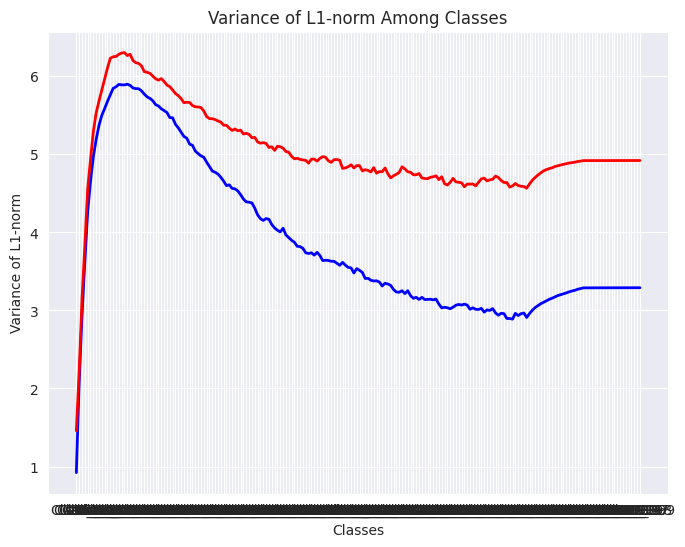

In [39]:
import matplotlib.pyplot as plt

# Assuming variance_l1_norm is the calculated variance # If you have multiple variances, create a list

plt.figure(figsize=(8, 6))
plt.plot(range(len(variance_list1)), variance_list1, color='blue', linestyle='-', linewidth=2)
plt.plot(range(len(variance_list2)), variance_list2, color='red', linestyle='-', linewidth=2)
plt.xlabel('Classes')
plt.ylabel('Variance of L1-norm')
plt.title('Variance of L1-norm Among Classes')
plt.xticks(range(len(variance_list1)), [f'Class_{i}' for i in range(len(variance_list1))])
plt.grid(True)
plt.show()